Реализация PINN на pytorch взята отсюда: https://github.com/jayroxis/PINNs/blob/master/Burgers%20Equation/Burgers%20Inference%20(PyTorch).ipynb

##PINN

коэффициенты

In [1]:
alpha = 1.0
beta = 0.0
k=1.4
w=1.8
x0=0.0
th0=0.0

решение

In [2]:
!pip install pyDOE

  Using cached pyDOE-0.3.8-py3-none-any.whl


In [3]:
import math
import torch
import matplotlib.pyplot as plt
from collections import OrderedDict #упорядоченный словарь
from pyDOE import lhs #функция, выбирающая значения для обучения на них нейросети
import numpy as np
import time
np.random.seed(1234)

In [4]:
#можно сменить среду выполнения на gpu и обучение будет происходить быстрее
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [5]:
class SinActivation(torch.nn.Module): #кастомная функция активации - sin
    def __init__(self):
        super(SinActivation, self).__init__()
        return
    def forward(self, x):
        return torch.sin(x)

нейросеть, в виде которой будет находиться решение

In [6]:
class DNN(torch.nn.Module):
    def __init__(self, layers): #принимает на вход массив целых чисел
        super(DNN, self).__init__() #вызывает метод init(почему нельзя сделать это без super?)

        self.depth = len(layers) - 1
        self.activation = SinActivation #в качестве функции активации используется sin

        layer_list = list() #список с весами и функциями активации для каждого слоя
        for i in range(self.depth - 1):
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])) #каждые два слоя образуют двудольный граф
            )
            layer_list.append(('activation_%d' % i, self.activation()))

        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1])) #нельзя сделать в цикле, потому что нет функции активации
        )

        layerDict = OrderedDict(layer_list) #сделали упорядоченный словарь, чтобы при использовании элементы выдавались в том порядке, в котором были добавлены

        # deploy layers
        self.layers = torch.nn.Sequential(layerDict) #собственно, задали архитектуру нейросети

    def forward(self, x):
        out = self.layers(x)
        return out

наконец, PINN

In [7]:
class PhysicsInformedNN():
    def __init__(self, X_uv, u, v, X_f, layers, lb, ub, alpha, beta):

        # граничные условия
        self.lb = torch.tensor(lb).float().to(device) #левое
        self.ub = torch.tensor(ub).float().to(device) #правое

        # данные для обучения
        self.x_uv = torch.tensor(X_uv[:, 0:1], requires_grad=True).float().to(device) #для граничных условий: (x_uv, t_uv, u, v)
        self.t_uv = torch.tensor(X_uv[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        self.v = torch.tensor(v).float().to(device)
        #self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device) #для уравнения: (x_f, t_f, f=0) (используются переданные сети точки)
        #self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor((lb + (ub-lb)*lhs(2, N_f))[:, 0:1], requires_grad=True).float().to(device) #создаём N_f точек для обучения соответствия уравнению. те, что переданы, не используем
        self.t_f = torch.tensor((lb + (ub-lb)*lhs(2, N_f))[:, 1:2], requires_grad=True).float().to(device)

        #данные для законов сохранения
        self.x_fragments = 100 #разбиение при интегрировании по x при фиксированном t
        self.t_amount = 10 #в скольких точках t считается интеграл
        x_l = np.linspace(x_0, x_1, self.x_fragments).reshape(self.x_fragments,1)
        t_l = np.linspace(t_0, t_1, self.t_amount).reshape(self.t_amount,1)
        self.x_l = torch.tensor(x_l, requires_grad=True).float().to(device)
        self.t_l = torch.tensor(t_l, requires_grad=True).float().to(device)

        # числовые коэффициенты в уравнении
        self.alpha = alpha
        self.beta = beta

        # модель
        self.layers = layers
        self.dnn = DNN(layers).to(device)

        # оптимизатор - LBFGS, обучает с точностью до 1e-5 или пока разница в точности уменьшается больше, чем точность float(?)
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(),
            lr=0.0001,
            max_iter=50000,
            max_eval=50000,
            history_size=50,
            tolerance_grad=1e-5,
            tolerance_change=1.0 * np.finfo(float).eps,
            #line_search_fn="strong_wolfe"
        )

        self.adam = torch.optim.Adam(
          self.dnn.parameters(),
          lr=0.005,
          betas=(0.9, 0.999),
          eps=1e-08,
          weight_decay=0,
          amsgrad=False)

        self.iter = 0

    def net_uv(self, x, t): # вывод модели
        u = self.dnn(torch.cat([x, t], dim=1))[:,0:1]
        v = self.dnn(torch.cat([x, t], dim=1))[:,1:2]
        return u, v

    def net_f(self, x, t): #вывод  функции
        """ The pytorch autograd version of calculating residual """
        u, v = self.net_uv(x, t)

        u_t = torch.autograd.grad(
            u, t,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0] #производая по t
        u_x = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0] #производная по x
        u_xx = torch.autograd.grad(
            u_x, x,
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0] #вторая призводная по x

        v_t = torch.autograd.grad(
            v, t,
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
        )[0] #производая по t
        v_x = torch.autograd.grad(
            v, x,
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
        )[0] #производная по x
        v_xx = torch.autograd.grad(
            v_x, x,
            grad_outputs=torch.ones_like(v_x),
            retain_graph=True,
            create_graph=True
        )[0] #вторая призводная по x

        f_u = u*(u**2 + v**2)*(-self.alpha*(u**2 + v**2) + self.beta*(u**2 + v**2)**2 + 1) + u_xx - v_t #это и есть действительная и коплексная части исходного уравнения
        f_v = u_t + v*(u**2 + v**2)*(-self.alpha*(u**2 + v**2) + self.beta*(u**2 + v**2)**2 + 1) + v_xx #они получены путём подстановки q=u+i*v в него
        return f_u, f_v

    def first_law(self): #реализация первого закона сохранения
        x_step=(self.x_l[1]-self.x_l[0]).item()
        initial_integral=0
        for j in range(0,self.x_fragments): #считаем интеграл по x в точке t_0
          u, v = self.net_uv(self.x_l[j:j+1], self.t_l[0:1]) #интеграл считается от вывода нейросети
          #u, v = q_tensor(self.x_l[j:j+1], self.t_l[0:1]) #интеграл считается от q(x,t), ведь она по сути дана в t_0
          initial_integral += (u**2 + v**2) * x_step

        variation=np.zeros(self.t_amount)
        for i in range(1,self.t_amount): #сравниваем с интегралом по x в других точках
          integral=0
          for j in range(0,self.x_fragments):
            u, v = self.net_uv(self.x_l[j:j+1], self.t_l[i:i+1])
            integral += (u**2 + v**2) * x_step
          variation[i]=(initial_integral-integral)**2

        return variation.mean(axis=0) #возвращаем средний квадрат отклонения

    def second_law(self): #реализация второго закона сохранения
        x_step=(self.x_l[1]-self.x_l[0]).item()
        initial_integral=0
        for j in range(0,self.x_fragments): #считаем интеграл по x в t_0
          u, v = self.net_uv(self.x_l[j:j+1], self.t_l[0:1]) #интеграл считается от вывода нейросети
          #u, v = q_tensor(self.x_l[j:j+1], self.t_l[0:1]) #интеграл считается от q(x,t)
          u_x = torch.autograd.grad(u, self.x_l, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
          v_x = torch.autograd.grad(v, self.x_l, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
          initial_integral += ((v_x[j] * u - u_x[j] * v) * x_step)

        variation=np.zeros(self.t_amount)
        for i in range(1,self.t_amount): #сравниваем с интегралом по x в других точках
          integral=0
          for j in range(0,self.x_fragments):
            u, v = self.net_uv(self.x_l[j:j+1], self.t_l[i:i+1])
            u_x = torch.autograd.grad(u, self.x_l, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0] #почему-то градиент по self.x_l[j:j+1] посчитать не получается
            v_x = torch.autograd.grad(v, self.x_l, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0] #поэтому вычисляется градиент по self.x_l и берётся j элемент
            integral += ((v_x[j] * u - u_x[j] * v) * x_step)
          variation[i]=(initial_integral-integral)**2

        return variation.mean(axis=0) #опять возвращаем средний квадрат отклонения

    def loss_func(self): #функция потерь
        self.optimizer.zero_grad() #обнуляет градиенты

        u_pred, v_pred = self.net_uv(self.x_uv, self.t_uv)
        f_u_pred, f_v_pred = self.net_f(self.x_f, self.t_f)
        loss_uv = torch.mean(((self.u - u_pred) ** 2 + (self.v - v_pred) ** 2)/2) #средний квадрат всех отклонений от начальных условий
        loss_f = torch.mean((f_u_pred ** 2 + f_v_pred ** 2)/2) #средний квадрат всех отклонений от условия

        loss = loss_uv + loss_f

        loss.backward()
        self.iter += 1
        if self.iter % 1000 == 0:
            print('Iter %d, Loss: %.5e, Loss_uv: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_uv.item(), loss_f.item()))
            #print('loss_fl: %.5e' %loss_fl.item())
            #print('loss_sl: %.5e' %loss_sl.item())
            loss_fl = self.first_law()
            loss_sl = self.second_law()
            loss_array.append(loss.item()) #loss запоминаем для графика
            loss_fl_array.append(loss_fl.item()) #loss_fl и loss_sl тоже
            loss_sl_array.append(loss_sl.item())
            iter_array.append(self.iter)

        if self.iter % 10 == 0: #каждые 10 итераций генерируем новые точки для обучения
          random_points = lb + (ub-lb)*lhs(2, N_f)
          self.x_f = torch.tensor(random_points[:, 0:1], requires_grad=True).float().to(device)
          self.t_f = torch.tensor(random_points[:, 1:2], requires_grad=True).float().to(device)

        return loss

    def train(self): #обучение
        adam_iterations = 30000
        print('training started')
        print('%d iterations of ADAM:' %adam_iterations)
        self.dnn.train()
        for i in range(adam_iterations): #во время тренировки производится 30000 шагов adam, а дальше запускается lbfgs
            if i % 100 == 0: self.adam.param_groups[0]['lr'] = 0.99*self.adam.param_groups[0]['lr'] #экспоненциальное уменьшение шага каждые 100 шагов
            self.adam.step(self.loss_func)
        #print('LBFGS:')
        #self.optimizer.step(self.loss_func)
        #print('Total iterations: %d + %d' %(adam_iterations, (self.iter-adam_iterations)))


    def predict(self, X): #вывод нейросети и функции на входных данных
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u, v = self.net_uv(x, t)
        f_u, f_v = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        v = v.detach().cpu().numpy()
        f_u = f_u.detach().cpu().numpy()
        f_v = f_v.detach().cpu().numpy()
        return u, v, f_u, f_v

параметры обучения

In [8]:
N_u = 200 # число точек, обучающих принимать граничные значения
N_f = 30000 # число точек, обучающих удовлетворять уравнению
x_parts = 1000 #число частей, на которые разбивается отрезок x
t_parts = 100 #число частей, на которые разбивается отрезок t
layers = [2, 100, 100, 100, 100, 2] #2 входа, 2 выхода и 4 слоя по 100 нейронов

#x_0=-20
#x_1=50
#t_0=0
#t_1=10
x_0=-100
x_1=100
t_0=0
t_1=30
x = np.linspace(x_0, x_1, x_parts)
t = np.linspace(t_0, t_1, t_parts)
X, T = np.meshgrid(x, t)

##начальное условие с известным аналитическим решением

In [9]:
def q(x,t):
  kexp = np.exp(np.sqrt(k ** 2 - w) * (x - 2 * k * t - x0))
  f_com = 4 * (k ** 2 - w) / (np.sqrt(k ** 2 - w) * kexp + 2 * np.sqrt(k ** 2 - w) / kexp)
  u = f_com * np.cos(k * x - w * t + th0)
  v = f_com * np.sin(k * x - w * t + th0)
  return u, v

In [10]:
Exact_u=q(X,T)[0]
Exact_v=q(X,T)[1]

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact_u.flatten()[:,None]
v_star = Exact_v.flatten()[:,None]

# границы области
lb = X_star.min(0)
ub = X_star.max(0)

# для обучения берём только данные на границах области(граничные условия по сути)
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T)) #(x,t_0)
uu1 = Exact_u[0:1,:].T
vv1 = Exact_v[0:1,:].T
xx2 = np.hstack((X[:,0:1], T[:,0:1])) #(x_0,t)
uu2 = np.zeros((t_parts,1)) #граничные условия поставил 0 в соответствии с требованиями
vv2 = np.zeros((t_parts,1))
xx3 = np.hstack((X[:,-1:], T[:,-1:])) #(x_1,t)
uu3 = np.zeros((t_parts,1)) #тут тоже
vv3 = np.zeros((t_parts,1))

X_uv_train = np.vstack([xx1, xx2, xx3]) #данные для тренировки в точках на границе
u_train = np.vstack([uu1, uu2, uu3])
v_train = np.vstack([vv1, vv2, vv3])
X_f_train = lb + (ub-lb)*lhs(2, N_f) #данные для тренировки в случайных точкам из области
X_f_train = np.vstack((X_f_train, X_uv_train)) #добавим к ним ещё и точки на границе, там f тоже 0

idx = np.random.choice(X_uv_train.shape[0], N_u, replace=False) #выберем из точек на границе только N_u
X_uv_train = X_uv_train[idx, :]
u_train = u_train[idx,:]
v_train = v_train[idx,:]

loss_array = [] #массив с loss в процессе обучения
loss_fl_array = [] #массивы с loss_fl и loss_sl
loss_sl_array = []
iter_array = [] #итерации с шагом 100

вот как оно выглядит:

<ipython-input-11-c2cfb31b79cc>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, Exact_u, cmap='RdBu', vmin=u_min, vmax=u_max)


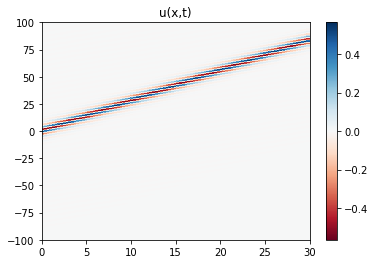

<ipython-input-11-c2cfb31b79cc>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, Exact_v, cmap='RdBu', vmin=v_min, vmax=v_max)


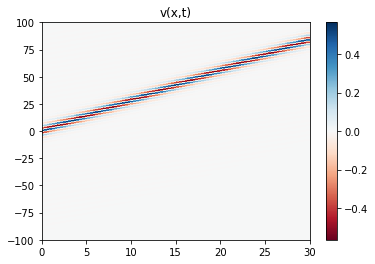

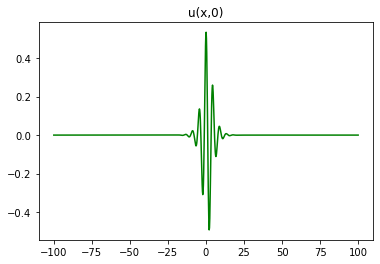

In [11]:
fig, ax = plt.subplots()
u_min, u_max = -np.abs(Exact_u).max(), np.abs(Exact_u).max()
c = ax.pcolormesh(T, X, Exact_u, cmap='RdBu', vmin=u_min, vmax=u_max)
ax.set_title('u(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
plt.show()

fig, ax = plt.subplots()
v_min, v_max = -np.abs(Exact_v).max(), np.abs(Exact_v).max()
c = ax.pcolormesh(T, X, Exact_v, cmap='RdBu', vmin=v_min, vmax=v_max)
ax.set_title('v(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
plt.show()

plt.plot(X[0, :], Exact_u[0,:], color = "green")
plt.title('u(x,0)')
plt.show()

Обучение

In [12]:
model = PhysicsInformedNN(X_uv_train, u_train, v_train, X_f_train, layers, lb, ub, alpha, beta)

In [13]:
%%time
#штука сверху выведет итоговое время выполнения
model.train()

training started
30000 iterations of ADAM:
Iter 1000, Loss: 3.08420e-05, Loss_uv: 1.90257e-06, Loss_f: 2.89394e-05
Iter 2000, Loss: 6.30035e-05, Loss_uv: 4.51267e-06, Loss_f: 5.84909e-05
Iter 3000, Loss: 4.25816e-05, Loss_uv: 2.59324e-06, Loss_f: 3.99883e-05
Iter 4000, Loss: 2.56611e-05, Loss_uv: 9.70294e-07, Loss_f: 2.46908e-05
Iter 5000, Loss: 2.47279e-05, Loss_uv: 7.01169e-06, Loss_f: 1.77163e-05
Iter 6000, Loss: 1.30552e-05, Loss_uv: 7.80167e-07, Loss_f: 1.22750e-05
Iter 7000, Loss: 1.06602e-05, Loss_uv: 1.00986e-06, Loss_f: 9.65034e-06
Iter 8000, Loss: 1.42641e-05, Loss_uv: 4.44104e-07, Loss_f: 1.38200e-05
Iter 9000, Loss: 1.02697e-05, Loss_uv: 4.47170e-07, Loss_f: 9.82256e-06
Iter 10000, Loss: 9.11993e-06, Loss_uv: 5.57339e-07, Loss_f: 8.56259e-06
Iter 11000, Loss: 7.63041e-06, Loss_uv: 3.31082e-07, Loss_f: 7.29933e-06
Iter 12000, Loss: 8.56169e-06, Loss_uv: 1.88899e-06, Loss_f: 6.67270e-06
Iter 13000, Loss: 6.14730e-06, Loss_uv: 2.72236e-07, Loss_f: 5.87507e-06
Iter 14000, Loss:

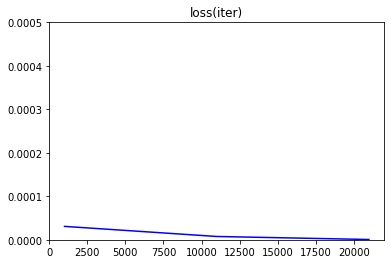

In [14]:
plt.plot(np.array(iter_array)[::10], np.array(loss_array)[::10], color = "blue")
plt.ylim(0,5e-4)
plt.title('loss(iter)')
plt.show()

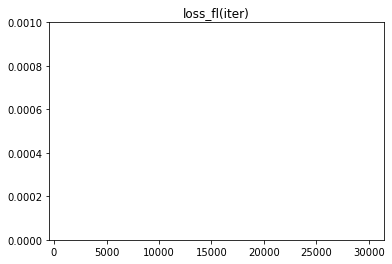

In [15]:
plt.plot(np.array(iter_array), np.array(loss_fl_array), color = "blue")
plt.ylim(0,1e-3)
plt.title('loss_fl(iter)')
plt.show()

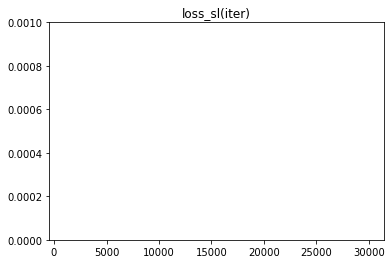

In [16]:
plt.plot(np.array(iter_array), np.array(loss_sl_array), color = "blue")
plt.ylim(0,1e-3)
plt.title('loss_sl(iter)')
plt.show()

In [17]:
torch.save(model, 'model_10(1,1,3).pth') #сохраняем модель

/opt/conda/lib/python3.8/site-packages/torch/serialization.py:359: UserWarning: Couldn't retrieve source code for container of type DNN. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "
/opt/conda/lib/python3.8/site-packages/torch/serialization.py:359: UserWarning: Couldn't retrieve source code for container of type SinActivation. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


In [18]:
u_pred, v_pred, f_u_pred, f_v_pred = model.predict(X_star) #можно ради интереса сравнить с суммой дух решений, которая строго говоря не является решением(но именно от неё и берутся начальные условия)
mse_u = ((u_star-u_pred)**2).mean(axis=0).item()
mse_v = ((v_star-v_pred)**2).mean(axis=0).item()
mse_q = (((u_star**2+v_star**2)**0.5 - (u_pred**2+v_pred**2)**0.5)**2).mean(axis=0).item() #средний квадрат разности модулей
mse_f_u = ((f_u_pred)**2).mean(axis=0).item()
mse_f_v = ((f_v_pred)**2).mean(axis=0).item()
print('MSE_u: %e, MSE_v: %e, MSE_q: %e' %(mse_u, mse_v, mse_q)) #сравнение с суммой решений, ради интереса
print('MSE_f_u: %e, MSE_f_v: %e' %(mse_f_u, mse_f_v))

MSE_u: 4.824858e-03, MSE_v: 4.821468e-03, MSE_q: 1.065443e-03
MSE_f_u: 3.165004e-07, MSE_f_v: 2.835573e-07


Визуализация

Что выдала нейросеть:

<ipython-input-19-c42e7cd87c3e>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, u_pred.reshape((t_parts, x_parts)), cmap='RdBu', vmin=u_min, vmax=u_max)


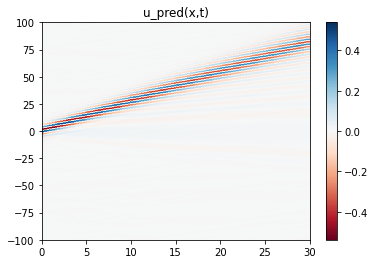

<ipython-input-19-c42e7cd87c3e>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, v_pred.reshape((t_parts, x_parts)), cmap='RdBu', vmin=v_min, vmax=v_max)


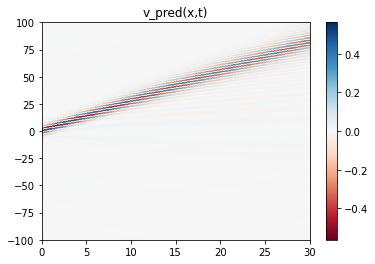

In [19]:
fig, ax = plt.subplots()
u_min, u_max = -np.abs(u_pred).max(), np.abs(u_pred).max()
c = ax.pcolormesh(T, X, u_pred.reshape((t_parts, x_parts)), cmap='RdBu', vmin=u_min, vmax=u_max)
ax.set_title('u_pred(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
#plt.scatter(X_uv_train[:,1], X_uv_train[:,0], s=7, color='black')
#plt.scatter(X_f_train[:,1], X_f_train[:,0], s=3, color='black', alpha=0.3)
plt.show()

fig, ax = plt.subplots()
v_min, v_max = -np.abs(v_pred).max(), np.abs(v_pred).max()
c = ax.pcolormesh(T, X, v_pred.reshape((t_parts, x_parts)), cmap='RdBu', vmin=v_min, vmax=v_max)
ax.set_title('v_pred(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
plt.show()

Что должно быть в теории:

<ipython-input-20-3c5c3b734f9c>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, Exact_u, cmap='RdBu', vmin=u_min, vmax=u_max)


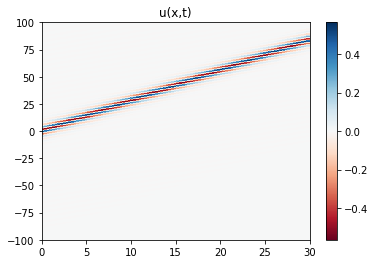

<ipython-input-20-3c5c3b734f9c>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, Exact_v, cmap='RdBu', vmin=v_min, vmax=v_max)


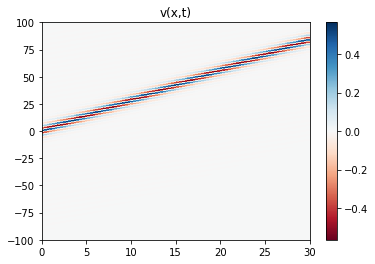

In [20]:
fig, ax = plt.subplots()
u_min, u_max = -np.abs(Exact_u).max(), np.abs(Exact_u).max()
c = ax.pcolormesh(T, X, Exact_u, cmap='RdBu', vmin=u_min, vmax=u_max)
ax.set_title('u(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
plt.show()

fig, ax = plt.subplots()
v_min, v_max = -np.abs(Exact_v).max(), np.abs(Exact_v).max()
c = ax.pcolormesh(T, X, Exact_v, cmap='RdBu', vmin=v_min, vmax=v_max)
ax.set_title('v(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
plt.show()

Решение в срезах по t:

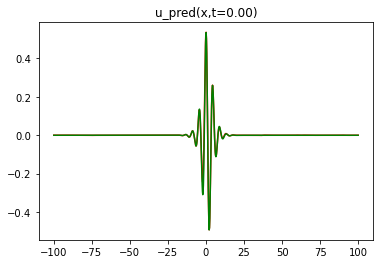

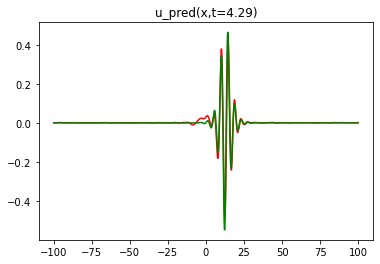

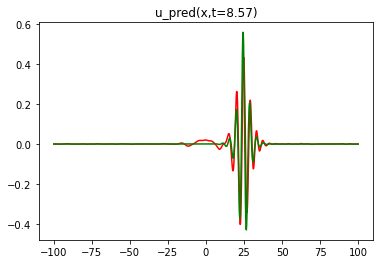

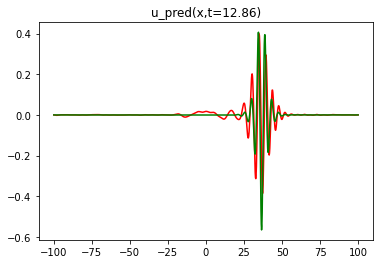

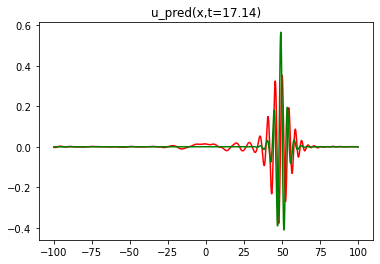

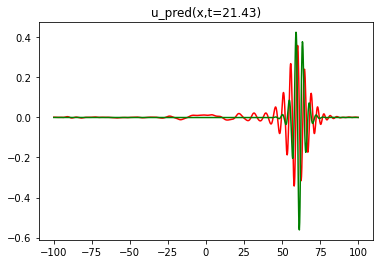

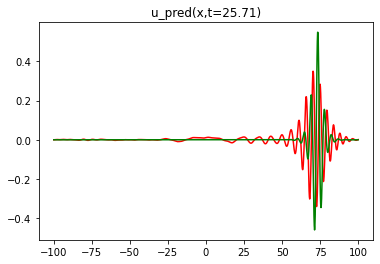

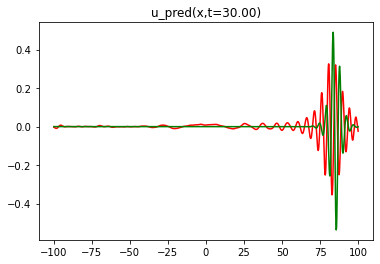

In [21]:
t=t_0
while t<=t_1:
  current_row = int(t_parts*(t-t_0)/(t_1-t_0))
  if t==t_1: current_row=-1 #если смотрим значения в t_1, то ясно что это последняя колонка
  plt.plot(X[current_row, :], u_pred.reshape((t_parts, x_parts))[current_row,:], color = "red") #предсказанное решение
  plt.plot(X[current_row, :], Exact_u[current_row,:], color = "green") #аналитическое решение
  plt.title('u_pred(x,t=%.2f)'%t)
  plt.show()
  t+=abs(t_1-t_0)/7

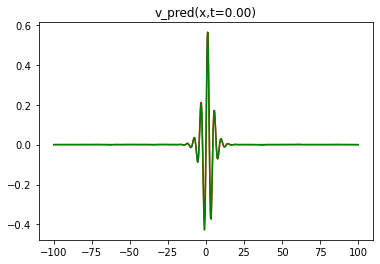

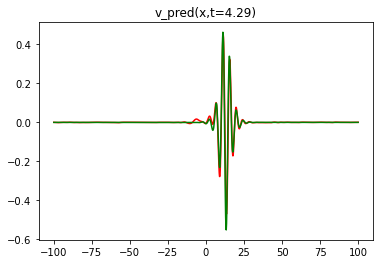

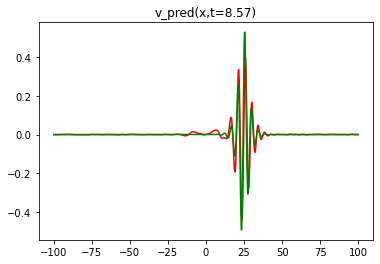

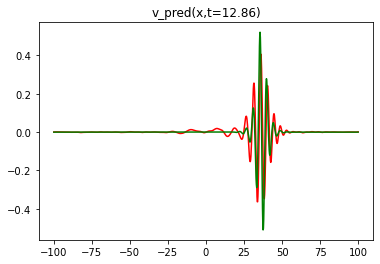

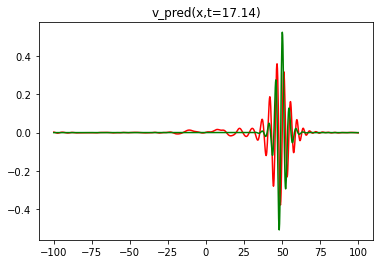

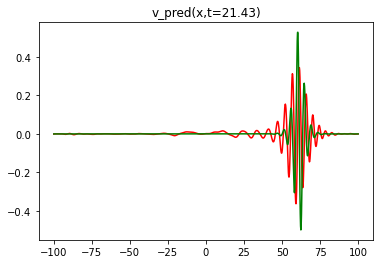

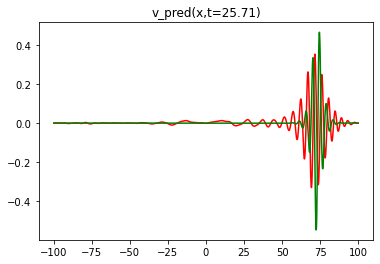

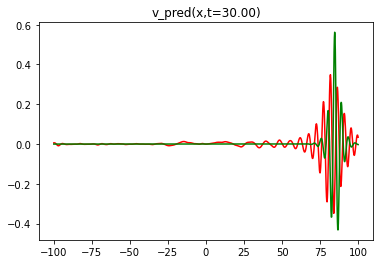

In [22]:
t=t_0
while t<=t_1:
  current_row = int(t_parts*(t-t_0)/(t_1-t_0))
  if t==t_1: current_row=-1 #если смотрим значения в t_1, то ясно что это последняя колонка
  plt.plot(X[current_row, :], v_pred.reshape((t_parts, x_parts))[current_row,:], color = "red")
  plt.plot(X[current_row, :], Exact_v[current_row,:], color = "green")
  plt.title('v_pred(x,t=%.2f)'%t)
  plt.show()
  t+=abs(t_1-t_0)/7

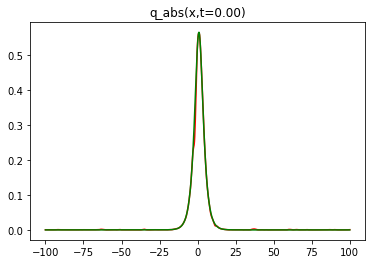

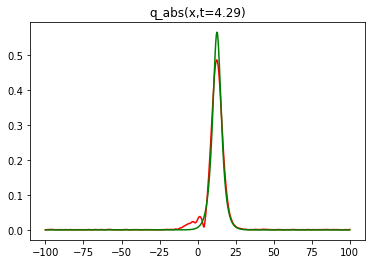

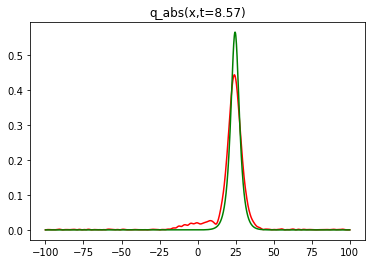

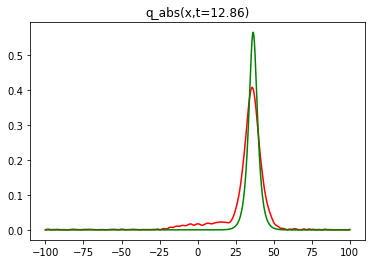

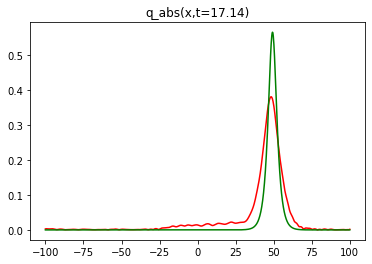

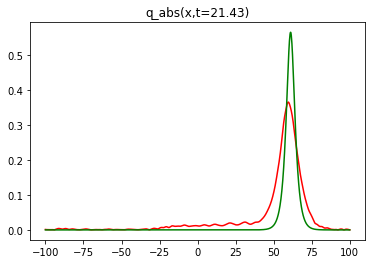

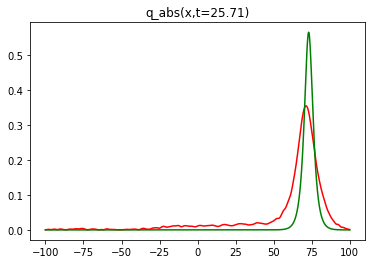

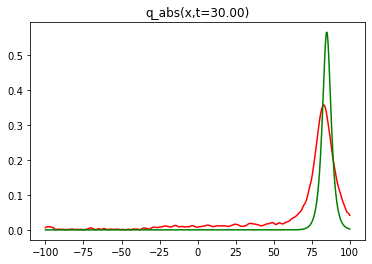

In [23]:
t=t_0
while t<=t_1:
  current_row = int(t_parts*(t-t_0)/(t_1-t_0))
  if t==t_1: current_row=-1 #если смотрим значения в t_1, то ясно что это последняя колонка
  q_abs_pred = (u_pred.reshape((t_parts, x_parts))[current_row,:]**2 + v_pred.reshape((t_parts, x_parts))[current_row,:]**2)**0.5
  q_abs_exact = (Exact_u[current_row,:]**2 + Exact_v[current_row,:]**2)**0.5
  plt.plot(X[current_row, :], q_abs_pred, color = "red")
  plt.plot(X[current_row, :], q_abs_exact, color = "green")
  plt.title('q_abs(x,t=%.2f)'%t)
  plt.show()
  t+=abs(t_1-t_0)/7

Точность выполнения условий уравнения:

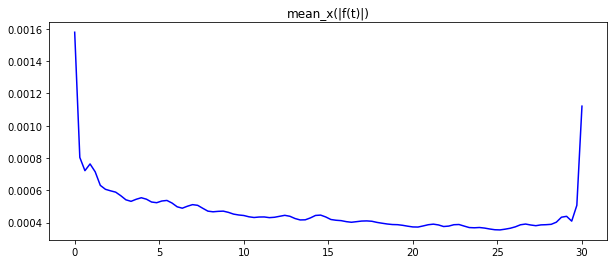

Mean_xt(|f|): 4.676589e-04


In [24]:
loss_abs_f = (f_u_pred**2 + f_v_pred**2)**0.5 #тензор модулей значений уравнения
loss_abs_f_array=[]
t_array=[]
for t in np.linspace(t_0, t_1, 100):
  current_row = int(t_parts*(t-t_0)/(t_1-t_0))
  if t==t_1: current_row=-1 #если смотрим значения в t_1, то ясно что это последняя колонка
  loss_abs_f_array.append(loss_abs_f.reshape((t_parts, x_parts))[current_row,:].mean())
  t_array.append(t)
plt.figure(figsize=(10,4))
plt.plot(t_array, loss_abs_f_array, color = "blue")
plt.title('mean_x(|f(t)|)') #среднее значение модуля функции на срезе при фиксированном t
plt.show()
print('Mean_xt(|f|): %e' %loss_abs_f.mean(axis=0).item()) #среднее значение модуля функции на всей сетке

Проверка законов сохранения:

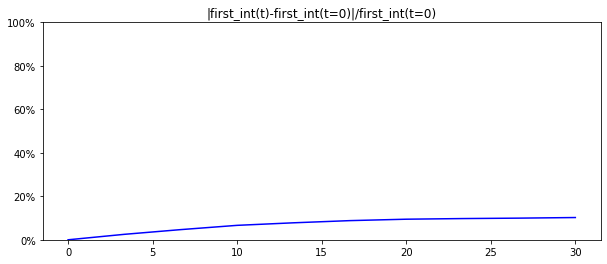

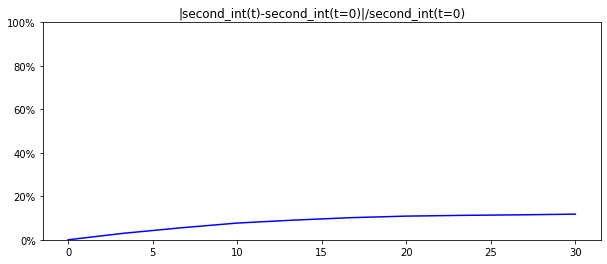

First law MSE: 1.409359e-02, Second law MSE: 3.554282e-02
First law mean: 1.071260e-01, Second law mean: 1.704457e-01


In [25]:
import matplotlib.ticker as mtick
x_fragments = 400 #разбиение при интегрировании по x при фиксированном t
t_amount = 10 #в скольких точках t считается интеграл
x_l = np.linspace(x_0, x_1, x_fragments).reshape(x_fragments,1)
t_l = np.linspace(t_0, t_1, t_amount).reshape(t_amount,1)
X_l = torch.tensor(x_l, requires_grad=True).float().to(device)
T_l = torch.tensor(t_l, requires_grad=True).float().to(device)
x_step=(X_l[1]-X_l[0]).item()

#реализация первого закона сохранения
u, v = model.net_uv(X_l, torch.full((x_fragments,1),T_l[0:1].item(), requires_grad=True).float().to(device))
initial_integral = ((u**2 + v**2) * x_step).sum() #вычисляем интеграл в t_0
u, v = model.net_uv(X_l.expand(x_fragments, t_amount).T.reshape(x_fragments*t_amount,1), T_l.expand(t_amount, x_fragments).reshape(x_fragments*t_amount,1))
first_variation = (((u.reshape(t_amount, x_fragments)**2 + v.reshape(t_amount, x_fragments)**2) * x_step).sum(axis=1) - initial_integral)**2 #вычисляем интегралы при других t и находим отклонение
first_variation = first_variation.detach()
MSE_fl = first_variation.mean(axis=0).item() #возвращаем средний квадрат отклонения
mean_fl = (first_variation**0.5).mean(axis=0).item() #а также средний модуль отклонения
plt.figure(figsize=(10,4))
plt.plot(t_l, (first_variation**0.5/initial_integral).detach().cpu(), color = "blue") #строим график соблюдения первого закона сохранения(чем ближе к 0, тем лучше)
plt.title('|first_int(t)-first_int(t=0)|/first_int(t=0)')
plt.ylim(0,1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0)) #меняем числа на проценты
plt.show()

#реализация второго закона сохранения
u, v = model.net_uv(X_l, torch.full((x_fragments,1),T_l[0:1].item(), requires_grad=True).float().to(device))
u_x = torch.autograd.grad(u, X_l, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
v_x = torch.autograd.grad(v, X_l, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
initial_integral = ((v_x*u - u_x*v) * x_step).sum() #вычисляем интеграл в t_0
X_l_expanded = X_l.expand(x_fragments, t_amount).T.reshape(x_fragments*t_amount,1)
T_l_expanded = T_l.expand(t_amount, x_fragments).reshape(x_fragments*t_amount,1)
u, v = model.net_uv(X_l_expanded, T_l_expanded)
u_x = torch.autograd.grad(u, X_l_expanded, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
v_x = torch.autograd.grad(v, X_l_expanded, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
second_variation = ((((v_x*u).reshape(t_amount, x_fragments) - (u_x*v).reshape(t_amount, x_fragments)) * x_step).sum(axis=1) - initial_integral)**2 #вычисляем интегралы при других t и находим отклонение
second_variation = second_variation.detach()
MSE_sl = second_variation.mean(axis=0).item() #возвращаем средний квадрат отклонения
mean_sl = (second_variation**0.5).mean(axis=0).item() #а также средний модуль отклонения
plt.figure(figsize=(10,4))
plt.plot(t_l, (second_variation**0.5/initial_integral).detach().cpu(), color = "blue") #строим график соблюдения первого закона сохранения(чем ближе к 0, тем лучше)
plt.title('|second_int(t)-second_int(t=0)|/second_int(t=0)')
plt.ylim(0,1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.show()

print('First law MSE: %e, Second law MSE: %e' %(MSE_fl, MSE_sl))
print('First law mean: %e, Second law mean: %e' %(mean_fl, mean_sl)) #среднее значение модуля отклонения интеграла от первоначального значения

##начальные условия с неизвестным аналитическим решением  


###$q(x,0)=(1-i)e^{-\frac{x}{2}^2}$

In [26]:
def q(x,t):
  f_com = np.exp(-(x/2)**2)
  u = f_com
  v = -f_com
  return u, v

In [27]:
Exact_u=q(X,T)[0]
Exact_v=q(X,T)[1]

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact_u.flatten()[:,None]
v_star = Exact_v.flatten()[:,None]

# границы области
lb = X_star.min(0)
ub = X_star.max(0)

# для обучения берём только данные на границах области(граничные условия по сути)
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T)) #(x,t_0)
uu1 = Exact_u[0:1,:].T
vv1 = Exact_v[0:1,:].T
xx2 = np.hstack((X[:,0:1], T[:,0:1])) #(x_0,t)
uu2 = np.zeros((t_parts,1)) #граничные условия поставил 0 в соответствии с требованиями
vv2 = np.zeros((t_parts,1))
xx3 = np.hstack((X[:,-1:], T[:,-1:])) #(x_1,t)
uu3 = np.zeros((t_parts,1)) #тут тоже
vv3 = np.zeros((t_parts,1))

X_uv_train = np.vstack([xx1, xx2, xx3]) #данные для тренировки в точках на границе
u_train = np.vstack([uu1, uu2, uu3])
v_train = np.vstack([vv1, vv2, vv3])
X_f_train = lb + (ub-lb)*lhs(2, N_f) #данные для тренировки в случайных точкам из области
X_f_train = np.vstack((X_f_train, X_uv_train)) #добавим к ним ещё и точки на границе, там f тоже 0

idx = np.random.choice(X_uv_train.shape[0], N_u, replace=False) #выберем из точек на границе только N_u
X_uv_train = X_uv_train[idx, :]
u_train = u_train[idx,:]
v_train = v_train[idx,:]

loss_array = [] #массив с loss в процессе обучения
loss_fl_array = [] #массивы с loss_fl и loss_sl
loss_sl_array = []
iter_array = [] #итерации с шагом 100

вот как оно выглядит:

<ipython-input-28-f8f2665dde87>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, Exact_u, cmap='RdBu', vmin=u_min, vmax=u_max)


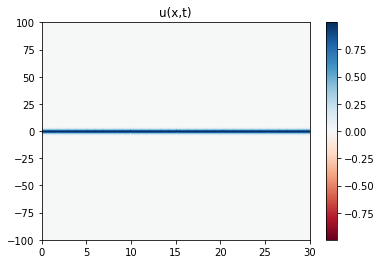

<ipython-input-28-f8f2665dde87>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, Exact_v, cmap='RdBu', vmin=v_min, vmax=v_max)


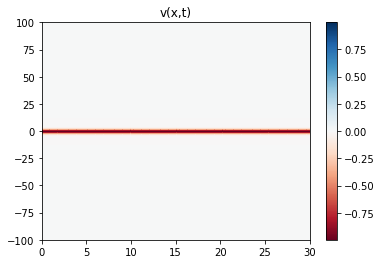

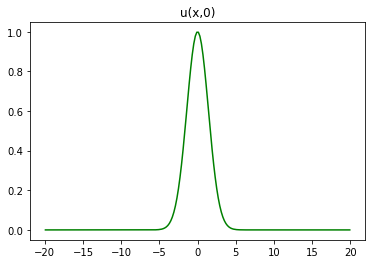

In [28]:
fig, ax = plt.subplots()
u_min, u_max = -np.abs(Exact_u).max(), np.abs(Exact_u).max()
c = ax.pcolormesh(T, X, Exact_u, cmap='RdBu', vmin=u_min, vmax=u_max)
ax.set_title('u(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
plt.show()

fig, ax = plt.subplots()
v_min, v_max = -np.abs(Exact_v).max(), np.abs(Exact_v).max()
c = ax.pcolormesh(T, X, Exact_v, cmap='RdBu', vmin=v_min, vmax=v_max)
ax.set_title('v(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
plt.show()

plt.plot(X[0, 400:600], Exact_u[0,400:600], color = "green")
plt.title('u(x,0)')
plt.show()

Обучение

In [29]:
model = PhysicsInformedNN(X_uv_train, u_train, v_train, X_f_train, layers, lb, ub, alpha, beta)

In [30]:
%%time
#штука сверху выведет итоговое время выполнения
model.train()

training started
30000 iterations of ADAM:
Iter 1000, Loss: 6.20157e-05, Loss_uv: 9.52320e-06, Loss_f: 5.24925e-05
Iter 2000, Loss: 4.03379e-05, Loss_uv: 3.65672e-06, Loss_f: 3.66812e-05
Iter 3000, Loss: 2.00596e-05, Loss_uv: 1.35569e-06, Loss_f: 1.87039e-05
Iter 4000, Loss: 1.93133e-05, Loss_uv: 2.65025e-06, Loss_f: 1.66630e-05
Iter 5000, Loss: 1.20645e-04, Loss_uv: 2.35943e-05, Loss_f: 9.70503e-05
Iter 6000, Loss: 2.32752e-05, Loss_uv: 1.09704e-06, Loss_f: 2.21781e-05
Iter 7000, Loss: 3.72988e-05, Loss_uv: 1.01041e-05, Loss_f: 2.71947e-05
Iter 8000, Loss: 1.38163e-05, Loss_uv: 7.53790e-07, Loss_f: 1.30625e-05
Iter 9000, Loss: 1.11211e-05, Loss_uv: 6.30238e-07, Loss_f: 1.04908e-05
Iter 10000, Loss: 1.97790e-05, Loss_uv: 4.63354e-06, Loss_f: 1.51455e-05
Iter 11000, Loss: 1.39540e-05, Loss_uv: 2.64405e-06, Loss_f: 1.13100e-05
Iter 12000, Loss: 3.80504e-05, Loss_uv: 2.17070e-06, Loss_f: 3.58797e-05
Iter 13000, Loss: 2.48255e-05, Loss_uv: 7.38983e-06, Loss_f: 1.74356e-05
Iter 14000, Loss:

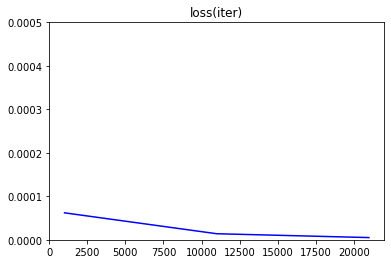

In [31]:
import matplotlib.pyplot as plt
plt.plot(np.array(iter_array)[::10], np.array(loss_array)[::10], color = "blue")
plt.ylim(0,5e-4)
plt.title('loss(iter)')
plt.show()

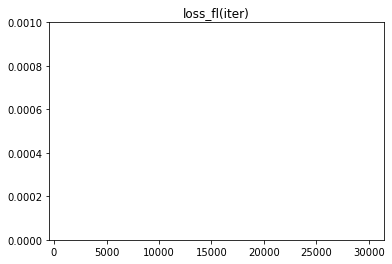

In [32]:
plt.plot(np.array(iter_array), np.array(loss_fl_array), color = "blue")
plt.ylim(0,1e-3)
plt.title('loss_fl(iter)')
plt.show()

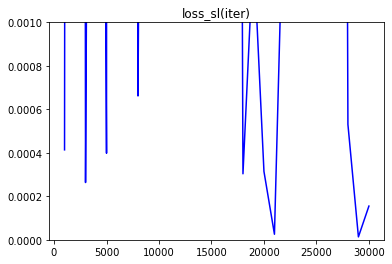

In [33]:
plt.plot(np.array(iter_array), np.array(loss_sl_array), color = "blue")
plt.ylim(0,1e-3)
plt.title('loss_sl(iter)')
plt.show()

In [34]:
u_pred, v_pred, f_u_pred, f_v_pred = model.predict(X_star) #можно ради интереса сравнить с суммой дух решений, которая строго говоря не является решением(но именно от неё и берутся начальные условия)
mse_u = ((u_star-u_pred)**2).mean(axis=0).item()
mse_v = ((v_star-v_pred)**2).mean(axis=0).item()
mse_q = (((u_star**2+v_star**2)**0.5 - (u_pred**2+v_pred**2)**0.5)**2).mean(axis=0).item() #средний квадрат разности модулей
mse_f_u = ((f_u_pred)**2).mean(axis=0).item()
mse_f_v = ((f_v_pred)**2).mean(axis=0).item()
print('MSE_u: %e, MSE_v: %e, MSE_q: %e' %(mse_u, mse_v, mse_q))
print('MSE_f_u: %e, MSE_f_v: %e' %(mse_f_u, mse_f_v))

MSE_u: 2.489386e-02, MSE_v: 3.092510e-02, MSE_q: 3.343896e-02
MSE_f_u: 3.344643e-05, MSE_f_v: 6.551591e-06


Визуализация

Что выдала нейросеть:

<ipython-input-35-c42e7cd87c3e>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, u_pred.reshape((t_parts, x_parts)), cmap='RdBu', vmin=u_min, vmax=u_max)


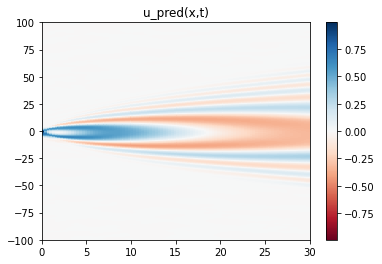

<ipython-input-35-c42e7cd87c3e>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, v_pred.reshape((t_parts, x_parts)), cmap='RdBu', vmin=v_min, vmax=v_max)


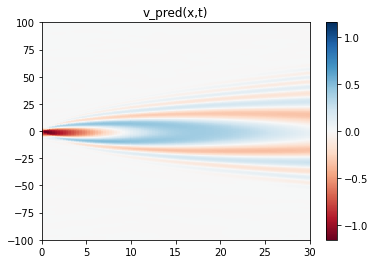

In [35]:
fig, ax = plt.subplots()
u_min, u_max = -np.abs(u_pred).max(), np.abs(u_pred).max()
c = ax.pcolormesh(T, X, u_pred.reshape((t_parts, x_parts)), cmap='RdBu', vmin=u_min, vmax=u_max)
ax.set_title('u_pred(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
#plt.scatter(X_uv_train[:,1], X_uv_train[:,0], s=7, color='black')
#plt.scatter(X_f_train[:,1], X_f_train[:,0], s=3, color='black', alpha=0.3)
plt.show()

fig, ax = plt.subplots()
v_min, v_max = -np.abs(v_pred).max(), np.abs(v_pred).max()
c = ax.pcolormesh(T, X, v_pred.reshape((t_parts, x_parts)), cmap='RdBu', vmin=v_min, vmax=v_max)
ax.set_title('v_pred(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
plt.show()

Что должно быть в теории:

<ipython-input-36-3c5c3b734f9c>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, Exact_u, cmap='RdBu', vmin=u_min, vmax=u_max)


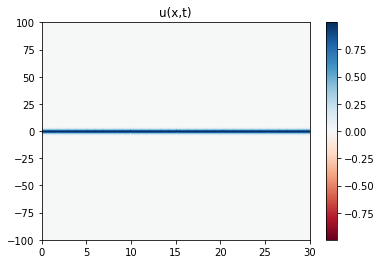

<ipython-input-36-3c5c3b734f9c>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, Exact_v, cmap='RdBu', vmin=v_min, vmax=v_max)


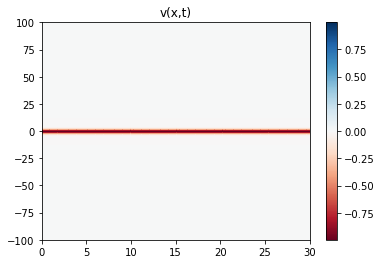

In [36]:
fig, ax = plt.subplots()
u_min, u_max = -np.abs(Exact_u).max(), np.abs(Exact_u).max()
c = ax.pcolormesh(T, X, Exact_u, cmap='RdBu', vmin=u_min, vmax=u_max)
ax.set_title('u(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
plt.show()

fig, ax = plt.subplots()
v_min, v_max = -np.abs(Exact_v).max(), np.abs(Exact_v).max()
c = ax.pcolormesh(T, X, Exact_v, cmap='RdBu', vmin=v_min, vmax=v_max)
ax.set_title('v(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
plt.show()

Решение в срезах по t:

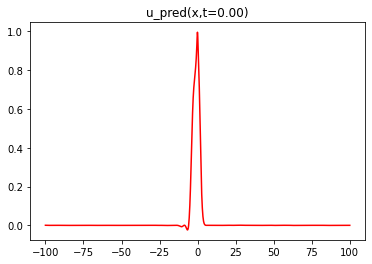

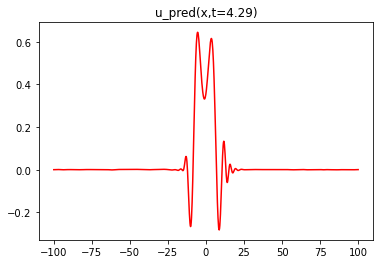

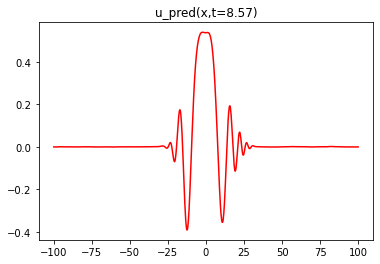

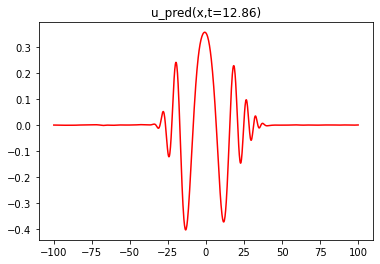

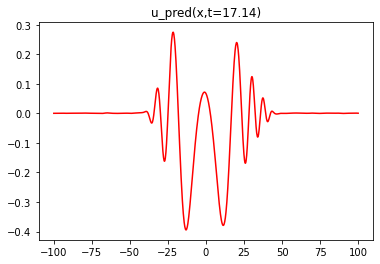

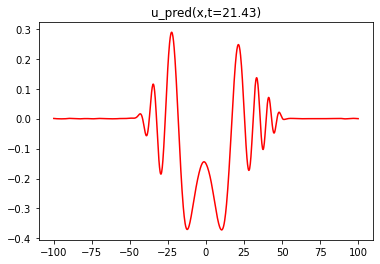

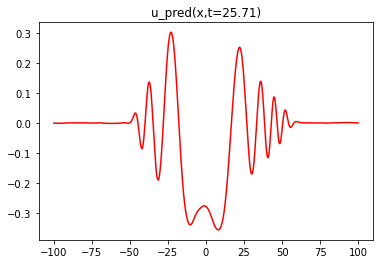

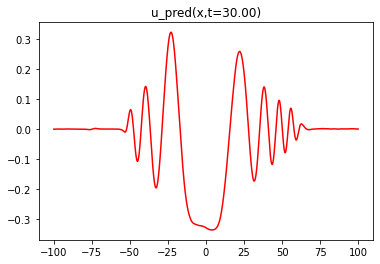

In [37]:
t=t_0
while t<=t_1:
  current_row = int(t_parts*(t-t_0)/(t_1-t_0))
  if t==t_1: current_row=-1 #если смотрим значения в t_1, то ясно что это последняя колонка
  plt.plot(X[current_row, :], u_pred.reshape((t_parts, x_parts))[current_row,:], color = "red") #предсказанное решение
  #plt.plot(X[current_row, :], Exact_u[current_row,:], color = "green")
  plt.title('u_pred(x,t=%.2f)'%t)
  plt.show()
  t+=abs(t_1-t_0)/7

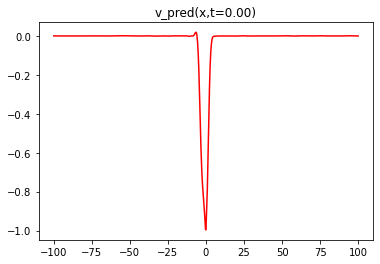

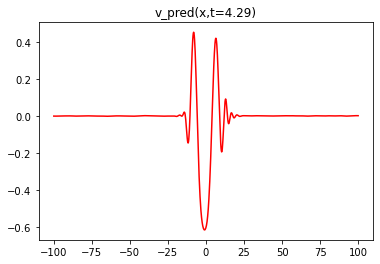

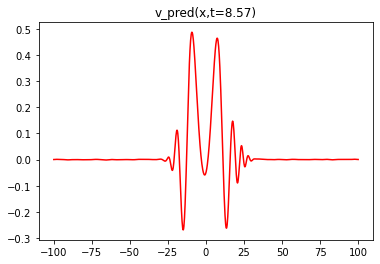

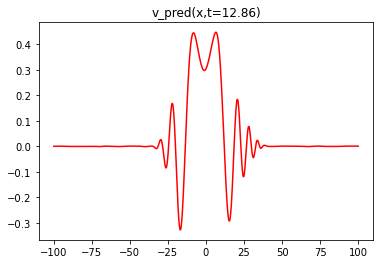

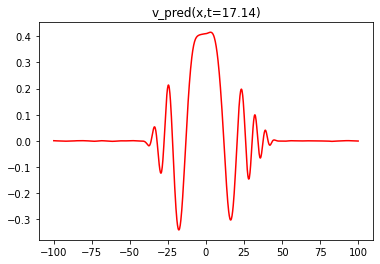

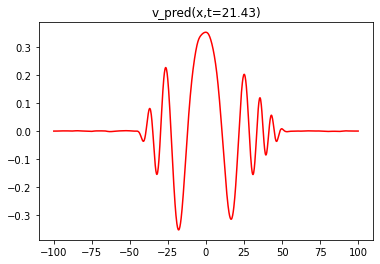

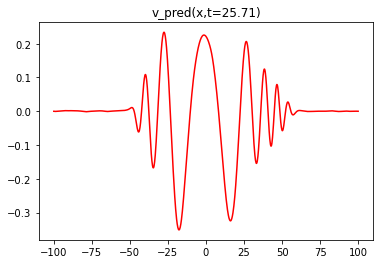

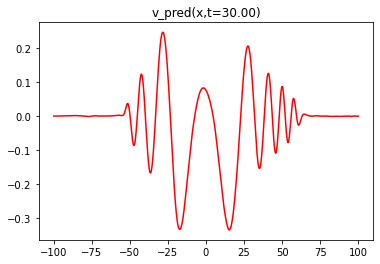

In [38]:
t=t_0
while t<=t_1:
  current_row = int(t_parts*(t-t_0)/(t_1-t_0))
  if t==t_1: current_row=-1 #если смотрим значения в t_1, то ясно что это последняя колонка
  plt.plot(X[current_row, :], v_pred.reshape((t_parts, x_parts))[current_row,:], color = "red")
  #plt.plot(X[current_row, :], Exact_v[current_row,:], color = "green")
  plt.title('v_pred(x,t=%.2f)'%t)
  plt.show()
  t+=abs(t_1-t_0)/7

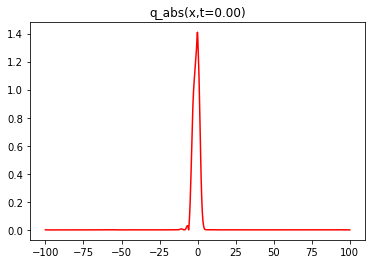

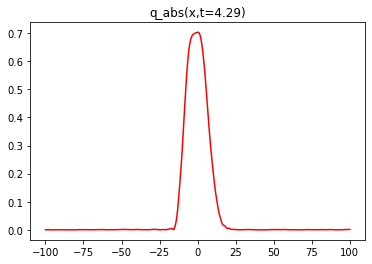

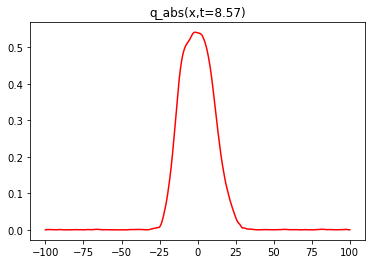

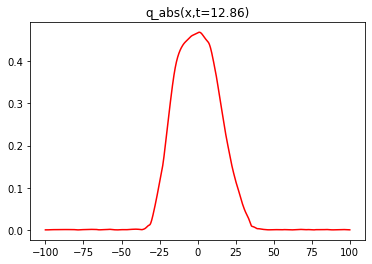

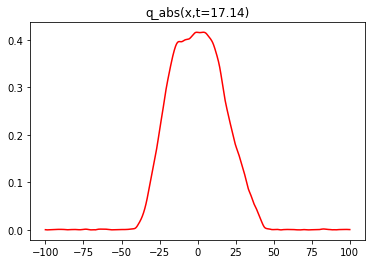

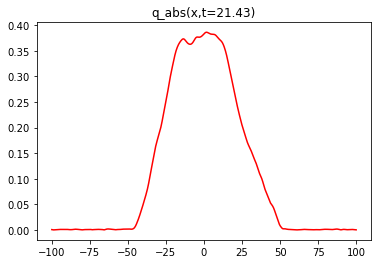

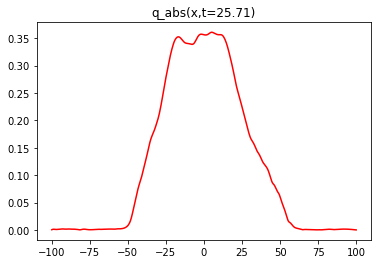

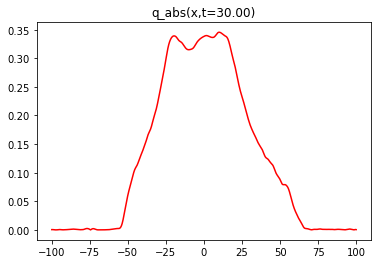

In [39]:
t=t_0
while t<=t_1:
  current_row = int(t_parts*(t-t_0)/(t_1-t_0))
  if t==t_1: current_row=-1 #если смотрим значения в t_1, то ясно что это последняя колонка
  q_abs_pred = (u_pred.reshape((t_parts, x_parts))[current_row,:]**2 + v_pred.reshape((t_parts, x_parts))[current_row,:]**2)**0.5
  q_abs_exact = (Exact_u[current_row,:]**2 + Exact_v[current_row,:]**2)**0.5
  plt.plot(X[current_row, :], q_abs_pred, color = "red")
  #plt.plot(X[current_row, :], q_abs_exact, color = "green")
  plt.title('q_abs(x,t=%.2f)'%t)
  plt.show()
  t+=abs(t_1-t_0)/7

Точность выполнения условий уравнения:

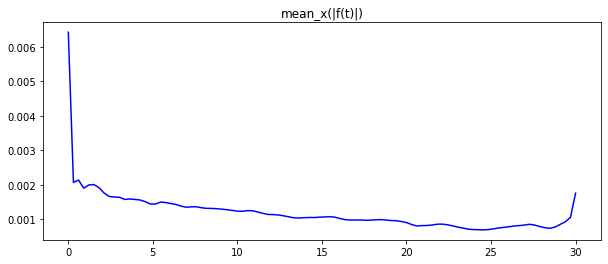

Mean_xt(|f|): 1.199937e-03


In [40]:
loss_abs_f = (f_u_pred**2 + f_v_pred**2)**0.5 #тензор модулей значений уравнения
loss_abs_f_array=[]
t_array=[]
for t in np.linspace(t_0, t_1, 100):
  current_row = int(t_parts*(t-t_0)/(t_1-t_0))
  if t==t_1: current_row=-1 #если смотрим значения в t_1, то ясно что это последняя колонка
  loss_abs_f_array.append(loss_abs_f.reshape((t_parts, x_parts))[current_row,:].mean())
  t_array.append(t)
plt.figure(figsize=(10,4))
plt.plot(t_array, loss_abs_f_array, color = "blue")
plt.title('mean_x(|f(t)|)') #среднее значение модуля функции на срезе при фиксированном t
plt.show()
print('Mean_xt(|f|): %e' %loss_abs_f.mean(axis=0).item()) #среднее значение модуля функции на всей сетке

Проверка законов сохранения:

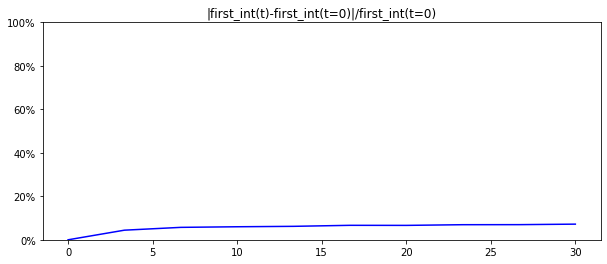

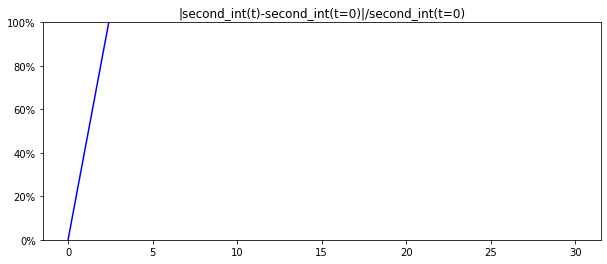

First law MSE: 1.882938e-01, Second law MSE: 5.240128e-04
First law mean: 4.083266e-01, Second law mean: 2.022266e-02


In [41]:
import matplotlib.ticker as mtick
x_fragments = 400 #разбиение при интегрировании по x при фиксированном t
t_amount = 10 #в скольких точках t считается интеграл
x_l = np.linspace(x_0, x_1, x_fragments).reshape(x_fragments,1)
t_l = np.linspace(t_0, t_1, t_amount).reshape(t_amount,1)
X_l = torch.tensor(x_l, requires_grad=True).float().to(device)
T_l = torch.tensor(t_l, requires_grad=True).float().to(device)
x_step=(X_l[1]-X_l[0]).item()

#реализация первого закона сохранения
u, v = model.net_uv(X_l, torch.full((x_fragments,1),T_l[0:1].item(), requires_grad=True).float().to(device))
initial_integral = ((u**2 + v**2) * x_step).sum() #вычисляем интеграл в t_0
u, v = model.net_uv(X_l.expand(x_fragments, t_amount).T.reshape(x_fragments*t_amount,1), T_l.expand(t_amount, x_fragments).reshape(x_fragments*t_amount,1))
first_variation = (((u.reshape(t_amount, x_fragments)**2 + v.reshape(t_amount, x_fragments)**2) * x_step).sum(axis=1) - initial_integral)**2 #вычисляем интегралы при других t и находим отклонение
first_variation = first_variation.detach()
MSE_fl = first_variation.mean(axis=0).item() #возвращаем средний квадрат отклонения
mean_fl = (first_variation**0.5).mean(axis=0).item() #а также средний модуль отклонения
plt.figure(figsize=(10,4))
plt.plot(t_l, (first_variation**0.5/initial_integral).detach().cpu(), color = "blue") #строим график соблюдения первого закона сохранения(чем ближе к 0, тем лучше)
plt.title('|first_int(t)-first_int(t=0)|/first_int(t=0)')
plt.ylim(0,1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0)) #меняем числа на проценты
plt.show()

#реализация второго закона сохранения
u, v = model.net_uv(X_l, torch.full((x_fragments,1),T_l[0:1].item(), requires_grad=True).float().to(device))
u_x = torch.autograd.grad(u, X_l, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
v_x = torch.autograd.grad(v, X_l, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
initial_integral = ((v_x*u - u_x*v) * x_step).sum() #вычисляем интеграл в t_0
X_l_expanded = X_l.expand(x_fragments, t_amount).T.reshape(x_fragments*t_amount,1)
T_l_expanded = T_l.expand(t_amount, x_fragments).reshape(x_fragments*t_amount,1)
u, v = model.net_uv(X_l_expanded, T_l_expanded)
u_x = torch.autograd.grad(u, X_l_expanded, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
v_x = torch.autograd.grad(v, X_l_expanded, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
second_variation = ((((v_x*u).reshape(t_amount, x_fragments) - (u_x*v).reshape(t_amount, x_fragments)) * x_step).sum(axis=1) - initial_integral)**2 #вычисляем интегралы при других t и находим отклонение
second_variation = second_variation.detach()
MSE_sl = second_variation.mean(axis=0).item() #возвращаем средний квадрат отклонения
mean_sl = (second_variation**0.5).mean(axis=0).item() #а также средний модуль отклонения
plt.figure(figsize=(10,4))
plt.plot(t_l, (second_variation**0.5/initial_integral).detach().cpu(), color = "blue") #строим график соблюдения первого закона сохранения(чем ближе к 0, тем лучше)
plt.title('|second_int(t)-second_int(t=0)|/second_int(t=0)')
plt.ylim(0,1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.show()

print('First law MSE: %e, Second law MSE: %e' %(MSE_fl, MSE_sl))
print('First law mean: %e, Second law mean: %e' %(mean_fl, mean_sl)) #среднее значение модуля отклонения интеграла от первоначального значения

###$q(x,0)=(5-5i)e^{-\frac{x}{5}^2}$

In [42]:
def q(x,t):
  f_com = 5*np.exp(-(x/5)**2)
  u = f_com
  v = -f_com
  return u, v

In [43]:
Exact_u=q(X,T)[0]
Exact_v=q(X,T)[1]

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact_u.flatten()[:,None]
v_star = Exact_v.flatten()[:,None]

# границы области
lb = X_star.min(0)
ub = X_star.max(0)

# для обучения берём только данные на границах области(граничные условия по сути)
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T)) #(x,t_0)
uu1 = Exact_u[0:1,:].T
vv1 = Exact_v[0:1,:].T
xx2 = np.hstack((X[:,0:1], T[:,0:1])) #(x_0,t)
uu2 = np.zeros((t_parts,1)) #граничные условия поставил 0 в соответствии с требованиями
vv2 = np.zeros((t_parts,1))
xx3 = np.hstack((X[:,-1:], T[:,-1:])) #(x_1,t)
uu3 = np.zeros((t_parts,1)) #тут тоже
vv3 = np.zeros((t_parts,1))

X_uv_train = np.vstack([xx1, xx2, xx3]) #данные для тренировки в точках на границе
u_train = np.vstack([uu1, uu2, uu3])
v_train = np.vstack([vv1, vv2, vv3])
X_f_train = lb + (ub-lb)*lhs(2, N_f) #данные для тренировки в случайных точкам из области
X_f_train = np.vstack((X_f_train, X_uv_train)) #добавим к ним ещё и точки на границе, там f тоже 0

idx = np.random.choice(X_uv_train.shape[0], N_u, replace=False) #выберем из точек на границе только N_u
X_uv_train = X_uv_train[idx, :]
u_train = u_train[idx,:]
v_train = v_train[idx,:]

loss_array = [] #массив с loss в процессе обучения
loss_fl_array = [] #массивы с loss_fl и loss_sl
loss_sl_array = []
iter_array = [] #итерации с шагом 100

вот как оно выглядит:

<ipython-input-44-f8f2665dde87>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, Exact_u, cmap='RdBu', vmin=u_min, vmax=u_max)


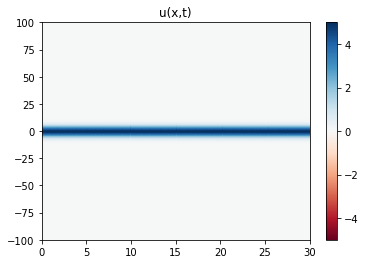

<ipython-input-44-f8f2665dde87>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, Exact_v, cmap='RdBu', vmin=v_min, vmax=v_max)


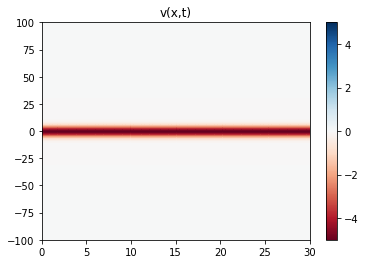

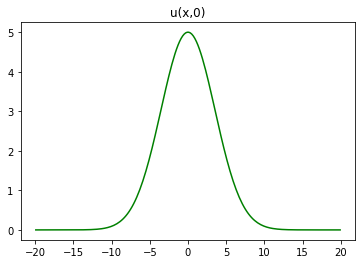

In [44]:
fig, ax = plt.subplots()
u_min, u_max = -np.abs(Exact_u).max(), np.abs(Exact_u).max()
c = ax.pcolormesh(T, X, Exact_u, cmap='RdBu', vmin=u_min, vmax=u_max)
ax.set_title('u(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
plt.show()

fig, ax = plt.subplots()
v_min, v_max = -np.abs(Exact_v).max(), np.abs(Exact_v).max()
c = ax.pcolormesh(T, X, Exact_v, cmap='RdBu', vmin=v_min, vmax=v_max)
ax.set_title('v(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
plt.show()

plt.plot(X[0, 400:600], Exact_u[0,400:600], color = "green")
plt.title('u(x,0)')
plt.show()

Обучение

In [45]:
model = PhysicsInformedNN(X_uv_train, u_train, v_train, X_f_train, layers, lb, ub, alpha, beta)

In [46]:
%%time
#штука сверху выведет итоговое время выполнения
model.train()

training started
30000 iterations of ADAM:
Iter 1000, Loss: 3.20875e-01, Loss_uv: 2.69761e-01, Loss_f: 5.11142e-02
Iter 2000, Loss: 3.95333e-01, Loss_uv: 3.58708e-01, Loss_f: 3.66252e-02
Iter 3000, Loss: 3.54343e-01, Loss_uv: 3.17367e-01, Loss_f: 3.69763e-02
Iter 4000, Loss: 3.48198e-01, Loss_uv: 3.08561e-01, Loss_f: 3.96371e-02
Iter 5000, Loss: 3.31115e-01, Loss_uv: 3.07068e-01, Loss_f: 2.40474e-02
Iter 6000, Loss: 3.73885e-01, Loss_uv: 3.40905e-01, Loss_f: 3.29793e-02
Iter 7000, Loss: 2.82614e-01, Loss_uv: 2.56306e-01, Loss_f: 2.63079e-02
Iter 8000, Loss: 3.84670e-01, Loss_uv: 3.51799e-01, Loss_f: 3.28716e-02
Iter 9000, Loss: 3.75838e-01, Loss_uv: 3.52680e-01, Loss_f: 2.31576e-02
Iter 10000, Loss: 2.89184e-01, Loss_uv: 2.72206e-01, Loss_f: 1.69779e-02
Iter 11000, Loss: 3.05000e-01, Loss_uv: 2.80445e-01, Loss_f: 2.45548e-02
Iter 12000, Loss: 3.79638e-01, Loss_uv: 3.56472e-01, Loss_f: 2.31653e-02
Iter 13000, Loss: 3.42309e-01, Loss_uv: 3.14748e-01, Loss_f: 2.75618e-02
Iter 14000, Loss:

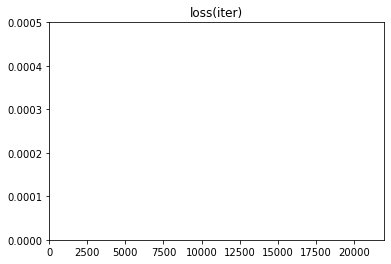

In [47]:
import matplotlib.pyplot as plt
plt.plot(np.array(iter_array)[::10], np.array(loss_array)[::10], color = "blue")
plt.ylim(0,5e-4)
plt.title('loss(iter)')
plt.show()

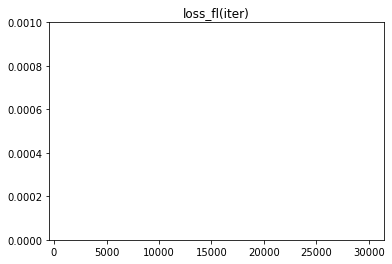

In [48]:
plt.plot(np.array(iter_array), np.array(loss_fl_array), color = "blue")
plt.ylim(0,1e-3)
plt.title('loss_fl(iter)')
plt.show()

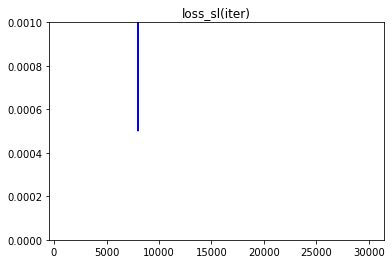

In [49]:
plt.plot(np.array(iter_array), np.array(loss_sl_array), color = "blue")
plt.ylim(0,1e-3)
plt.title('loss_sl(iter)')
plt.show()

In [50]:
u_pred, v_pred, f_u_pred, f_v_pred = model.predict(X_star) #можно ради интереса сравнить с суммой дух решений, которая строго говоря не является решением(но именно от неё и берутся начальные условия)
mse_u = ((u_star-u_pred)**2).mean(axis=0).item()
mse_v = ((v_star-v_pred)**2).mean(axis=0).item()
mse_q = (((u_star**2+v_star**2)**0.5 - (u_pred**2+v_pred**2)**0.5)**2).mean(axis=0).item() #средний квадрат разности модулей
mse_f_u = ((f_u_pred)**2).mean(axis=0).item()
mse_f_v = ((f_v_pred)**2).mean(axis=0).item()
print('MSE_u: %e, MSE_v: %e, MSE_q: %e' %(mse_u, mse_v, mse_q))
print('MSE_f_u: %e, MSE_f_v: %e' %(mse_f_u, mse_f_v))

MSE_u: 7.716635e-01, MSE_v: 7.681645e-01, MSE_q: 1.538757e+00
MSE_f_u: 4.167099e-01, MSE_f_v: 2.456522e-01


Визуализация

Что выдала нейросеть:

<ipython-input-51-c42e7cd87c3e>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, u_pred.reshape((t_parts, x_parts)), cmap='RdBu', vmin=u_min, vmax=u_max)


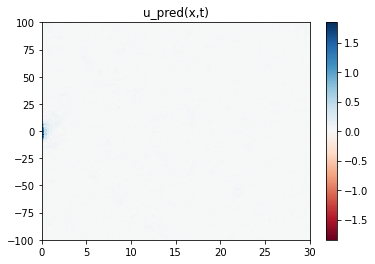

<ipython-input-51-c42e7cd87c3e>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, v_pred.reshape((t_parts, x_parts)), cmap='RdBu', vmin=v_min, vmax=v_max)


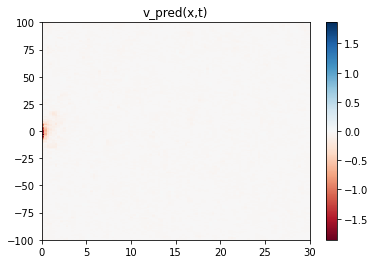

In [51]:
fig, ax = plt.subplots()
u_min, u_max = -np.abs(u_pred).max(), np.abs(u_pred).max()
c = ax.pcolormesh(T, X, u_pred.reshape((t_parts, x_parts)), cmap='RdBu', vmin=u_min, vmax=u_max)
ax.set_title('u_pred(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
#plt.scatter(X_uv_train[:,1], X_uv_train[:,0], s=7, color='black')
#plt.scatter(X_f_train[:,1], X_f_train[:,0], s=3, color='black', alpha=0.3)
plt.show()

fig, ax = plt.subplots()
v_min, v_max = -np.abs(v_pred).max(), np.abs(v_pred).max()
c = ax.pcolormesh(T, X, v_pred.reshape((t_parts, x_parts)), cmap='RdBu', vmin=v_min, vmax=v_max)
ax.set_title('v_pred(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
plt.show()

Что должно быть в теории:

<ipython-input-52-3c5c3b734f9c>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, Exact_u, cmap='RdBu', vmin=u_min, vmax=u_max)


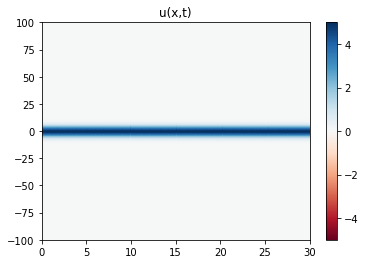

<ipython-input-52-3c5c3b734f9c>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, Exact_v, cmap='RdBu', vmin=v_min, vmax=v_max)


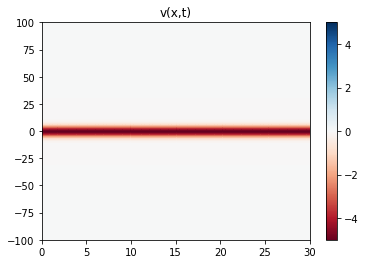

In [52]:
fig, ax = plt.subplots()
u_min, u_max = -np.abs(Exact_u).max(), np.abs(Exact_u).max()
c = ax.pcolormesh(T, X, Exact_u, cmap='RdBu', vmin=u_min, vmax=u_max)
ax.set_title('u(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
plt.show()

fig, ax = plt.subplots()
v_min, v_max = -np.abs(Exact_v).max(), np.abs(Exact_v).max()
c = ax.pcolormesh(T, X, Exact_v, cmap='RdBu', vmin=v_min, vmax=v_max)
ax.set_title('v(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
plt.show()

Решение в срезах по t:

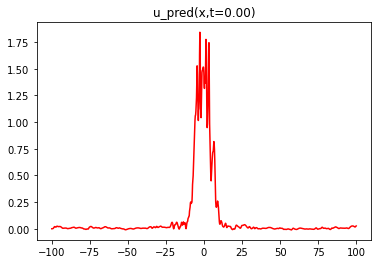

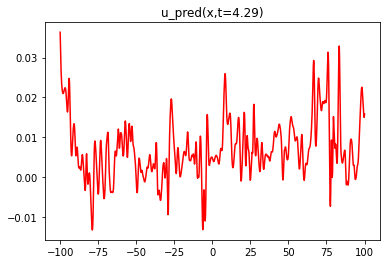

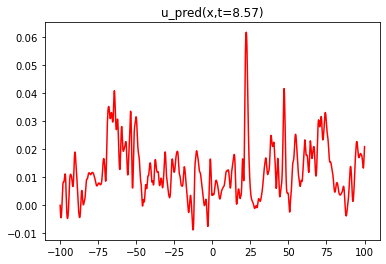

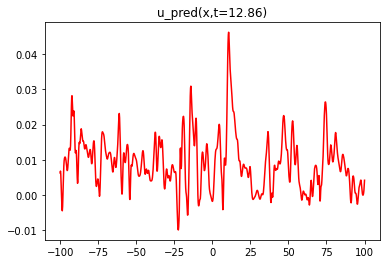

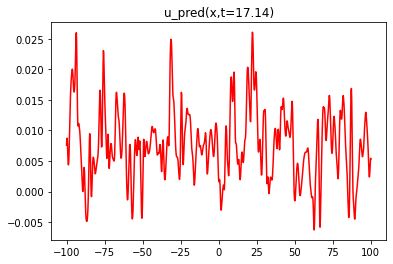

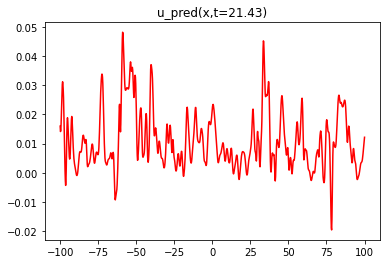

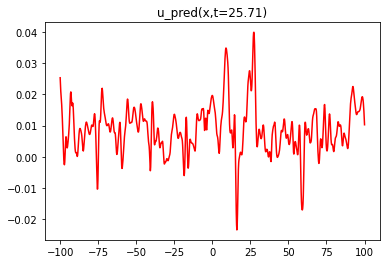

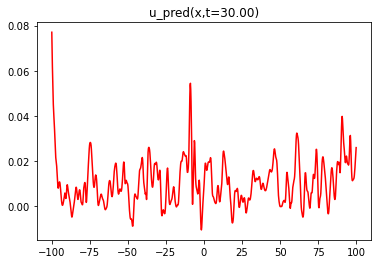

In [53]:
t=t_0
while t<=t_1:
  current_row = int(t_parts*(t-t_0)/(t_1-t_0))
  if t==t_1: current_row=-1 #если смотрим значения в t_1, то ясно что это последняя колонка
  plt.plot(X[current_row, :], u_pred.reshape((t_parts, x_parts))[current_row,:], color = "red") #предсказанное решение
  #plt.plot(X[current_row, :], Exact_u[current_row,:], color = "green")
  plt.title('u_pred(x,t=%.2f)'%t)
  plt.show()
  t+=abs(t_1-t_0)/7

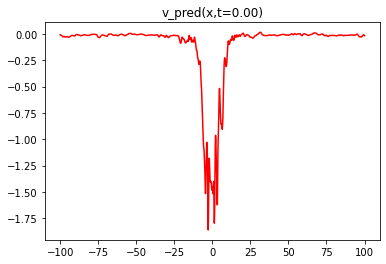

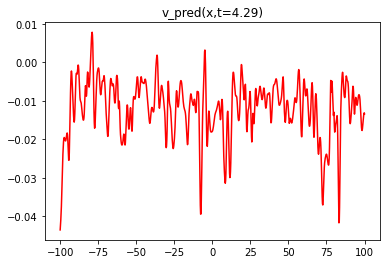

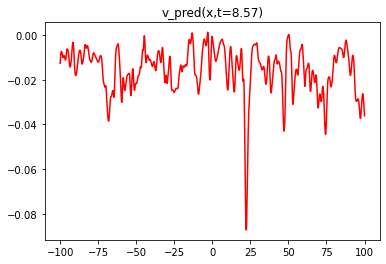

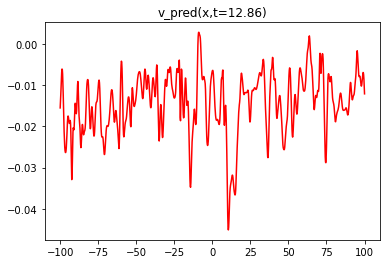

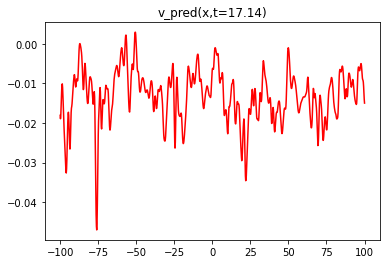

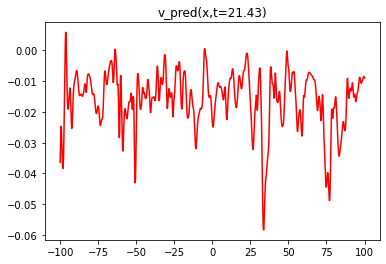

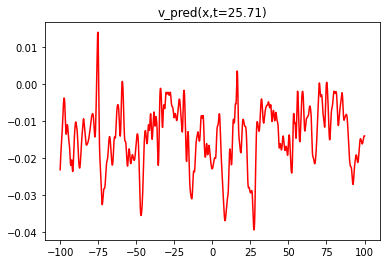

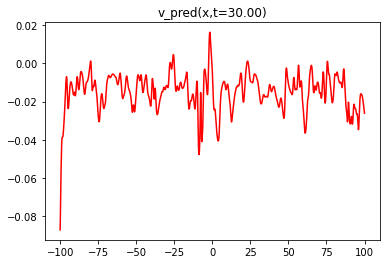

In [54]:
t=t_0
while t<=t_1:
  current_row = int(t_parts*(t-t_0)/(t_1-t_0))
  if t==t_1: current_row=-1 #если смотрим значения в t_1, то ясно что это последняя колонка
  plt.plot(X[current_row, :], v_pred.reshape((t_parts, x_parts))[current_row,:], color = "red")
  #plt.plot(X[current_row, :], Exact_v[current_row,:], color = "green")
  plt.title('v_pred(x,t=%.2f)'%t)
  plt.show()
  t+=abs(t_1-t_0)/7

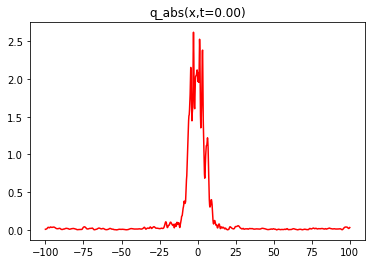

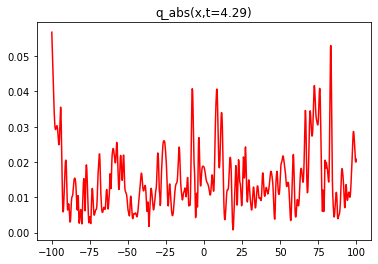

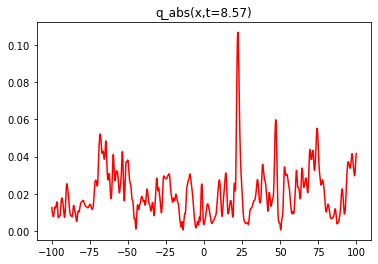

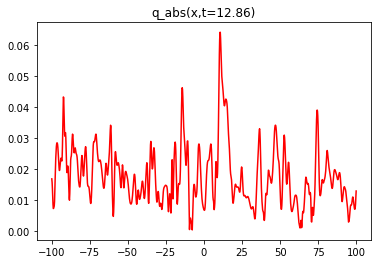

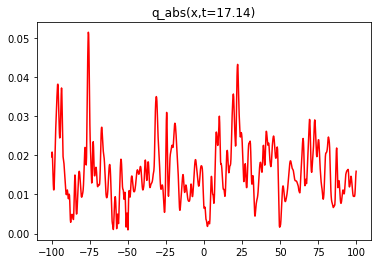

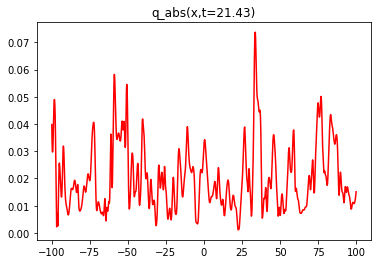

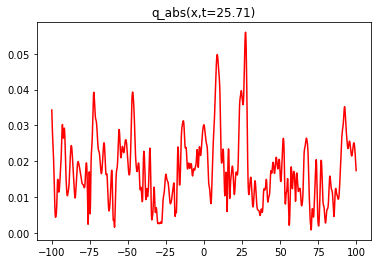

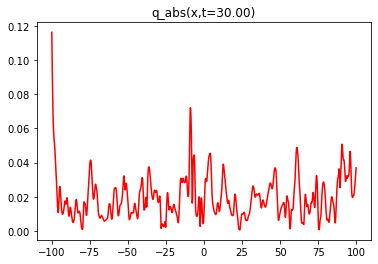

In [55]:
t=t_0
while t<=t_1:
  current_row = int(t_parts*(t-t_0)/(t_1-t_0))
  if t==t_1: current_row=-1 #если смотрим значения в t_1, то ясно что это последняя колонка
  q_abs_pred = (u_pred.reshape((t_parts, x_parts))[current_row,:]**2 + v_pred.reshape((t_parts, x_parts))[current_row,:]**2)**0.5
  q_abs_exact = (Exact_u[current_row,:]**2 + Exact_v[current_row,:]**2)**0.5
  plt.plot(X[current_row, :], q_abs_pred, color = "red")
  #plt.plot(X[current_row, :], q_abs_exact, color = "green")
  plt.title('q_abs(x,t=%.2f)'%t)
  plt.show()
  t+=abs(t_1-t_0)/7

Точность выполнения условий уравнения:

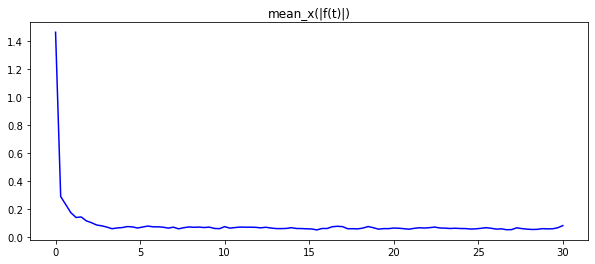

Mean_xt(|f|): 8.368094e-02


In [56]:
loss_abs_f = (f_u_pred**2 + f_v_pred**2)**0.5 #тензор модулей значений уравнения
loss_abs_f_array=[]
t_array=[]
for t in np.linspace(t_0, t_1, 100):
  current_row = int(t_parts*(t-t_0)/(t_1-t_0))
  if t==t_1: current_row=-1 #если смотрим значения в t_1, то ясно что это последняя колонка
  loss_abs_f_array.append(loss_abs_f.reshape((t_parts, x_parts))[current_row,:].mean())
  t_array.append(t)
plt.figure(figsize=(10,4))
plt.plot(t_array, loss_abs_f_array, color = "blue")
plt.title('mean_x(|f(t)|)') #среднее значение модуля функции на срезе при фиксированном t
plt.show()
print('Mean_xt(|f|): %e' %loss_abs_f.mean(axis=0).item()) #среднее значение модуля функции на всей сетке

Проверка законов сохранения:

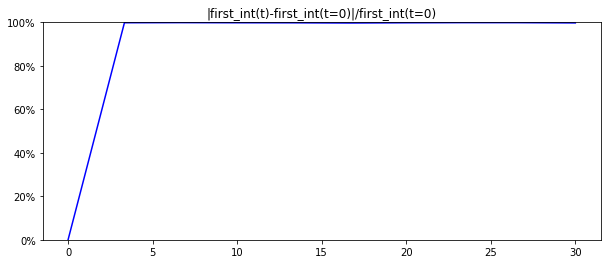

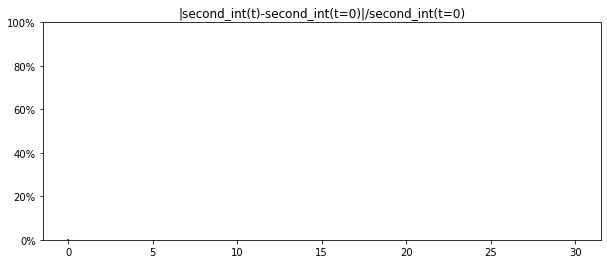

First law MSE: 1.607172e+03, Second law MSE: 4.226165e-02
First law mean: 3.803228e+01, Second law mean: 1.950266e-01


In [57]:
import matplotlib.ticker as mtick
x_fragments = 400 #разбиение при интегрировании по x при фиксированном t
t_amount = 10 #в скольких точках t считается интеграл
x_l = np.linspace(x_0, x_1, x_fragments).reshape(x_fragments,1)
t_l = np.linspace(t_0, t_1, t_amount).reshape(t_amount,1)
X_l = torch.tensor(x_l, requires_grad=True).float().to(device)
T_l = torch.tensor(t_l, requires_grad=True).float().to(device)
x_step=(X_l[1]-X_l[0]).item()

#реализация первого закона сохранения
u, v = model.net_uv(X_l, torch.full((x_fragments,1),T_l[0:1].item(), requires_grad=True).float().to(device))
initial_integral = ((u**2 + v**2) * x_step).sum() #вычисляем интеграл в t_0
u, v = model.net_uv(X_l.expand(x_fragments, t_amount).T.reshape(x_fragments*t_amount,1), T_l.expand(t_amount, x_fragments).reshape(x_fragments*t_amount,1))
first_variation = (((u.reshape(t_amount, x_fragments)**2 + v.reshape(t_amount, x_fragments)**2) * x_step).sum(axis=1) - initial_integral)**2 #вычисляем интегралы при других t и находим отклонение
first_variation = first_variation.detach()
MSE_fl = first_variation.mean(axis=0).item() #возвращаем средний квадрат отклонения
mean_fl = (first_variation**0.5).mean(axis=0).item() #а также средний модуль отклонения
plt.figure(figsize=(10,4))
plt.plot(t_l, (first_variation**0.5/initial_integral).detach().cpu(), color = "blue") #строим график соблюдения первого закона сохранения(чем ближе к 0, тем лучше)
plt.title('|first_int(t)-first_int(t=0)|/first_int(t=0)')
plt.ylim(0,1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0)) #меняем числа на проценты
plt.show()

#реализация второго закона сохранения
u, v = model.net_uv(X_l, torch.full((x_fragments,1),T_l[0:1].item(), requires_grad=True).float().to(device))
u_x = torch.autograd.grad(u, X_l, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
v_x = torch.autograd.grad(v, X_l, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
initial_integral = ((v_x*u - u_x*v) * x_step).sum() #вычисляем интеграл в t_0
X_l_expanded = X_l.expand(x_fragments, t_amount).T.reshape(x_fragments*t_amount,1)
T_l_expanded = T_l.expand(t_amount, x_fragments).reshape(x_fragments*t_amount,1)
u, v = model.net_uv(X_l_expanded, T_l_expanded)
u_x = torch.autograd.grad(u, X_l_expanded, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
v_x = torch.autograd.grad(v, X_l_expanded, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
second_variation = ((((v_x*u).reshape(t_amount, x_fragments) - (u_x*v).reshape(t_amount, x_fragments)) * x_step).sum(axis=1) - initial_integral)**2 #вычисляем интегралы при других t и находим отклонение
second_variation = second_variation.detach()
MSE_sl = second_variation.mean(axis=0).item() #возвращаем средний квадрат отклонения
mean_sl = (second_variation**0.5).mean(axis=0).item() #а также средний модуль отклонения
plt.figure(figsize=(10,4))
plt.plot(t_l, (second_variation**0.5/initial_integral).detach().cpu(), color = "blue") #строим график соблюдения первого закона сохранения(чем ближе к 0, тем лучше)
plt.title('|second_int(t)-second_int(t=0)|/second_int(t=0)')
plt.ylim(0,1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.show()

print('First law MSE: %e, Second law MSE: %e' %(MSE_fl, MSE_sl))
print('First law mean: %e, Second law mean: %e' %(mean_fl, mean_sl)) #среднее значение модуля отклонения интеграла от первоначального значения

###$q(x,0)=e^{ikx}e^{-\frac{x}{2}^2}$

In [58]:
def q(x,t):
  f_com = np.exp(-(x/2)**2)
  u = f_com*np.cos(k*x)
  v = f_com*np.sin(k*x)
  return u, v

In [59]:
Exact_u=q(X,T)[0]
Exact_v=q(X,T)[1]

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact_u.flatten()[:,None]
v_star = Exact_v.flatten()[:,None]

# границы области
lb = X_star.min(0)
ub = X_star.max(0)

# для обучения берём только данные на границах области(граничные условия по сути)
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T)) #(x,t_0)
uu1 = Exact_u[0:1,:].T
vv1 = Exact_v[0:1,:].T
xx2 = np.hstack((X[:,0:1], T[:,0:1])) #(x_0,t)
uu2 = np.zeros((t_parts,1)) #граничные условия поставил 0 в соответствии с требованиями
vv2 = np.zeros((t_parts,1))
xx3 = np.hstack((X[:,-1:], T[:,-1:])) #(x_1,t)
uu3 = np.zeros((t_parts,1)) #тут тоже
vv3 = np.zeros((t_parts,1))

X_uv_train = np.vstack([xx1, xx2, xx3]) #данные для тренировки в точках на границе
u_train = np.vstack([uu1, uu2, uu3])
v_train = np.vstack([vv1, vv2, vv3])
X_f_train = lb + (ub-lb)*lhs(2, N_f) #данные для тренировки в случайных точкам из области
X_f_train = np.vstack((X_f_train, X_uv_train)) #добавим к ним ещё и точки на границе, там f тоже 0

idx = np.random.choice(X_uv_train.shape[0], N_u, replace=False) #выберем из точек на границе только N_u
X_uv_train = X_uv_train[idx, :]
u_train = u_train[idx,:]
v_train = v_train[idx,:]

loss_array = [] #массив с loss в процессе обучения
loss_fl_array = [] #массивы с loss_fl и loss_sl
loss_sl_array = []
iter_array = [] #итерации с шагом 100

вот как оно выглядит:

<ipython-input-60-7f685e9cbbaf>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, Exact_u, cmap='RdBu', vmin=u_min, vmax=u_max)


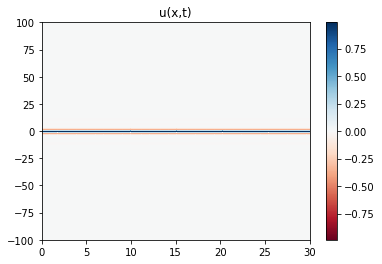

<ipython-input-60-7f685e9cbbaf>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, Exact_v, cmap='RdBu', vmin=v_min, vmax=v_max)


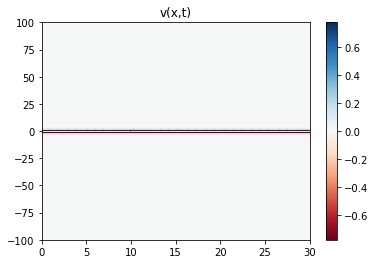

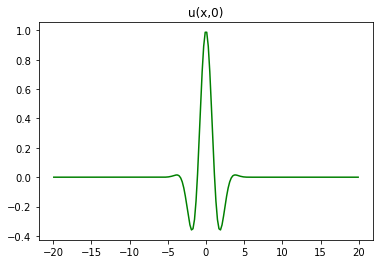

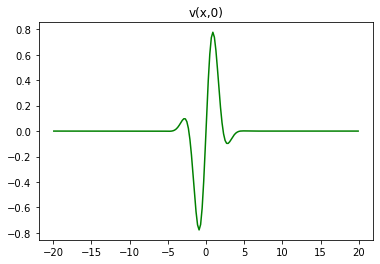

In [60]:
fig, ax = plt.subplots()
u_min, u_max = -np.abs(Exact_u).max(), np.abs(Exact_u).max()
c = ax.pcolormesh(T, X, Exact_u, cmap='RdBu', vmin=u_min, vmax=u_max)
ax.set_title('u(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
plt.show()

fig, ax = plt.subplots()
v_min, v_max = -np.abs(Exact_v).max(), np.abs(Exact_v).max()
c = ax.pcolormesh(T, X, Exact_v, cmap='RdBu', vmin=v_min, vmax=v_max)
ax.set_title('v(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
plt.show()

plt.plot(X[0, 400:600], Exact_u[0,400:600], color = "green")
plt.title('u(x,0)')
plt.show()

plt.plot(X[0, 400:600], Exact_v[0,400:600], color = "green")
plt.title('v(x,0)')
plt.show()

Обучение

In [61]:
model = PhysicsInformedNN(X_uv_train, u_train, v_train, X_f_train, layers, lb, ub, alpha, beta)

In [62]:
%%time
#штука сверху выведет итоговое время выполнения
model.train()

training started
30000 iterations of ADAM:
Iter 1000, Loss: 4.32206e-05, Loss_uv: 3.19990e-06, Loss_f: 4.00207e-05
Iter 2000, Loss: 2.34921e-05, Loss_uv: 6.09954e-07, Loss_f: 2.28822e-05
Iter 3000, Loss: 1.72622e-05, Loss_uv: 5.30604e-07, Loss_f: 1.67316e-05
Iter 4000, Loss: 1.41197e-05, Loss_uv: 5.70533e-07, Loss_f: 1.35492e-05
Iter 5000, Loss: 1.00364e-05, Loss_uv: 1.21566e-06, Loss_f: 8.82076e-06
Iter 6000, Loss: 7.10816e-06, Loss_uv: 4.14712e-07, Loss_f: 6.69345e-06
Iter 7000, Loss: 7.32290e-06, Loss_uv: 1.02666e-06, Loss_f: 6.29623e-06
Iter 8000, Loss: 6.13715e-06, Loss_uv: 1.61156e-06, Loss_f: 4.52559e-06
Iter 9000, Loss: 4.41851e-06, Loss_uv: 2.35282e-07, Loss_f: 4.18322e-06
Iter 10000, Loss: 2.99448e-06, Loss_uv: 1.59247e-07, Loss_f: 2.83523e-06
Iter 11000, Loss: 7.27810e-06, Loss_uv: 1.60520e-06, Loss_f: 5.67289e-06
Iter 12000, Loss: 3.23580e-06, Loss_uv: 1.28184e-07, Loss_f: 3.10762e-06
Iter 13000, Loss: 1.66887e-05, Loss_uv: 1.84697e-06, Loss_f: 1.48417e-05
Iter 14000, Loss:

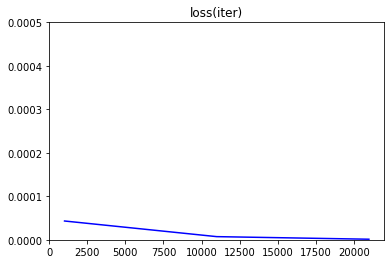

In [63]:
import matplotlib.pyplot as plt
plt.plot(np.array(iter_array)[::10], np.array(loss_array)[::10], color = "blue")
plt.ylim(0,5e-4)
plt.title('loss(iter)')
plt.show()

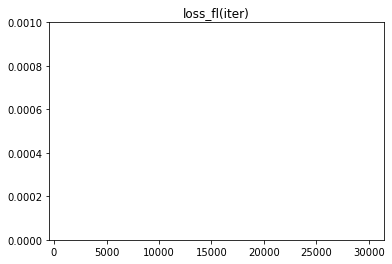

In [64]:
plt.plot(np.array(iter_array), np.array(loss_fl_array), color = "blue")
plt.ylim(0,1e-3)
plt.title('loss_fl(iter)')
plt.show()

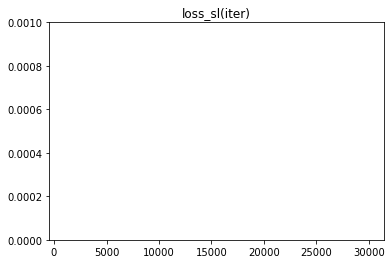

In [65]:
plt.plot(np.array(iter_array), np.array(loss_sl_array), color = "blue")
plt.ylim(0,1e-3)
plt.title('loss_sl(iter)')
plt.show()

In [66]:
u_pred, v_pred, f_u_pred, f_v_pred = model.predict(X_star) #можно ради интереса сравнить с суммой дух решений, которая строго говоря не является решением(но именно от неё и берутся начальные условия)
mse_u = ((u_star-u_pred)**2).mean(axis=0).item()
mse_v = ((v_star-v_pred)**2).mean(axis=0).item()
mse_q = (((u_star**2+v_star**2)**0.5 - (u_pred**2+v_pred**2)**0.5)**2).mean(axis=0).item() #средний квадрат разности модулей
mse_f_u = ((f_u_pred)**2).mean(axis=0).item()
mse_f_v = ((f_v_pred)**2).mean(axis=0).item()
print('MSE_u: %e, MSE_v: %e, MSE_q: %e' %(mse_u, mse_v, mse_q))
print('MSE_f_u: %e, MSE_f_v: %e' %(mse_f_u, mse_f_v))

MSE_u: 1.236303e-02, MSE_v: 1.220762e-02, MSE_q: 2.292780e-02
MSE_f_u: 2.993682e-06, MSE_f_v: 1.770187e-06


Визуализация

Что выдала нейросеть:

<ipython-input-67-c42e7cd87c3e>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, u_pred.reshape((t_parts, x_parts)), cmap='RdBu', vmin=u_min, vmax=u_max)


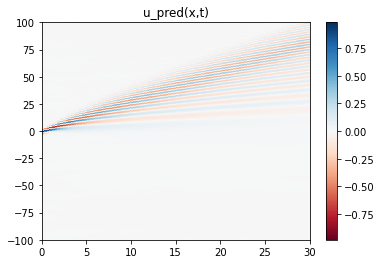

<ipython-input-67-c42e7cd87c3e>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, v_pred.reshape((t_parts, x_parts)), cmap='RdBu', vmin=v_min, vmax=v_max)


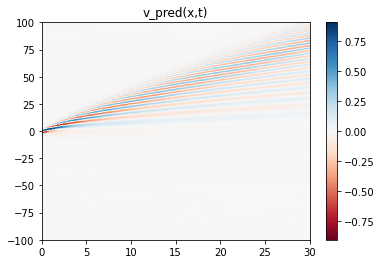

In [67]:
fig, ax = plt.subplots()
u_min, u_max = -np.abs(u_pred).max(), np.abs(u_pred).max()
c = ax.pcolormesh(T, X, u_pred.reshape((t_parts, x_parts)), cmap='RdBu', vmin=u_min, vmax=u_max)
ax.set_title('u_pred(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
#plt.scatter(X_uv_train[:,1], X_uv_train[:,0], s=7, color='black')
#plt.scatter(X_f_train[:,1], X_f_train[:,0], s=3, color='black', alpha=0.3)
plt.show()

fig, ax = plt.subplots()
v_min, v_max = -np.abs(v_pred).max(), np.abs(v_pred).max()
c = ax.pcolormesh(T, X, v_pred.reshape((t_parts, x_parts)), cmap='RdBu', vmin=v_min, vmax=v_max)
ax.set_title('v_pred(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
plt.show()

Что должно быть в теории:

<ipython-input-68-3c5c3b734f9c>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, Exact_u, cmap='RdBu', vmin=u_min, vmax=u_max)


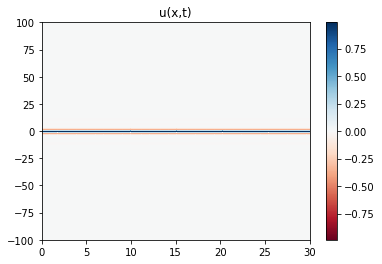

<ipython-input-68-3c5c3b734f9c>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, Exact_v, cmap='RdBu', vmin=v_min, vmax=v_max)


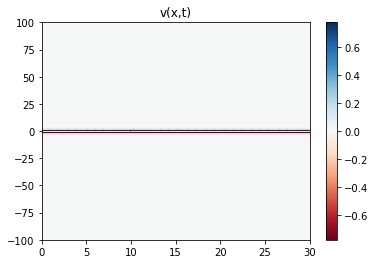

In [68]:
fig, ax = plt.subplots()
u_min, u_max = -np.abs(Exact_u).max(), np.abs(Exact_u).max()
c = ax.pcolormesh(T, X, Exact_u, cmap='RdBu', vmin=u_min, vmax=u_max)
ax.set_title('u(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
plt.show()

fig, ax = plt.subplots()
v_min, v_max = -np.abs(Exact_v).max(), np.abs(Exact_v).max()
c = ax.pcolormesh(T, X, Exact_v, cmap='RdBu', vmin=v_min, vmax=v_max)
ax.set_title('v(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
plt.show()

Решение в срезах по t:

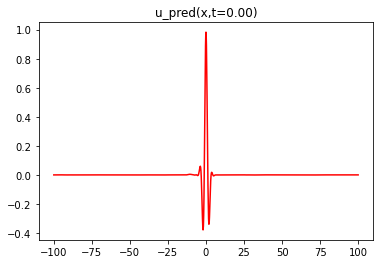

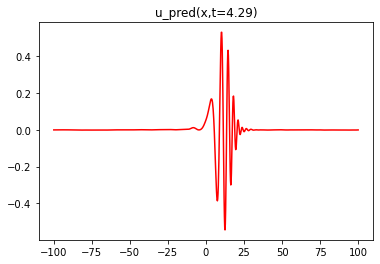

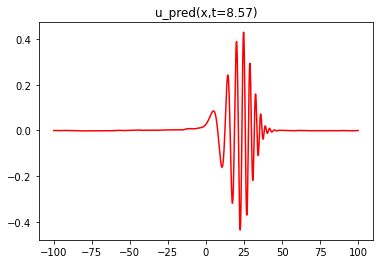

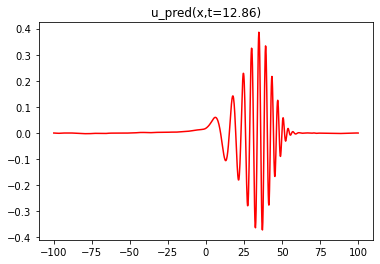

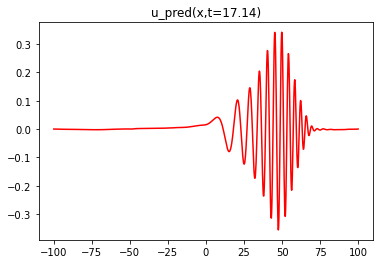

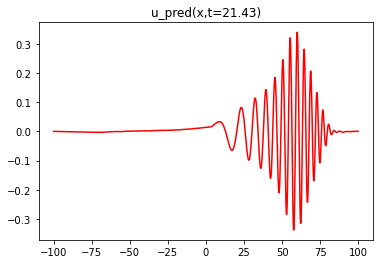

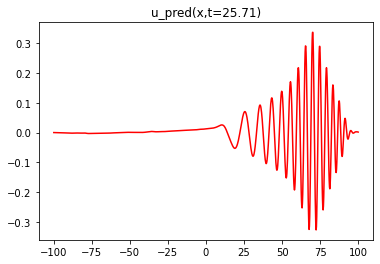

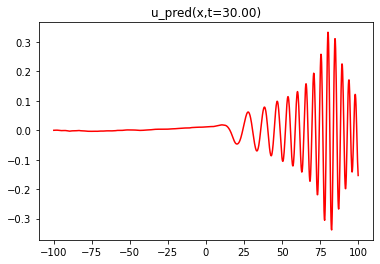

In [69]:
t=t_0
while t<=t_1:
  current_row = int(t_parts*(t-t_0)/(t_1-t_0))
  if t==t_1: current_row=-1 #если смотрим значения в t_1, то ясно что это последняя колонка
  plt.plot(X[current_row, :], u_pred.reshape((t_parts, x_parts))[current_row,:], color = "red") #предсказанное решение
  #plt.plot(X[current_row, :], Exact_u[current_row,:], color = "green")
  plt.title('u_pred(x,t=%.2f)'%t)
  plt.show()
  t+=abs(t_1-t_0)/7

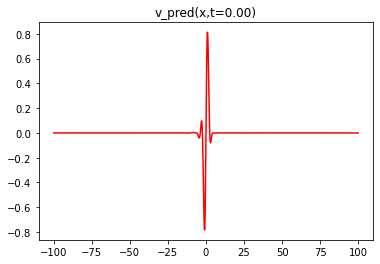

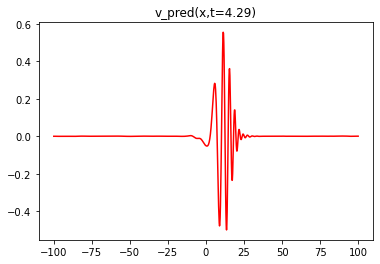

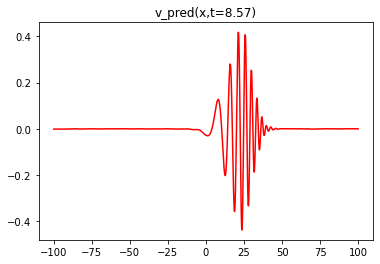

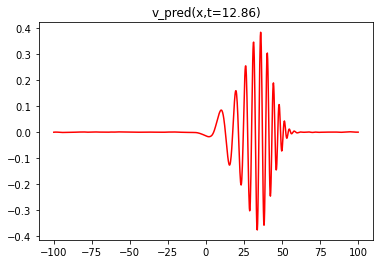

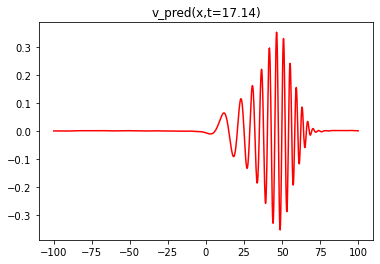

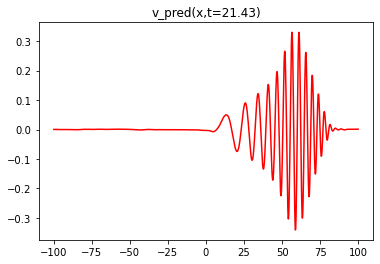

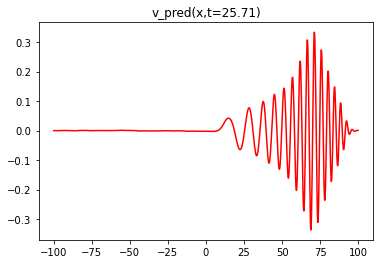

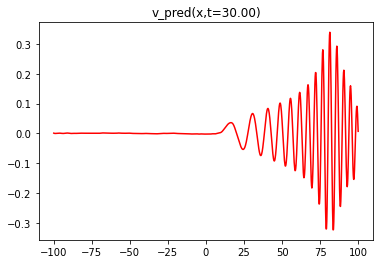

In [70]:
t=t_0
while t<=t_1:
  current_row = int(t_parts*(t-t_0)/(t_1-t_0))
  if t==t_1: current_row=-1 #если смотрим значения в t_1, то ясно что это последняя колонка
  plt.plot(X[current_row, :], v_pred.reshape((t_parts, x_parts))[current_row,:], color = "red")
  #plt.plot(X[current_row, :], Exact_v[current_row,:], color = "green")
  plt.title('v_pred(x,t=%.2f)'%t)
  plt.show()
  t+=abs(t_1-t_0)/7

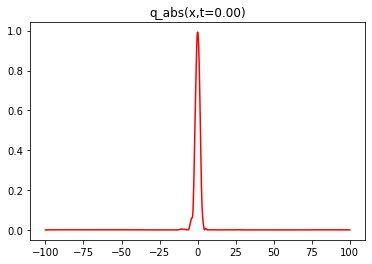

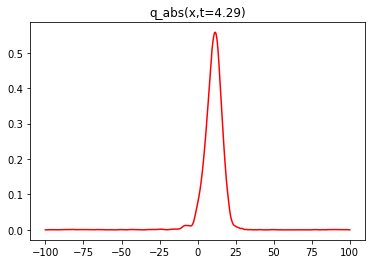

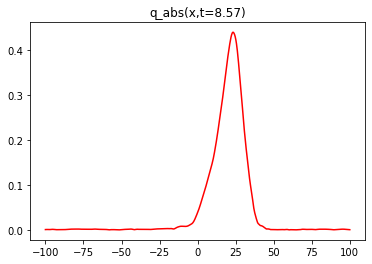

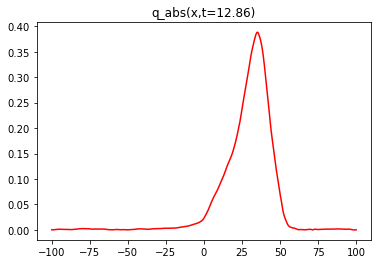

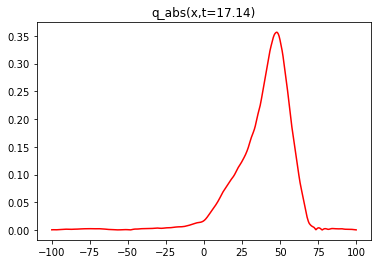

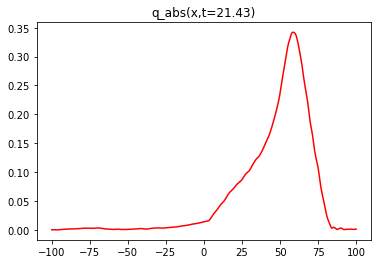

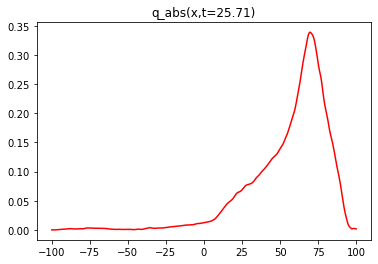

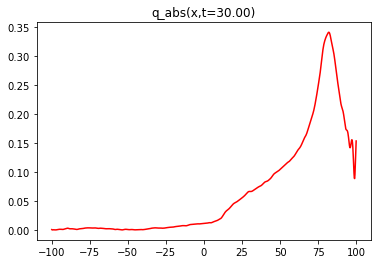

In [71]:
t=t_0
while t<=t_1:
  current_row = int(t_parts*(t-t_0)/(t_1-t_0))
  if t==t_1: current_row=-1 #если смотрим значения в t_1, то ясно что это последняя колонка
  q_abs_pred = (u_pred.reshape((t_parts, x_parts))[current_row,:]**2 + v_pred.reshape((t_parts, x_parts))[current_row,:]**2)**0.5
  q_abs_exact = (Exact_u[current_row,:]**2 + Exact_v[current_row,:]**2)**0.5
  plt.plot(X[current_row, :], q_abs_pred, color = "red")
  #plt.plot(X[current_row, :], q_abs_exact, color = "green")
  plt.title('q_abs(x,t=%.2f)'%t)
  plt.show()
  t+=abs(t_1-t_0)/7

Точность выполнения условий уравнения:

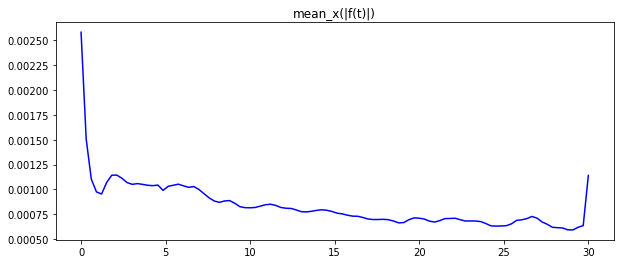

Mean_xt(|f|): 8.331254e-04


In [72]:
loss_abs_f = (f_u_pred**2 + f_v_pred**2)**0.5 #тензор модулей значений уравнения
loss_abs_f_array=[]
t_array=[]
for t in np.linspace(t_0, t_1, 100):
  current_row = int(t_parts*(t-t_0)/(t_1-t_0))
  if t==t_1: current_row=-1 #если смотрим значения в t_1, то ясно что это последняя колонка
  loss_abs_f_array.append(loss_abs_f.reshape((t_parts, x_parts))[current_row,:].mean())
  t_array.append(t)
plt.figure(figsize=(10,4))
plt.plot(t_array, loss_abs_f_array, color = "blue")
plt.title('mean_x(|f(t)|)') #среднее значение модуля функции на срезе при фиксированном t
plt.show()
print('Mean_xt(|f|): %e' %loss_abs_f.mean(axis=0).item()) #среднее значение модуля функции на всей сетке

Проверка законов сохранения:

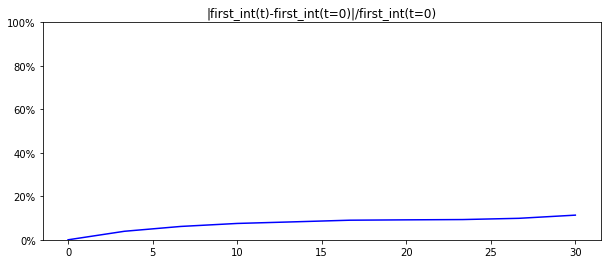

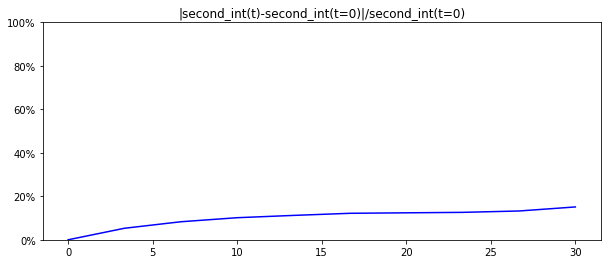

First law MSE: 4.847005e-02, Second law MSE: 1.537698e-01
First law mean: 2.026459e-01, Second law mean: 3.612083e-01


In [73]:
import matplotlib.ticker as mtick
x_fragments = 400 #разбиение при интегрировании по x при фиксированном t
t_amount = 10 #в скольких точках t считается интеграл
x_l = np.linspace(x_0, x_1, x_fragments).reshape(x_fragments,1)
t_l = np.linspace(t_0, t_1, t_amount).reshape(t_amount,1)
X_l = torch.tensor(x_l, requires_grad=True).float().to(device)
T_l = torch.tensor(t_l, requires_grad=True).float().to(device)
x_step=(X_l[1]-X_l[0]).item()

#реализация первого закона сохранения
u, v = model.net_uv(X_l, torch.full((x_fragments,1),T_l[0:1].item(), requires_grad=True).float().to(device))
initial_integral = ((u**2 + v**2) * x_step).sum() #вычисляем интеграл в t_0
u, v = model.net_uv(X_l.expand(x_fragments, t_amount).T.reshape(x_fragments*t_amount,1), T_l.expand(t_amount, x_fragments).reshape(x_fragments*t_amount,1))
first_variation = (((u.reshape(t_amount, x_fragments)**2 + v.reshape(t_amount, x_fragments)**2) * x_step).sum(axis=1) - initial_integral)**2 #вычисляем интегралы при других t и находим отклонение
first_variation = first_variation.detach()
MSE_fl = first_variation.mean(axis=0).item() #возвращаем средний квадрат отклонения
mean_fl = (first_variation**0.5).mean(axis=0).item() #а также средний модуль отклонения
plt.figure(figsize=(10,4))
plt.plot(t_l, (first_variation**0.5/initial_integral).detach().cpu(), color = "blue") #строим график соблюдения первого закона сохранения(чем ближе к 0, тем лучше)
plt.title('|first_int(t)-first_int(t=0)|/first_int(t=0)')
plt.ylim(0,1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0)) #меняем числа на проценты
plt.show()

#реализация второго закона сохранения
u, v = model.net_uv(X_l, torch.full((x_fragments,1),T_l[0:1].item(), requires_grad=True).float().to(device))
u_x = torch.autograd.grad(u, X_l, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
v_x = torch.autograd.grad(v, X_l, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
initial_integral = ((v_x*u - u_x*v) * x_step).sum() #вычисляем интеграл в t_0
X_l_expanded = X_l.expand(x_fragments, t_amount).T.reshape(x_fragments*t_amount,1)
T_l_expanded = T_l.expand(t_amount, x_fragments).reshape(x_fragments*t_amount,1)
u, v = model.net_uv(X_l_expanded, T_l_expanded)
u_x = torch.autograd.grad(u, X_l_expanded, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
v_x = torch.autograd.grad(v, X_l_expanded, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
second_variation = ((((v_x*u).reshape(t_amount, x_fragments) - (u_x*v).reshape(t_amount, x_fragments)) * x_step).sum(axis=1) - initial_integral)**2 #вычисляем интегралы при других t и находим отклонение
second_variation = second_variation.detach()
MSE_sl = second_variation.mean(axis=0).item() #возвращаем средний квадрат отклонения
mean_sl = (second_variation**0.5).mean(axis=0).item() #а также средний модуль отклонения
plt.figure(figsize=(10,4))
plt.plot(t_l, (second_variation**0.5/initial_integral).detach().cpu(), color = "blue") #строим график соблюдения первого закона сохранения(чем ближе к 0, тем лучше)
plt.title('|second_int(t)-second_int(t=0)|/second_int(t=0)')
plt.ylim(0,1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.show()

print('First law MSE: %e, Second law MSE: %e' %(MSE_fl, MSE_sl))
print('First law mean: %e, Second law mean: %e' %(mean_fl, mean_sl)) #среднее значение модуля отклонения интеграла от первоначального значения

###$q(x,0)=e^{-\frac{x}{2}^2}$

In [74]:
def q(x,t):
  f_com = np.exp(-(x/2)**2)
  u = f_com
  v = 0*f_com
  return u, v

In [75]:
Exact_u=q(X,T)[0]
Exact_v=q(X,T)[1]

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact_u.flatten()[:,None]
v_star = Exact_v.flatten()[:,None]

# границы области
lb = X_star.min(0)
ub = X_star.max(0)

# для обучения берём только данные на границах области(граничные условия по сути)
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T)) #(x,t_0)
uu1 = Exact_u[0:1,:].T
vv1 = Exact_v[0:1,:].T
xx2 = np.hstack((X[:,0:1], T[:,0:1])) #(x_0,t)
uu2 = np.zeros((t_parts,1)) #граничные условия поставил 0 в соответствии с требованиями
vv2 = np.zeros((t_parts,1))
xx3 = np.hstack((X[:,-1:], T[:,-1:])) #(x_1,t)
uu3 = np.zeros((t_parts,1)) #тут тоже
vv3 = np.zeros((t_parts,1))

X_uv_train = np.vstack([xx1, xx2, xx3]) #данные для тренировки в точках на границе
u_train = np.vstack([uu1, uu2, uu3])
v_train = np.vstack([vv1, vv2, vv3])
X_f_train = lb + (ub-lb)*lhs(2, N_f) #данные для тренировки в случайных точкам из области
X_f_train = np.vstack((X_f_train, X_uv_train)) #добавим к ним ещё и точки на границе, там f тоже 0

idx = np.random.choice(X_uv_train.shape[0], N_u, replace=False) #выберем из точек на границе только N_u
X_uv_train = X_uv_train[idx, :]
u_train = u_train[idx,:]
v_train = v_train[idx,:]

loss_array = [] #массив с loss в процессе обучения
loss_fl_array = [] #массивы с loss_fl и loss_sl
loss_sl_array = []
iter_array = [] #итерации с шагом 100

вот как оно выглядит:

<ipython-input-76-f8f2665dde87>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, Exact_u, cmap='RdBu', vmin=u_min, vmax=u_max)


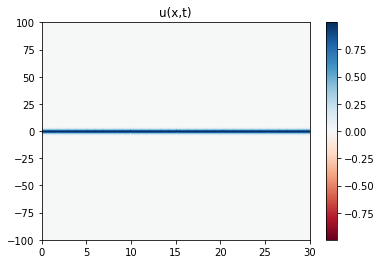

<ipython-input-76-f8f2665dde87>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, Exact_v, cmap='RdBu', vmin=v_min, vmax=v_max)


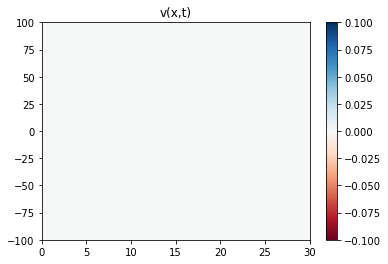

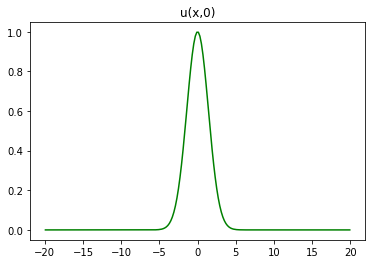

In [76]:
fig, ax = plt.subplots()
u_min, u_max = -np.abs(Exact_u).max(), np.abs(Exact_u).max()
c = ax.pcolormesh(T, X, Exact_u, cmap='RdBu', vmin=u_min, vmax=u_max)
ax.set_title('u(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
plt.show()

fig, ax = plt.subplots()
v_min, v_max = -np.abs(Exact_v).max(), np.abs(Exact_v).max()
c = ax.pcolormesh(T, X, Exact_v, cmap='RdBu', vmin=v_min, vmax=v_max)
ax.set_title('v(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
plt.show()

plt.plot(X[0, 400:600], Exact_u[0,400:600], color = "green")
plt.title('u(x,0)')
plt.show()

Обучение

In [77]:
model = PhysicsInformedNN(X_uv_train, u_train, v_train, X_f_train, layers, lb, ub, alpha, beta)

In [78]:
%%time
#штука сверху выведет итоговое время выполнения
model.train()

training started
30000 iterations of ADAM:
Iter 1000, Loss: 2.16140e-05, Loss_uv: 4.36190e-06, Loss_f: 1.72521e-05
Iter 2000, Loss: 1.09148e-05, Loss_uv: 2.42411e-06, Loss_f: 8.49072e-06
Iter 3000, Loss: 5.97435e-06, Loss_uv: 7.89539e-07, Loss_f: 5.18481e-06
Iter 4000, Loss: 4.02602e-06, Loss_uv: 8.65143e-07, Loss_f: 3.16088e-06
Iter 5000, Loss: 2.93128e-06, Loss_uv: 8.45003e-07, Loss_f: 2.08627e-06
Iter 6000, Loss: 1.77096e-06, Loss_uv: 2.56360e-07, Loss_f: 1.51460e-06
Iter 7000, Loss: 1.74466e-06, Loss_uv: 3.57417e-07, Loss_f: 1.38724e-06
Iter 8000, Loss: 1.43012e-06, Loss_uv: 3.09236e-07, Loss_f: 1.12088e-06
Iter 9000, Loss: 1.22147e-06, Loss_uv: 2.23852e-07, Loss_f: 9.97620e-07
Iter 10000, Loss: 1.36500e-06, Loss_uv: 5.30446e-07, Loss_f: 8.34549e-07
Iter 11000, Loss: 8.35774e-07, Loss_uv: 1.98873e-07, Loss_f: 6.36900e-07
Iter 12000, Loss: 3.36321e-06, Loss_uv: 2.17574e-06, Loss_f: 1.18747e-06
Iter 13000, Loss: 9.22313e-07, Loss_uv: 3.34768e-07, Loss_f: 5.87545e-07
Iter 14000, Loss:

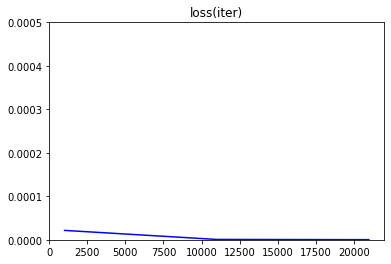

In [79]:
import matplotlib.pyplot as plt
plt.plot(np.array(iter_array)[::10], np.array(loss_array)[::10], color = "blue")
plt.ylim(0,5e-4)
plt.title('loss(iter)')
plt.show()

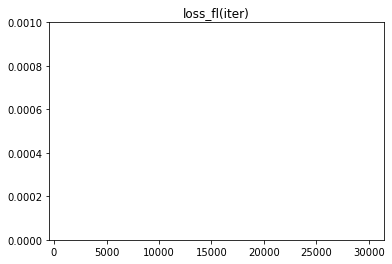

In [80]:
plt.plot(np.array(iter_array), np.array(loss_fl_array), color = "blue")
plt.ylim(0,1e-3)
plt.title('loss_fl(iter)')
plt.show()

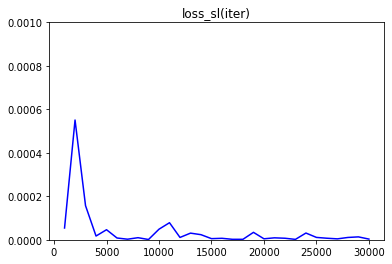

In [81]:
plt.plot(np.array(iter_array), np.array(loss_sl_array), color = "blue")
plt.ylim(0,1e-3)
plt.title('loss_sl(iter)')
plt.show()

In [82]:
u_pred, v_pred, f_u_pred, f_v_pred = model.predict(X_star) #можно ради интереса сравнить с суммой дух решений, которая строго говоря не является решением(но именно от неё и берутся начальные условия)
mse_u = ((u_star-u_pred)**2).mean(axis=0).item()
mse_v = ((v_star-v_pred)**2).mean(axis=0).item()
mse_q = (((u_star**2+v_star**2)**0.5 - (u_pred**2+v_pred**2)**0.5)**2).mean(axis=0).item() #средний квадрат разности модулей
mse_f_u = ((f_u_pred)**2).mean(axis=0).item()
mse_f_v = ((f_v_pred)**2).mean(axis=0).item()
print('MSE_u: %e, MSE_v: %e, MSE_q: %e' %(mse_u, mse_v, mse_q))
print('MSE_f_u: %e, MSE_f_v: %e' %(mse_f_u, mse_f_v))

MSE_u: 1.361721e-02, MSE_v: 5.874468e-03, MSE_q: 1.029603e-02
MSE_f_u: 2.919786e-07, MSE_f_v: 3.177147e-07


Визуализация

Что выдала нейросеть:

<ipython-input-83-c42e7cd87c3e>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, u_pred.reshape((t_parts, x_parts)), cmap='RdBu', vmin=u_min, vmax=u_max)


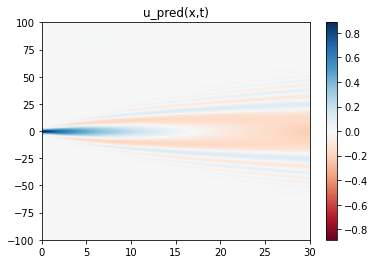

<ipython-input-83-c42e7cd87c3e>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, v_pred.reshape((t_parts, x_parts)), cmap='RdBu', vmin=v_min, vmax=v_max)


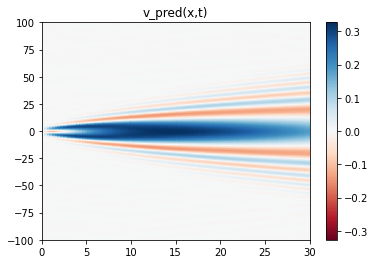

In [83]:
fig, ax = plt.subplots()
u_min, u_max = -np.abs(u_pred).max(), np.abs(u_pred).max()
c = ax.pcolormesh(T, X, u_pred.reshape((t_parts, x_parts)), cmap='RdBu', vmin=u_min, vmax=u_max)
ax.set_title('u_pred(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
#plt.scatter(X_uv_train[:,1], X_uv_train[:,0], s=7, color='black')
#plt.scatter(X_f_train[:,1], X_f_train[:,0], s=3, color='black', alpha=0.3)
plt.show()

fig, ax = plt.subplots()
v_min, v_max = -np.abs(v_pred).max(), np.abs(v_pred).max()
c = ax.pcolormesh(T, X, v_pred.reshape((t_parts, x_parts)), cmap='RdBu', vmin=v_min, vmax=v_max)
ax.set_title('v_pred(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
plt.show()

Что должно быть в теории:

<ipython-input-84-3c5c3b734f9c>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, Exact_u, cmap='RdBu', vmin=u_min, vmax=u_max)


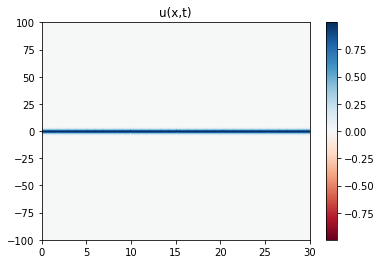

<ipython-input-84-3c5c3b734f9c>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, Exact_v, cmap='RdBu', vmin=v_min, vmax=v_max)


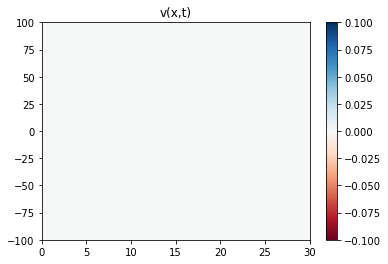

In [84]:
fig, ax = plt.subplots()
u_min, u_max = -np.abs(Exact_u).max(), np.abs(Exact_u).max()
c = ax.pcolormesh(T, X, Exact_u, cmap='RdBu', vmin=u_min, vmax=u_max)
ax.set_title('u(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
plt.show()

fig, ax = plt.subplots()
v_min, v_max = -np.abs(Exact_v).max(), np.abs(Exact_v).max()
c = ax.pcolormesh(T, X, Exact_v, cmap='RdBu', vmin=v_min, vmax=v_max)
ax.set_title('v(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
plt.show()

Решение в срезах по t:

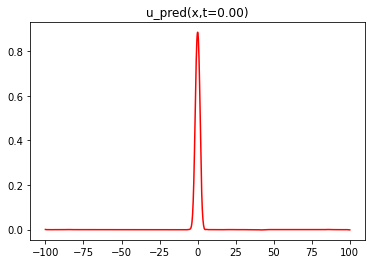

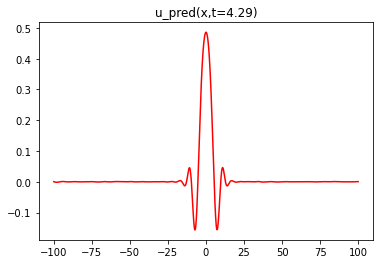

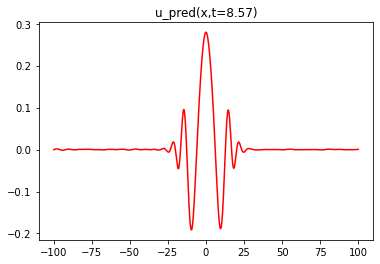

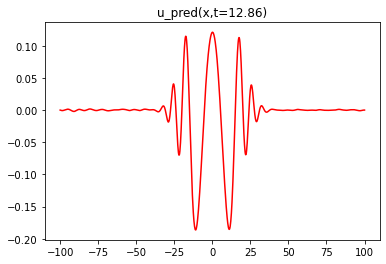

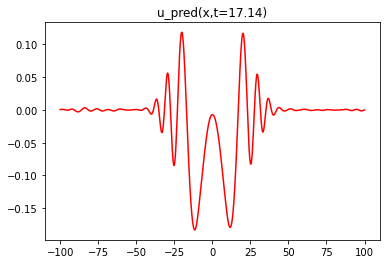

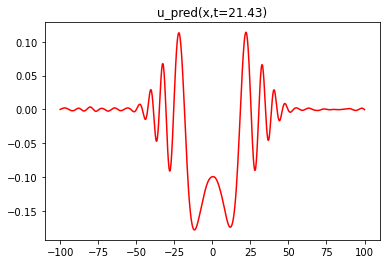

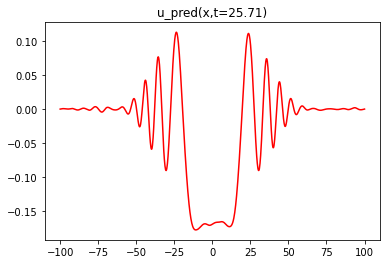

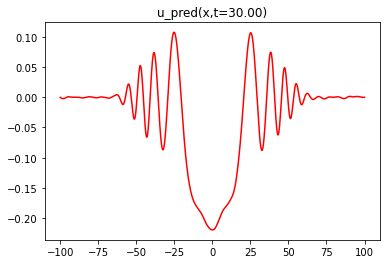

In [85]:
t=t_0
while t<=t_1:
  current_row = int(t_parts*(t-t_0)/(t_1-t_0))
  if t==t_1: current_row=-1 #если смотрим значения в t_1, то ясно что это последняя колонка
  plt.plot(X[current_row, :], u_pred.reshape((t_parts, x_parts))[current_row,:], color = "red") #предсказанное решение
  #plt.plot(X[current_row, :], Exact_u[current_row,:], color = "green")
  plt.title('u_pred(x,t=%.2f)'%t)
  plt.show()
  t+=abs(t_1-t_0)/7

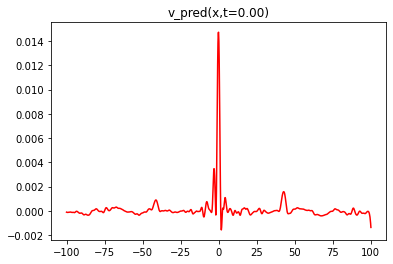

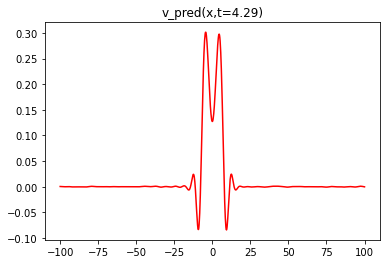

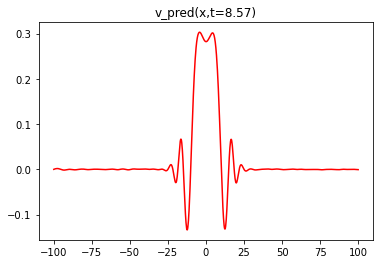

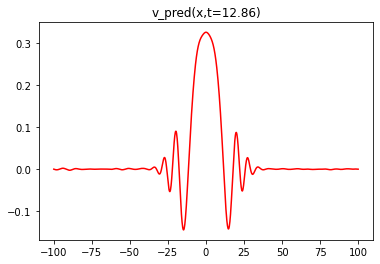

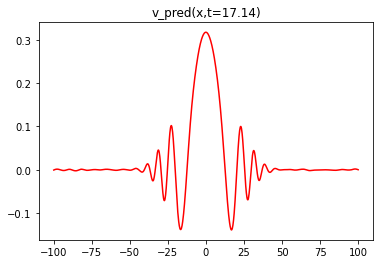

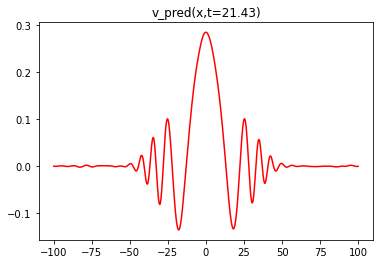

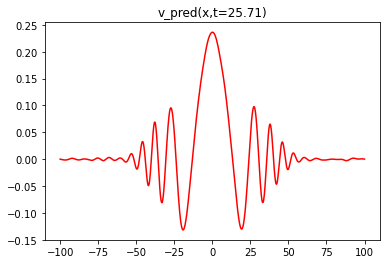

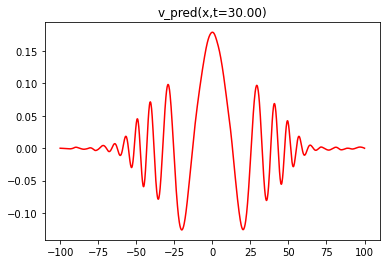

In [86]:
t=t_0
while t<=t_1:
  current_row = int(t_parts*(t-t_0)/(t_1-t_0))
  if t==t_1: current_row=-1 #если смотрим значения в t_1, то ясно что это последняя колонка
  plt.plot(X[current_row, :], v_pred.reshape((t_parts, x_parts))[current_row,:], color = "red")
  #plt.plot(X[current_row, :], Exact_v[current_row,:], color = "green")
  plt.title('v_pred(x,t=%.2f)'%t)
  plt.show()
  t+=abs(t_1-t_0)/7

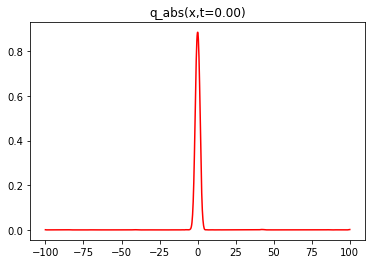

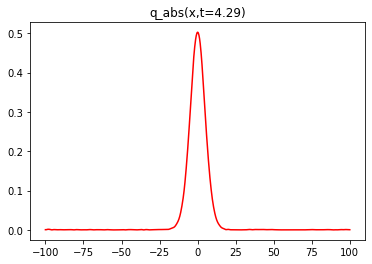

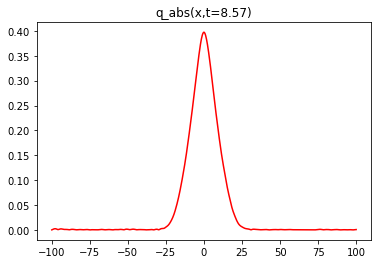

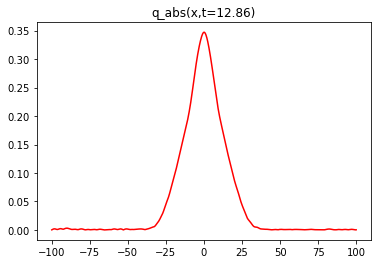

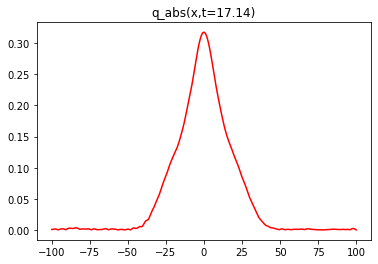

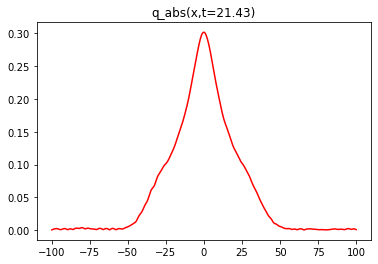

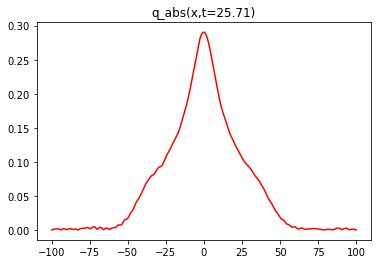

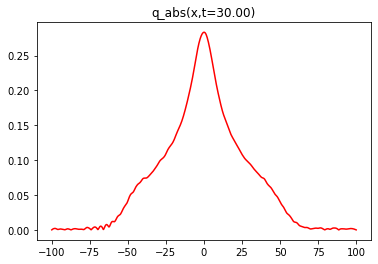

In [87]:
t=t_0
while t<=t_1:
  current_row = int(t_parts*(t-t_0)/(t_1-t_0))
  if t==t_1: current_row=-1 #если смотрим значения в t_1, то ясно что это последняя колонка
  q_abs_pred = (u_pred.reshape((t_parts, x_parts))[current_row,:]**2 + v_pred.reshape((t_parts, x_parts))[current_row,:]**2)**0.5
  q_abs_exact = (Exact_u[current_row,:]**2 + Exact_v[current_row,:]**2)**0.5
  plt.plot(X[current_row, :], q_abs_pred, color = "red")
  #plt.plot(X[current_row, :], q_abs_exact, color = "green")
  plt.title('q_abs(x,t=%.2f)'%t)
  plt.show()
  t+=abs(t_1-t_0)/7

Точность выполнения условий уравнения:

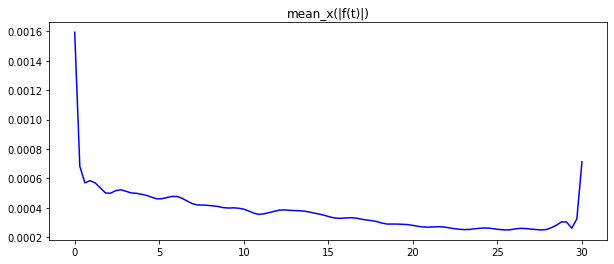

Mean_xt(|f|): 3.769296e-04


In [88]:
loss_abs_f = (f_u_pred**2 + f_v_pred**2)**0.5 #тензор модулей значений уравнения
loss_abs_f_array=[]
t_array=[]
for t in np.linspace(t_0, t_1, 100):
  current_row = int(t_parts*(t-t_0)/(t_1-t_0))
  if t==t_1: current_row=-1 #если смотрим значения в t_1, то ясно что это последняя колонка
  loss_abs_f_array.append(loss_abs_f.reshape((t_parts, x_parts))[current_row,:].mean())
  t_array.append(t)
plt.figure(figsize=(10,4))
plt.plot(t_array, loss_abs_f_array, color = "blue")
plt.title('mean_x(|f(t)|)') #среднее значение модуля функции на срезе при фиксированном t
plt.show()
print('Mean_xt(|f|): %e' %loss_abs_f.mean(axis=0).item()) #среднее значение модуля функции на всей сетке

Проверка законов сохранения:

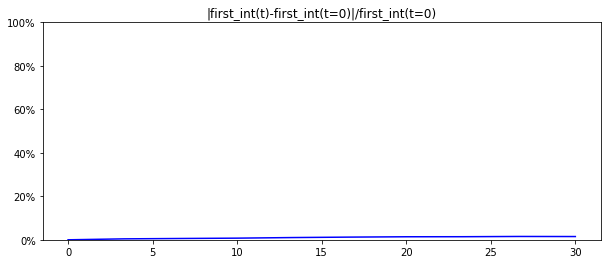

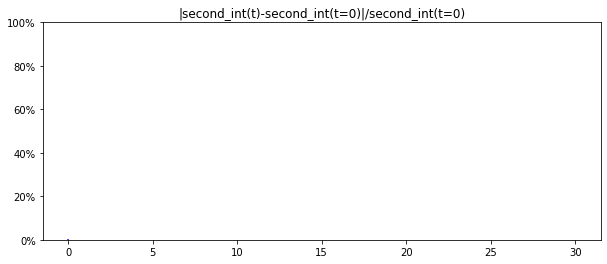

First law MSE: 5.923886e-04, Second law MSE: 1.046296e-06
First law mean: 2.177312e-02, Second law mean: 7.841643e-04


In [89]:
import matplotlib.ticker as mtick
x_fragments = 400 #разбиение при интегрировании по x при фиксированном t
t_amount = 10 #в скольких точках t считается интеграл
x_l = np.linspace(x_0, x_1, x_fragments).reshape(x_fragments,1)
t_l = np.linspace(t_0, t_1, t_amount).reshape(t_amount,1)
X_l = torch.tensor(x_l, requires_grad=True).float().to(device)
T_l = torch.tensor(t_l, requires_grad=True).float().to(device)
x_step=(X_l[1]-X_l[0]).item()

#реализация первого закона сохранения
u, v = model.net_uv(X_l, torch.full((x_fragments,1),T_l[0:1].item(), requires_grad=True).float().to(device))
initial_integral = ((u**2 + v**2) * x_step).sum() #вычисляем интеграл в t_0
u, v = model.net_uv(X_l.expand(x_fragments, t_amount).T.reshape(x_fragments*t_amount,1), T_l.expand(t_amount, x_fragments).reshape(x_fragments*t_amount,1))
first_variation = (((u.reshape(t_amount, x_fragments)**2 + v.reshape(t_amount, x_fragments)**2) * x_step).sum(axis=1) - initial_integral)**2 #вычисляем интегралы при других t и находим отклонение
first_variation = first_variation.detach()
MSE_fl = first_variation.mean(axis=0).item() #возвращаем средний квадрат отклонения
mean_fl = (first_variation**0.5).mean(axis=0).item() #а также средний модуль отклонения
plt.figure(figsize=(10,4))
plt.plot(t_l, (first_variation**0.5/initial_integral).detach().cpu(), color = "blue") #строим график соблюдения первого закона сохранения(чем ближе к 0, тем лучше)
plt.title('|first_int(t)-first_int(t=0)|/first_int(t=0)')
plt.ylim(0,1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0)) #меняем числа на проценты
plt.show()

#реализация второго закона сохранения
u, v = model.net_uv(X_l, torch.full((x_fragments,1),T_l[0:1].item(), requires_grad=True).float().to(device))
u_x = torch.autograd.grad(u, X_l, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
v_x = torch.autograd.grad(v, X_l, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
initial_integral = ((v_x*u - u_x*v) * x_step).sum() #вычисляем интеграл в t_0
X_l_expanded = X_l.expand(x_fragments, t_amount).T.reshape(x_fragments*t_amount,1)
T_l_expanded = T_l.expand(t_amount, x_fragments).reshape(x_fragments*t_amount,1)
u, v = model.net_uv(X_l_expanded, T_l_expanded)
u_x = torch.autograd.grad(u, X_l_expanded, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
v_x = torch.autograd.grad(v, X_l_expanded, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
second_variation = ((((v_x*u).reshape(t_amount, x_fragments) - (u_x*v).reshape(t_amount, x_fragments)) * x_step).sum(axis=1) - initial_integral)**2 #вычисляем интегралы при других t и находим отклонение
second_variation = second_variation.detach()
MSE_sl = second_variation.mean(axis=0).item() #возвращаем средний квадрат отклонения
mean_sl = (second_variation**0.5).mean(axis=0).item() #а также средний модуль отклонения
plt.figure(figsize=(10,4))
plt.plot(t_l, (second_variation**0.5/initial_integral).detach().cpu(), color = "blue") #строим график соблюдения первого закона сохранения(чем ближе к 0, тем лучше)
plt.title('|second_int(t)-second_int(t=0)|/second_int(t=0)')
plt.ylim(0,1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.show()

print('First law MSE: %e, Second law MSE: %e' %(MSE_fl, MSE_sl))
print('First law mean: %e, Second law mean: %e' %(mean_fl, mean_sl)) #среднее значение модуля отклонения интеграла от первоначального значения

###$q(x,0)=(1-i)e^{-\frac{x-1}{2}^2} + (-1+i)e^{-\frac{x+1}{2}^2}$

In [90]:
def q(x,t):
  f_term = np.exp(-(x-1/2)**2)
  s_term = np.exp(-(x+1/2)**2)
  u = f_term - s_term
  v = -f_term + s_term
  return u, v

In [91]:
Exact_u=q(X,T)[0]
Exact_v=q(X,T)[1]

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact_u.flatten()[:,None]
v_star = Exact_v.flatten()[:,None]

# границы области
lb = X_star.min(0)
ub = X_star.max(0)

# для обучения берём только данные на границах области(граничные условия по сути)
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T)) #(x,t_0)
uu1 = Exact_u[0:1,:].T
vv1 = Exact_v[0:1,:].T
xx2 = np.hstack((X[:,0:1], T[:,0:1])) #(x_0,t)
uu2 = np.zeros((t_parts,1)) #граничные условия поставил 0 в соответствии с требованиями
vv2 = np.zeros((t_parts,1))
xx3 = np.hstack((X[:,-1:], T[:,-1:])) #(x_1,t)
uu3 = np.zeros((t_parts,1)) #тут тоже
vv3 = np.zeros((t_parts,1))

X_uv_train = np.vstack([xx1, xx2, xx3]) #данные для тренировки в точках на границе
u_train = np.vstack([uu1, uu2, uu3])
v_train = np.vstack([vv1, vv2, vv3])
X_f_train = lb + (ub-lb)*lhs(2, N_f) #данные для тренировки в случайных точкам из области
X_f_train = np.vstack((X_f_train, X_uv_train)) #добавим к ним ещё и точки на границе, там f тоже 0

idx = np.random.choice(X_uv_train.shape[0], N_u, replace=False) #выберем из точек на границе только N_u
X_uv_train = X_uv_train[idx, :]
u_train = u_train[idx,:]
v_train = v_train[idx,:]

loss_array = [] #массив с loss в процессе обучения
loss_fl_array = [] #массивы с loss_fl и loss_sl
loss_sl_array = []
iter_array = [] #итерации с шагом 100

вот как оно выглядит:

<ipython-input-92-785265ad290e>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, Exact_u, cmap='RdBu', vmin=u_min, vmax=u_max)


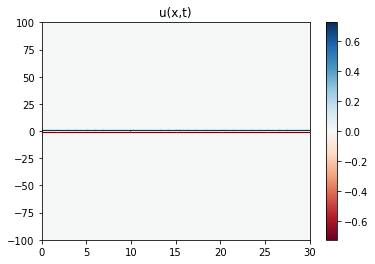

<ipython-input-92-785265ad290e>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, Exact_v, cmap='RdBu', vmin=v_min, vmax=v_max)


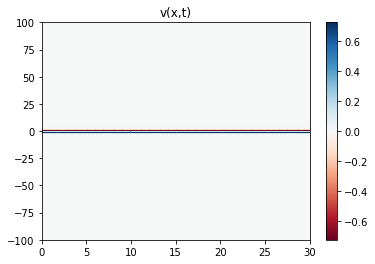

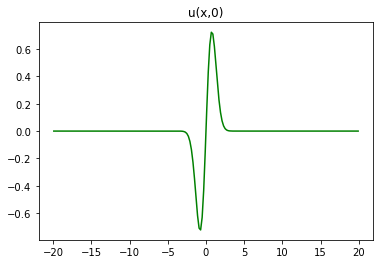

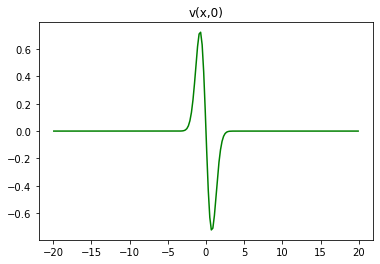

In [92]:
fig, ax = plt.subplots()
u_min, u_max = -np.abs(Exact_u).max(), np.abs(Exact_u).max()
c = ax.pcolormesh(T, X, Exact_u, cmap='RdBu', vmin=u_min, vmax=u_max)
ax.set_title('u(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
plt.show()

fig, ax = plt.subplots()
v_min, v_max = -np.abs(Exact_v).max(), np.abs(Exact_v).max()
c = ax.pcolormesh(T, X, Exact_v, cmap='RdBu', vmin=v_min, vmax=v_max)
ax.set_title('v(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
plt.show()

plt.plot(X[0, 400:600], Exact_u[0, 400:600], color = "green")
plt.title('u(x,0)')
plt.show()

plt.plot(X[0, 400:600], Exact_v[0, 400:600], color = "green")
plt.title('v(x,0)')
plt.show()

Обучение

In [93]:
model = PhysicsInformedNN(X_uv_train, u_train, v_train, X_f_train, layers, lb, ub, alpha, beta)

In [94]:
%%time
#штука сверху выведет итоговое время выполнения
model.train()

training started
30000 iterations of ADAM:
Iter 1000, Loss: 2.20435e-05, Loss_uv: 2.87238e-06, Loss_f: 1.91711e-05
Iter 2000, Loss: 1.44974e-05, Loss_uv: 2.10675e-06, Loss_f: 1.23907e-05
Iter 3000, Loss: 9.12984e-06, Loss_uv: 6.76166e-07, Loss_f: 8.45367e-06
Iter 4000, Loss: 5.38268e-05, Loss_uv: 3.60825e-06, Loss_f: 5.02185e-05
Iter 5000, Loss: 2.16619e-05, Loss_uv: 7.72287e-07, Loss_f: 2.08896e-05
Iter 6000, Loss: 1.69523e-05, Loss_uv: 6.75025e-07, Loss_f: 1.62773e-05
Iter 7000, Loss: 1.59096e-05, Loss_uv: 3.97477e-06, Loss_f: 1.19348e-05
Iter 8000, Loss: 8.88415e-06, Loss_uv: 5.89325e-07, Loss_f: 8.29483e-06
Iter 9000, Loss: 6.83349e-06, Loss_uv: 1.13312e-06, Loss_f: 5.70036e-06
Iter 10000, Loss: 5.05762e-06, Loss_uv: 2.73509e-07, Loss_f: 4.78411e-06
Iter 11000, Loss: 3.96847e-06, Loss_uv: 2.17654e-07, Loss_f: 3.75081e-06
Iter 12000, Loss: 3.14195e-05, Loss_uv: 1.62340e-06, Loss_f: 2.97961e-05
Iter 13000, Loss: 1.58121e-05, Loss_uv: 1.14386e-06, Loss_f: 1.46683e-05
Iter 14000, Loss:

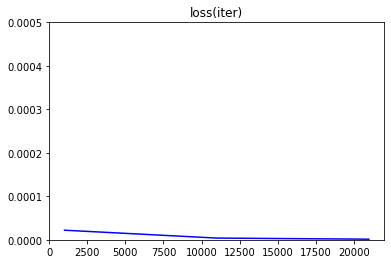

In [95]:
import matplotlib.pyplot as plt
plt.plot(np.array(iter_array)[::10], np.array(loss_array)[::10], color = "blue")
plt.ylim(0,5e-4)
plt.title('loss(iter)')
plt.show()

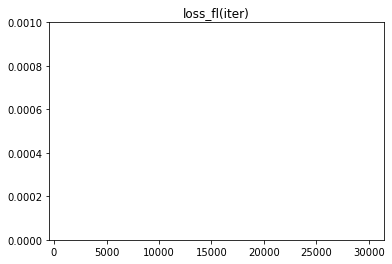

In [96]:
plt.plot(np.array(iter_array), np.array(loss_fl_array), color = "blue")
plt.ylim(0,1e-3)
plt.title('loss_fl(iter)')
plt.show()

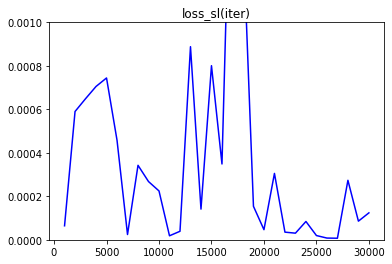

In [97]:
plt.plot(np.array(iter_array), np.array(loss_sl_array), color = "blue")
plt.ylim(0,1e-3)
plt.title('loss_sl(iter)')
plt.show()

In [98]:
u_pred, v_pred, f_u_pred, f_v_pred = model.predict(X_star) #можно ради интереса сравнить с суммой дух решений, которая строго говоря не является решением(но именно от неё и берутся начальные условия)
mse_u = ((u_star-u_pred)**2).mean(axis=0).item()
mse_v = ((v_star-v_pred)**2).mean(axis=0).item()
mse_q = (((u_star**2+v_star**2)**0.5 - (u_pred**2+v_pred**2)**0.5)**2).mean(axis=0).item() #средний квадрат разности модулей
mse_f_u = ((f_u_pred)**2).mean(axis=0).item()
mse_f_v = ((f_v_pred)**2).mean(axis=0).item()
print('MSE_u: %e, MSE_v: %e, MSE_q: %e' %(mse_u, mse_v, mse_q))
print('MSE_f_u: %e, MSE_f_v: %e' %(mse_f_u, mse_f_v))

MSE_u: 1.272612e-02, MSE_v: 1.215457e-02, MSE_q: 1.675584e-02
MSE_f_u: 1.346334e-06, MSE_f_v: 7.387038e-07


Визуализация

Что выдала нейросеть:

<ipython-input-99-c42e7cd87c3e>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, u_pred.reshape((t_parts, x_parts)), cmap='RdBu', vmin=u_min, vmax=u_max)


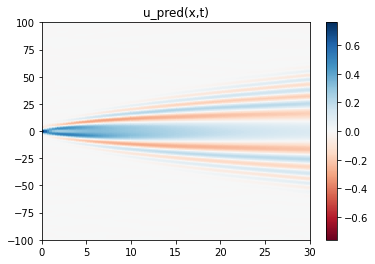

<ipython-input-99-c42e7cd87c3e>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, v_pred.reshape((t_parts, x_parts)), cmap='RdBu', vmin=v_min, vmax=v_max)


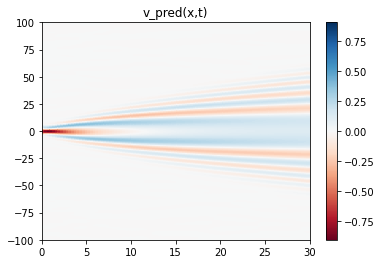

In [99]:
fig, ax = plt.subplots()
u_min, u_max = -np.abs(u_pred).max(), np.abs(u_pred).max()
c = ax.pcolormesh(T, X, u_pred.reshape((t_parts, x_parts)), cmap='RdBu', vmin=u_min, vmax=u_max)
ax.set_title('u_pred(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
#plt.scatter(X_uv_train[:,1], X_uv_train[:,0], s=7, color='black')
#plt.scatter(X_f_train[:,1], X_f_train[:,0], s=3, color='black', alpha=0.3)
plt.show()

fig, ax = plt.subplots()
v_min, v_max = -np.abs(v_pred).max(), np.abs(v_pred).max()
c = ax.pcolormesh(T, X, v_pred.reshape((t_parts, x_parts)), cmap='RdBu', vmin=v_min, vmax=v_max)
ax.set_title('v_pred(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
plt.show()

Что должно быть в теории:

<ipython-input-100-3c5c3b734f9c>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, Exact_u, cmap='RdBu', vmin=u_min, vmax=u_max)


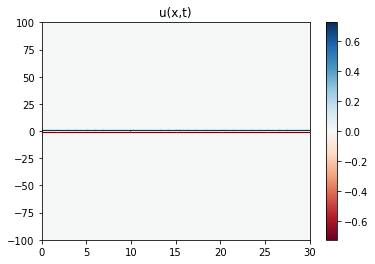

<ipython-input-100-3c5c3b734f9c>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, Exact_v, cmap='RdBu', vmin=v_min, vmax=v_max)


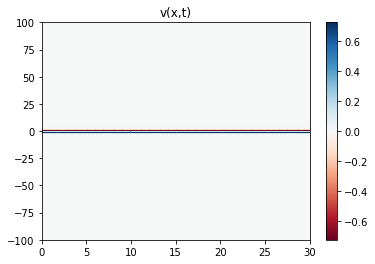

In [100]:
fig, ax = plt.subplots()
u_min, u_max = -np.abs(Exact_u).max(), np.abs(Exact_u).max()
c = ax.pcolormesh(T, X, Exact_u, cmap='RdBu', vmin=u_min, vmax=u_max)
ax.set_title('u(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
plt.show()

fig, ax = plt.subplots()
v_min, v_max = -np.abs(Exact_v).max(), np.abs(Exact_v).max()
c = ax.pcolormesh(T, X, Exact_v, cmap='RdBu', vmin=v_min, vmax=v_max)
ax.set_title('v(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
plt.show()

Решение в срезах по t:

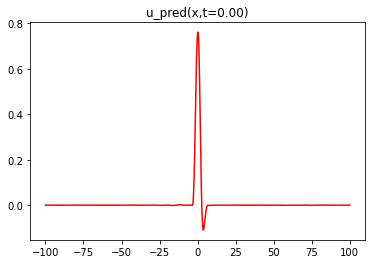

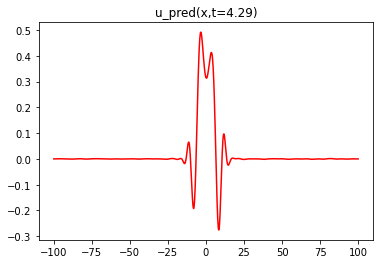

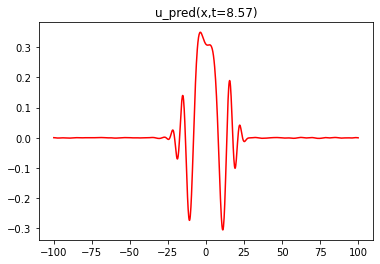

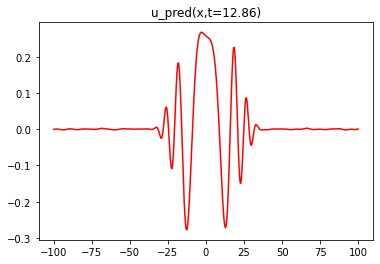

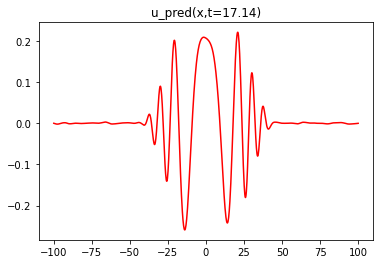

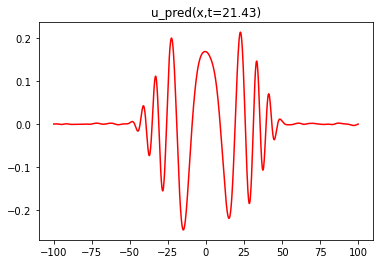

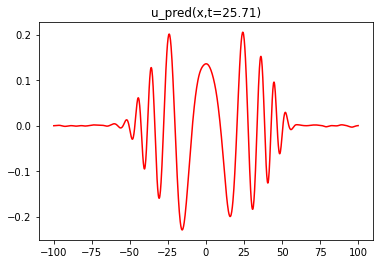

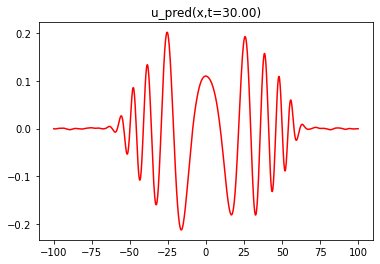

In [101]:
t=t_0
while t<=t_1:
  current_row = int(t_parts*(t-t_0)/(t_1-t_0))
  if t==t_1: current_row=-1 #если смотрим значения в t_1, то ясно что это последняя колонка
  plt.plot(X[current_row, :], u_pred.reshape((t_parts, x_parts))[current_row,:], color = "red") #предсказанное решение
  #plt.plot(X[current_row, :], Exact_u[current_row,:], color = "green")
  plt.title('u_pred(x,t=%.2f)'%t)
  plt.show()
  t+=abs(t_1-t_0)/7

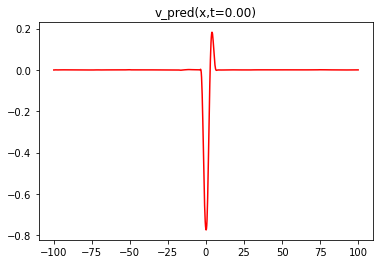

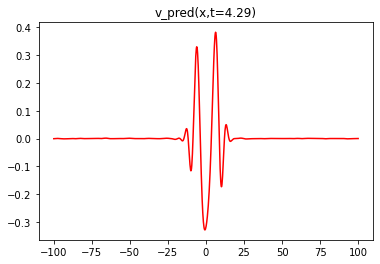

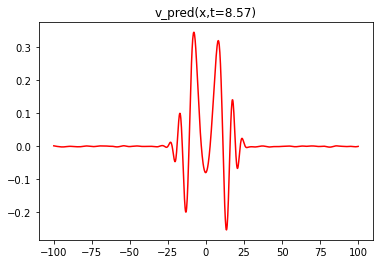

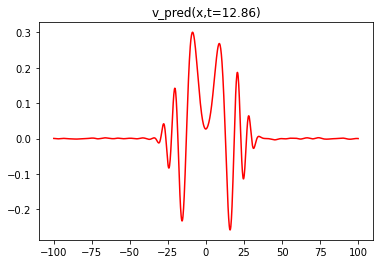

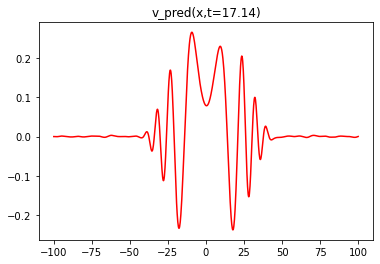

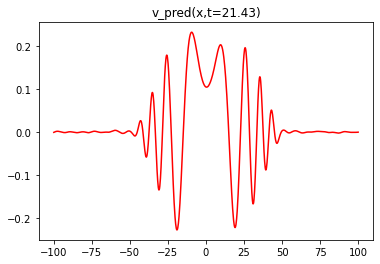

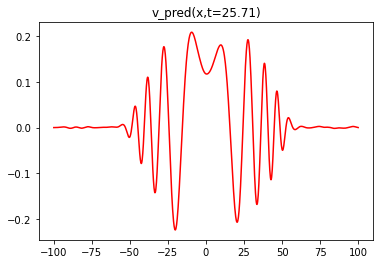

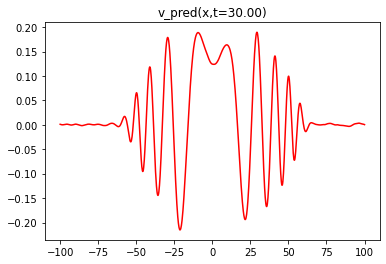

In [102]:
t=t_0
while t<=t_1:
  current_row = int(t_parts*(t-t_0)/(t_1-t_0))
  if t==t_1: current_row=-1 #если смотрим значения в t_1, то ясно что это последняя колонка
  plt.plot(X[current_row, :], v_pred.reshape((t_parts, x_parts))[current_row,:], color = "red")
  #plt.plot(X[current_row, :], Exact_v[current_row,:], color = "green")
  plt.title('v_pred(x,t=%.2f)'%t)
  plt.show()
  t+=abs(t_1-t_0)/7

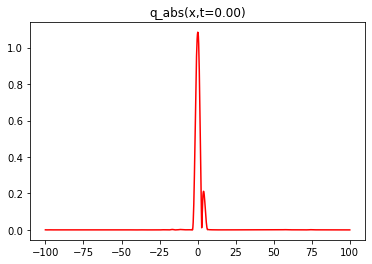

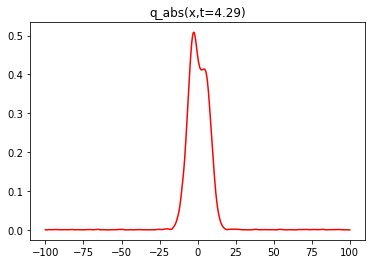

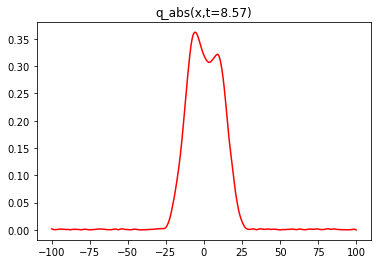

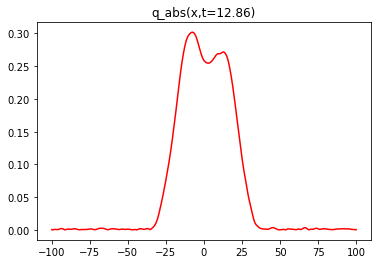

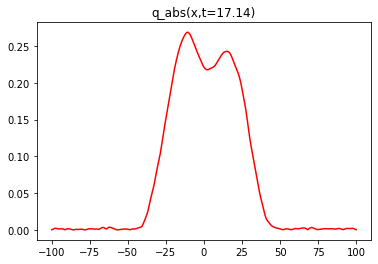

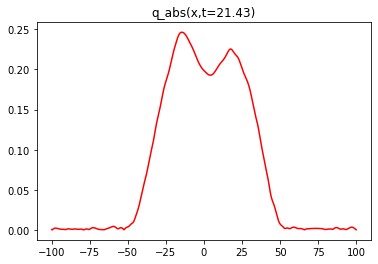

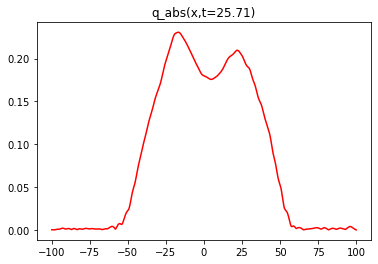

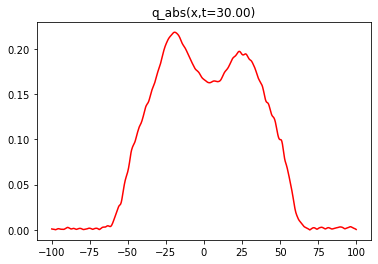

In [103]:
t=t_0
while t<=t_1:
  current_row = int(t_parts*(t-t_0)/(t_1-t_0))
  if t==t_1: current_row=-1 #если смотрим значения в t_1, то ясно что это последняя колонка
  q_abs_pred = (u_pred.reshape((t_parts, x_parts))[current_row,:]**2 + v_pred.reshape((t_parts, x_parts))[current_row,:]**2)**0.5
  q_abs_exact = (Exact_u[current_row,:]**2 + Exact_v[current_row,:]**2)**0.5
  plt.plot(X[current_row, :], q_abs_pred, color = "red")
  #plt.plot(X[current_row, :], q_abs_exact, color = "green")
  plt.title('q_abs(x,t=%.2f)'%t)
  plt.show()
  t+=abs(t_1-t_0)/7

Точность выполнения условий уравнения:

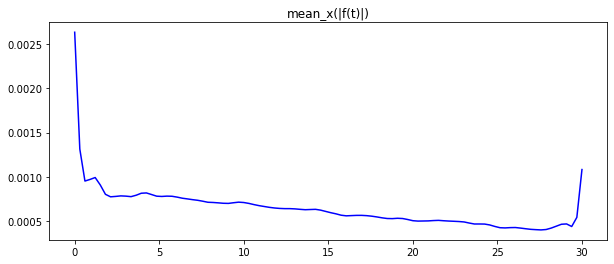

Mean_xt(|f|): 6.471562e-04


In [104]:
loss_abs_f = (f_u_pred**2 + f_v_pred**2)**0.5 #тензор модулей значений уравнения
loss_abs_f_array=[]
t_array=[]
for t in np.linspace(t_0, t_1, 100):
  current_row = int(t_parts*(t-t_0)/(t_1-t_0))
  if t==t_1: current_row=-1 #если смотрим значения в t_1, то ясно что это последняя колонка
  loss_abs_f_array.append(loss_abs_f.reshape((t_parts, x_parts))[current_row,:].mean())
  t_array.append(t)
plt.figure(figsize=(10,4))
plt.plot(t_array, loss_abs_f_array, color = "blue")
plt.title('mean_x(|f(t)|)') #среднее значение модуля функции на срезе при фиксированном t
plt.show()
print('Mean_xt(|f|): %e' %loss_abs_f.mean(axis=0).item()) #среднее значение модуля функции на всей сетке

Проверка законов сохранения:

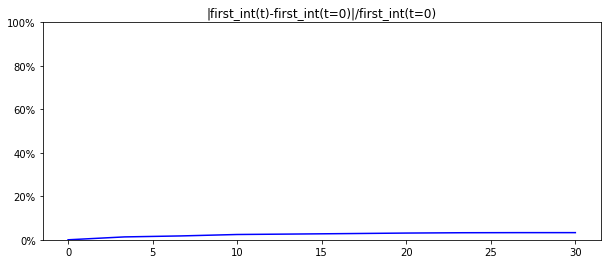

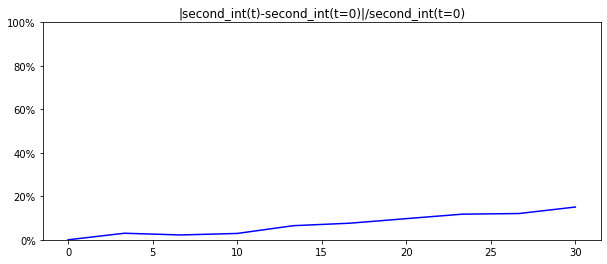

First law MSE: 6.353681e-03, Second law MSE: 3.414579e-05
First law mean: 7.336755e-02, Second law mean: 4.854186e-03


In [105]:
import matplotlib.ticker as mtick
x_fragments = 400 #разбиение при интегрировании по x при фиксированном t
t_amount = 10 #в скольких точках t считается интеграл
x_l = np.linspace(x_0, x_1, x_fragments).reshape(x_fragments,1)
t_l = np.linspace(t_0, t_1, t_amount).reshape(t_amount,1)
X_l = torch.tensor(x_l, requires_grad=True).float().to(device)
T_l = torch.tensor(t_l, requires_grad=True).float().to(device)
x_step=(X_l[1]-X_l[0]).item()

#реализация первого закона сохранения
u, v = model.net_uv(X_l, torch.full((x_fragments,1),T_l[0:1].item(), requires_grad=True).float().to(device))
initial_integral = ((u**2 + v**2) * x_step).sum() #вычисляем интеграл в t_0
u, v = model.net_uv(X_l.expand(x_fragments, t_amount).T.reshape(x_fragments*t_amount,1), T_l.expand(t_amount, x_fragments).reshape(x_fragments*t_amount,1))
first_variation = (((u.reshape(t_amount, x_fragments)**2 + v.reshape(t_amount, x_fragments)**2) * x_step).sum(axis=1) - initial_integral)**2 #вычисляем интегралы при других t и находим отклонение
first_variation = first_variation.detach()
MSE_fl = first_variation.mean(axis=0).item() #возвращаем средний квадрат отклонения
mean_fl = (first_variation**0.5).mean(axis=0).item() #а также средний модуль отклонения
plt.figure(figsize=(10,4))
plt.plot(t_l, (first_variation**0.5/initial_integral).detach().cpu(), color = "blue") #строим график соблюдения первого закона сохранения(чем ближе к 0, тем лучше)
plt.title('|first_int(t)-first_int(t=0)|/first_int(t=0)')
plt.ylim(0,1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0)) #меняем числа на проценты
plt.show()

#реализация второго закона сохранения
u, v = model.net_uv(X_l, torch.full((x_fragments,1),T_l[0:1].item(), requires_grad=True).float().to(device))
u_x = torch.autograd.grad(u, X_l, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
v_x = torch.autograd.grad(v, X_l, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
initial_integral = ((v_x*u - u_x*v) * x_step).sum() #вычисляем интеграл в t_0
X_l_expanded = X_l.expand(x_fragments, t_amount).T.reshape(x_fragments*t_amount,1)
T_l_expanded = T_l.expand(t_amount, x_fragments).reshape(x_fragments*t_amount,1)
u, v = model.net_uv(X_l_expanded, T_l_expanded)
u_x = torch.autograd.grad(u, X_l_expanded, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
v_x = torch.autograd.grad(v, X_l_expanded, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
second_variation = ((((v_x*u).reshape(t_amount, x_fragments) - (u_x*v).reshape(t_amount, x_fragments)) * x_step).sum(axis=1) - initial_integral)**2 #вычисляем интегралы при других t и находим отклонение
second_variation = second_variation.detach()
MSE_sl = second_variation.mean(axis=0).item() #возвращаем средний квадрат отклонения
mean_sl = (second_variation**0.5).mean(axis=0).item() #а также средний модуль отклонения
plt.figure(figsize=(10,4))
plt.plot(t_l, (second_variation**0.5/initial_integral).detach().cpu(), color = "blue") #строим график соблюдения первого закона сохранения(чем ближе к 0, тем лучше)
plt.title('|second_int(t)-second_int(t=0)|/second_int(t=0)')
plt.ylim(0,1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.show()

print('First law MSE: %e, Second law MSE: %e' %(MSE_fl, MSE_sl))
print('First law mean: %e, Second law mean: %e' %(mean_fl, mean_sl)) #среднее значение модуля отклонения интеграла от первоначального значения

###$q(x,0)=e^{3ix}*e^{-\frac{x}{2}^2}$

In [106]:
def q(x,t):
  f_com = np.exp(-(x/2)**2)
  u = f_com*np.cos(3*x)
  v = f_com*np.sin(3*x)
  return u, v

In [107]:
Exact_u=q(X,T)[0]
Exact_v=q(X,T)[1]

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact_u.flatten()[:,None]
v_star = Exact_v.flatten()[:,None]

# границы области
lb = X_star.min(0)
ub = X_star.max(0)

# для обучения берём только данные на границах области(граничные условия по сути)
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T)) #(x,t_0)
uu1 = Exact_u[0:1,:].T
vv1 = Exact_v[0:1,:].T
xx2 = np.hstack((X[:,0:1], T[:,0:1])) #(x_0,t)
uu2 = np.zeros((t_parts,1)) #граничные условия поставил 0 в соответствии с требованиями
vv2 = np.zeros((t_parts,1))
xx3 = np.hstack((X[:,-1:], T[:,-1:])) #(x_1,t)
uu3 = np.zeros((t_parts,1)) #тут тоже
vv3 = np.zeros((t_parts,1))

X_uv_train = np.vstack([xx1, xx2, xx3]) #данные для тренировки в точках на границе
u_train = np.vstack([uu1, uu2, uu3])
v_train = np.vstack([vv1, vv2, vv3])
X_f_train = lb + (ub-lb)*lhs(2, N_f) #данные для тренировки в случайных точкам из области
X_f_train = np.vstack((X_f_train, X_uv_train)) #добавим к ним ещё и точки на границе, там f тоже 0

idx = np.random.choice(X_uv_train.shape[0], N_u, replace=False) #выберем из точек на границе только N_u
X_uv_train = X_uv_train[idx, :]
u_train = u_train[idx,:]
v_train = v_train[idx,:]

loss_array = [] #массив с loss в процессе обучения
loss_fl_array = [] #массивы с loss_fl и loss_sl
loss_sl_array = []
iter_array = [] #итерации с шагом 100

вот как оно выглядит:

<ipython-input-108-785265ad290e>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, Exact_u, cmap='RdBu', vmin=u_min, vmax=u_max)


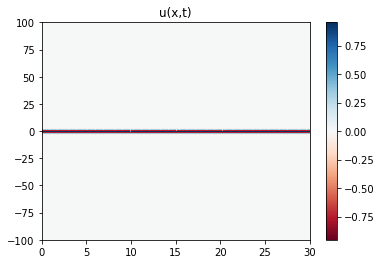

<ipython-input-108-785265ad290e>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, Exact_v, cmap='RdBu', vmin=v_min, vmax=v_max)


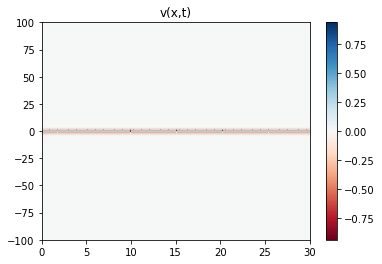

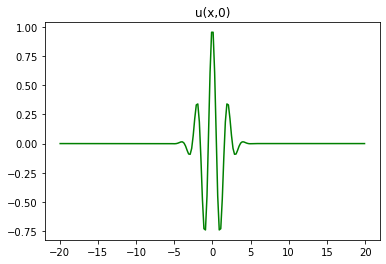

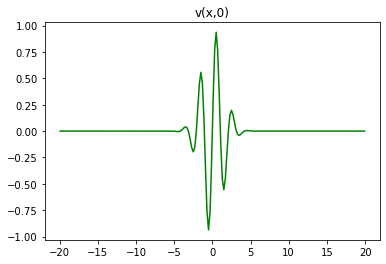

In [108]:
fig, ax = plt.subplots()
u_min, u_max = -np.abs(Exact_u).max(), np.abs(Exact_u).max()
c = ax.pcolormesh(T, X, Exact_u, cmap='RdBu', vmin=u_min, vmax=u_max)
ax.set_title('u(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
plt.show()

fig, ax = plt.subplots()
v_min, v_max = -np.abs(Exact_v).max(), np.abs(Exact_v).max()
c = ax.pcolormesh(T, X, Exact_v, cmap='RdBu', vmin=v_min, vmax=v_max)
ax.set_title('v(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
plt.show()

plt.plot(X[0, 400:600], Exact_u[0, 400:600], color = "green")
plt.title('u(x,0)')
plt.show()

plt.plot(X[0, 400:600], Exact_v[0, 400:600], color = "green")
plt.title('v(x,0)')
plt.show()

Обучение

In [109]:
model = PhysicsInformedNN(X_uv_train, u_train, v_train, X_f_train, layers, lb, ub, alpha, beta)

In [110]:
%%time
#штука сверху выведет итоговое время выполнения
model.train()

training started
30000 iterations of ADAM:
Iter 1000, Loss: 2.08352e-04, Loss_uv: 7.42801e-05, Loss_f: 1.34072e-04
Iter 2000, Loss: 1.29818e-04, Loss_uv: 2.43241e-05, Loss_f: 1.05494e-04
Iter 3000, Loss: 3.67352e-04, Loss_uv: 1.69229e-04, Loss_f: 1.98123e-04
Iter 4000, Loss: 8.32064e-05, Loss_uv: 2.43850e-05, Loss_f: 5.88214e-05
Iter 5000, Loss: 9.20576e-05, Loss_uv: 2.20941e-05, Loss_f: 6.99635e-05
Iter 6000, Loss: 1.41802e-04, Loss_uv: 3.04760e-05, Loss_f: 1.11326e-04
Iter 7000, Loss: 8.86705e-05, Loss_uv: 3.59627e-05, Loss_f: 5.27078e-05
Iter 8000, Loss: 1.00199e-04, Loss_uv: 3.18384e-05, Loss_f: 6.83608e-05
Iter 9000, Loss: 1.23123e-04, Loss_uv: 2.27375e-05, Loss_f: 1.00386e-04
Iter 10000, Loss: 9.24078e-05, Loss_uv: 1.47560e-05, Loss_f: 7.76518e-05
Iter 11000, Loss: 1.50047e-04, Loss_uv: 2.72920e-05, Loss_f: 1.22755e-04
Iter 12000, Loss: 1.12857e-04, Loss_uv: 2.45564e-05, Loss_f: 8.83007e-05
Iter 13000, Loss: 9.39812e-05, Loss_uv: 2.99453e-05, Loss_f: 6.40359e-05
Iter 14000, Loss:

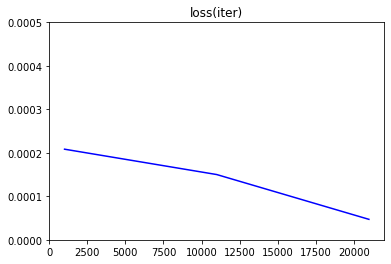

In [111]:
import matplotlib.pyplot as plt
plt.plot(np.array(iter_array)[::10], np.array(loss_array)[::10], color = "blue")
plt.ylim(0,5e-4)
plt.title('loss(iter)')
plt.show()

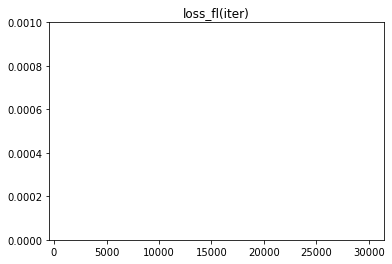

In [112]:
plt.plot(np.array(iter_array), np.array(loss_fl_array), color = "blue")
plt.ylim(0,1e-3)
plt.title('loss_fl(iter)')
plt.show()

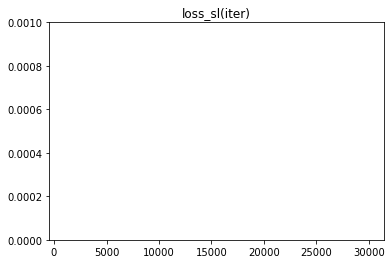

In [113]:
plt.plot(np.array(iter_array), np.array(loss_sl_array), color = "blue")
plt.ylim(0,1e-3)
plt.title('loss_sl(iter)')
plt.show()

In [114]:
u_pred, v_pred, f_u_pred, f_v_pred = model.predict(X_star) #можно ради интереса сравнить с суммой дух решений, которая строго говоря не является решением(но именно от неё и берутся начальные условия)
mse_u = ((u_star-u_pred)**2).mean(axis=0).item()
mse_v = ((v_star-v_pred)**2).mean(axis=0).item()
mse_q = (((u_star**2+v_star**2)**0.5 - (u_pred**2+v_pred**2)**0.5)**2).mean(axis=0).item() #средний квадрат разности модулей
mse_f_u = ((f_u_pred)**2).mean(axis=0).item()
mse_f_v = ((f_v_pred)**2).mean(axis=0).item()
print('MSE_u: %e, MSE_v: %e, MSE_q: %e' %(mse_u, mse_v, mse_q))
print('MSE_f_u: %e, MSE_f_v: %e' %(mse_f_u, mse_f_v))

MSE_u: 6.546558e-03, MSE_v: 6.523379e-03, MSE_q: 1.223263e-02
MSE_f_u: 7.661237e-05, MSE_f_v: 6.618872e-05


Визуализация

Что выдала нейросеть:

<ipython-input-115-c42e7cd87c3e>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, u_pred.reshape((t_parts, x_parts)), cmap='RdBu', vmin=u_min, vmax=u_max)


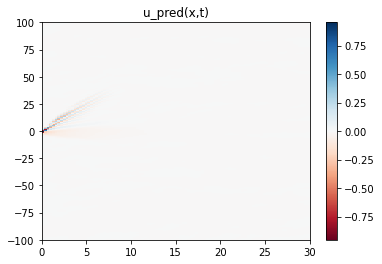

<ipython-input-115-c42e7cd87c3e>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, v_pred.reshape((t_parts, x_parts)), cmap='RdBu', vmin=v_min, vmax=v_max)


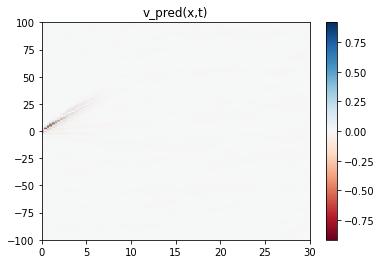

In [115]:
fig, ax = plt.subplots()
u_min, u_max = -np.abs(u_pred).max(), np.abs(u_pred).max()
c = ax.pcolormesh(T, X, u_pred.reshape((t_parts, x_parts)), cmap='RdBu', vmin=u_min, vmax=u_max)
ax.set_title('u_pred(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
#plt.scatter(X_uv_train[:,1], X_uv_train[:,0], s=7, color='black')
#plt.scatter(X_f_train[:,1], X_f_train[:,0], s=3, color='black', alpha=0.3)
plt.show()

fig, ax = plt.subplots()
v_min, v_max = -np.abs(v_pred).max(), np.abs(v_pred).max()
c = ax.pcolormesh(T, X, v_pred.reshape((t_parts, x_parts)), cmap='RdBu', vmin=v_min, vmax=v_max)
ax.set_title('v_pred(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
plt.show()

Что должно быть в теории:

<ipython-input-116-3c5c3b734f9c>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, Exact_u, cmap='RdBu', vmin=u_min, vmax=u_max)


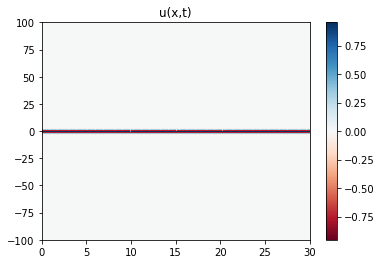

<ipython-input-116-3c5c3b734f9c>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, Exact_v, cmap='RdBu', vmin=v_min, vmax=v_max)


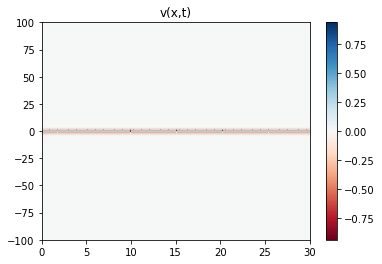

In [116]:
fig, ax = plt.subplots()
u_min, u_max = -np.abs(Exact_u).max(), np.abs(Exact_u).max()
c = ax.pcolormesh(T, X, Exact_u, cmap='RdBu', vmin=u_min, vmax=u_max)
ax.set_title('u(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
plt.show()

fig, ax = plt.subplots()
v_min, v_max = -np.abs(Exact_v).max(), np.abs(Exact_v).max()
c = ax.pcolormesh(T, X, Exact_v, cmap='RdBu', vmin=v_min, vmax=v_max)
ax.set_title('v(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
plt.show()

Решение в срезах по t:

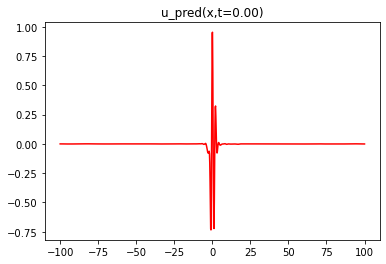

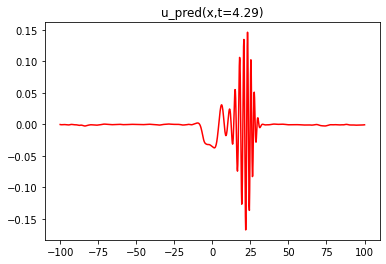

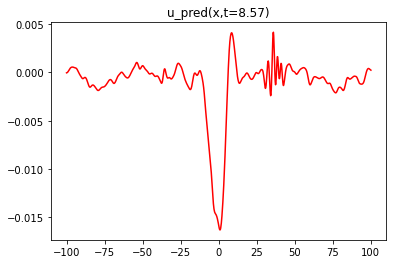

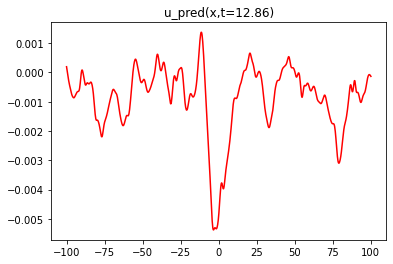

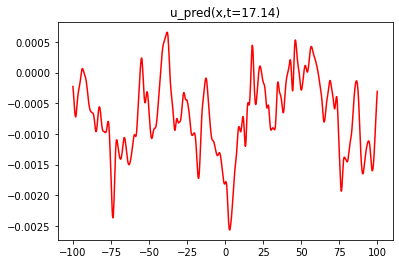

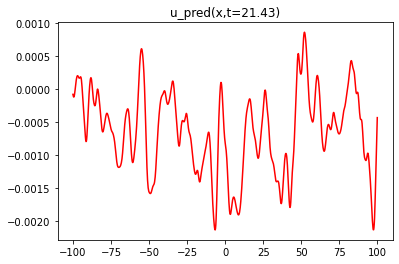

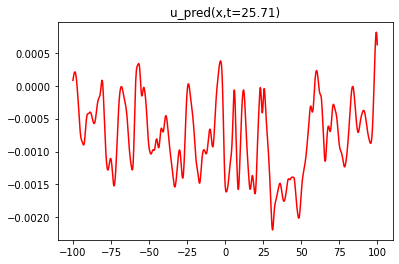

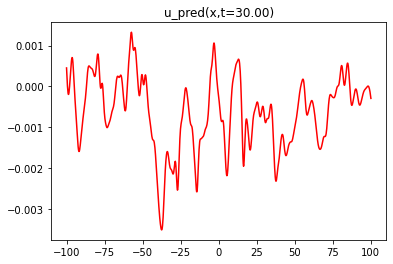

In [117]:
t=t_0
while t<=t_1:
  current_row = int(t_parts*(t-t_0)/(t_1-t_0))
  if t==t_1: current_row=-1 #если смотрим значения в t_1, то ясно что это последняя колонка
  plt.plot(X[current_row, :], u_pred.reshape((t_parts, x_parts))[current_row,:], color = "red") #предсказанное решение
  #plt.plot(X[current_row, :], Exact_u[current_row,:], color = "green")
  plt.title('u_pred(x,t=%.2f)'%t)
  plt.show()
  t+=abs(t_1-t_0)/7

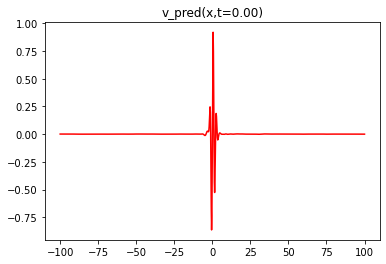

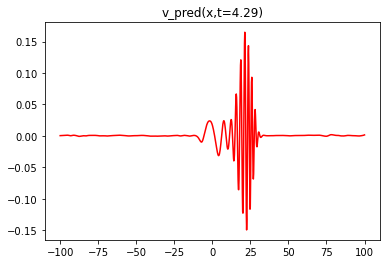

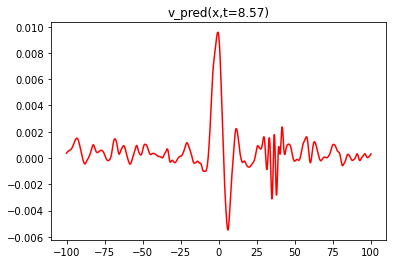

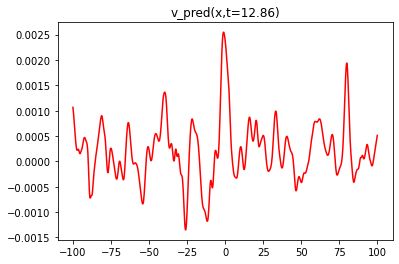

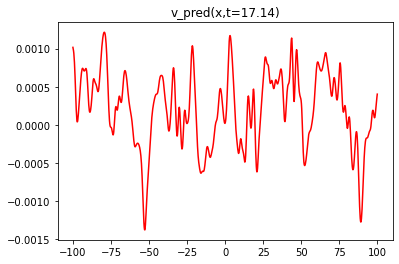

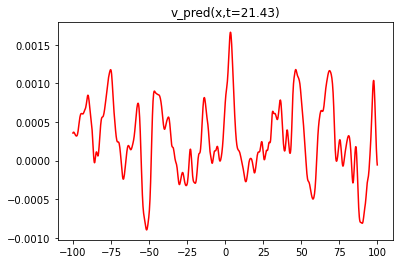

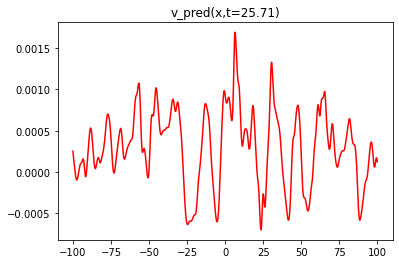

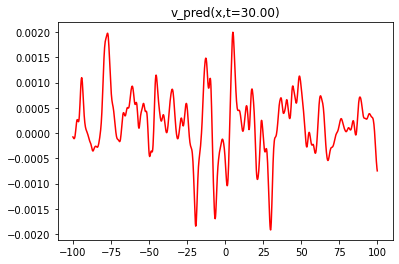

In [118]:
t=t_0
while t<=t_1:
  current_row = int(t_parts*(t-t_0)/(t_1-t_0))
  if t==t_1: current_row=-1 #если смотрим значения в t_1, то ясно что это последняя колонка
  plt.plot(X[current_row, :], v_pred.reshape((t_parts, x_parts))[current_row,:], color = "red")
  #plt.plot(X[current_row, :], Exact_v[current_row,:], color = "green")
  plt.title('v_pred(x,t=%.2f)'%t)
  plt.show()
  t+=abs(t_1-t_0)/7

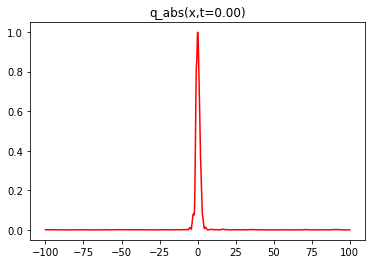

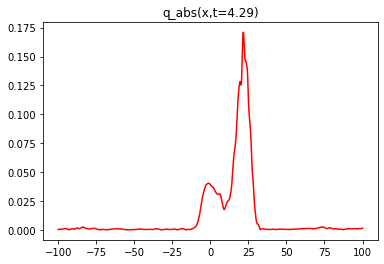

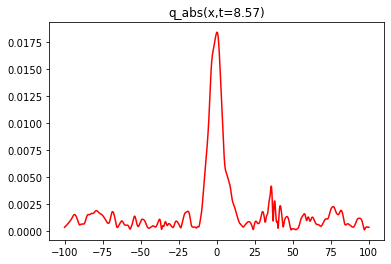

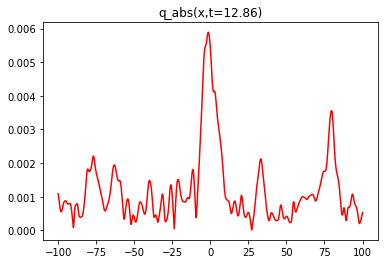

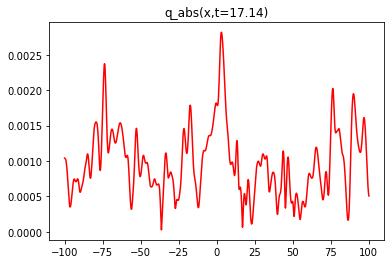

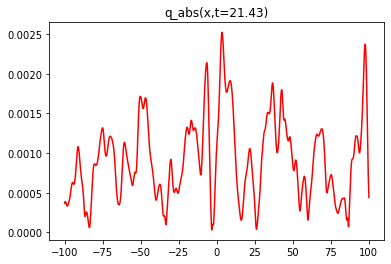

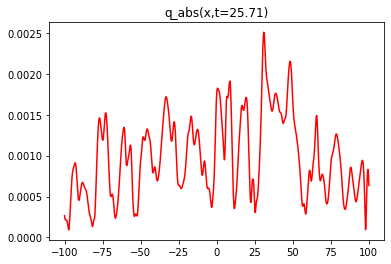

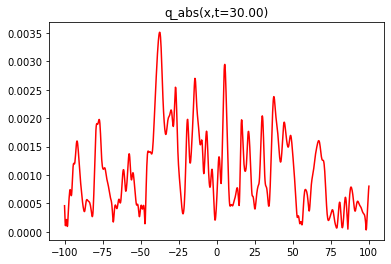

In [119]:
t=t_0
while t<=t_1:
  current_row = int(t_parts*(t-t_0)/(t_1-t_0))
  if t==t_1: current_row=-1 #если смотрим значения в t_1, то ясно что это последняя колонка
  q_abs_pred = (u_pred.reshape((t_parts, x_parts))[current_row,:]**2 + v_pred.reshape((t_parts, x_parts))[current_row,:]**2)**0.5
  q_abs_exact = (Exact_u[current_row,:]**2 + Exact_v[current_row,:]**2)**0.5
  plt.plot(X[current_row, :], q_abs_pred, color = "red")
  #plt.plot(X[current_row, :], q_abs_exact, color = "green")
  plt.title('q_abs(x,t=%.2f)'%t)
  plt.show()
  t+=abs(t_1-t_0)/7

Точность выполнения условий уравнения:

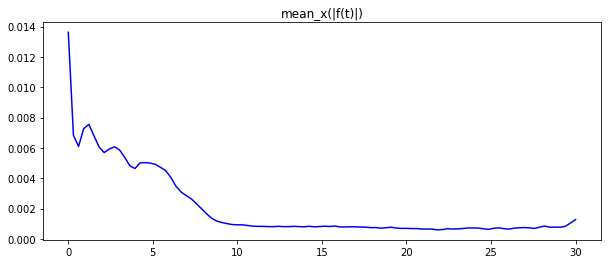

Mean_xt(|f|): 2.004374e-03


In [120]:
loss_abs_f = (f_u_pred**2 + f_v_pred**2)**0.5 #тензор модулей значений уравнения
loss_abs_f_array=[]
t_array=[]
for t in np.linspace(t_0, t_1, 100):
  current_row = int(t_parts*(t-t_0)/(t_1-t_0))
  if t==t_1: current_row=-1 #если смотрим значения в t_1, то ясно что это последняя колонка
  loss_abs_f_array.append(loss_abs_f.reshape((t_parts, x_parts))[current_row,:].mean())
  t_array.append(t)
plt.figure(figsize=(10,4))
plt.plot(t_array, loss_abs_f_array, color = "blue")
plt.title('mean_x(|f(t)|)') #среднее значение модуля функции на срезе при фиксированном t
plt.show()
print('Mean_xt(|f|): %e' %loss_abs_f.mean(axis=0).item()) #среднее значение модуля функции на всей сетке

Проверка законов сохранения:

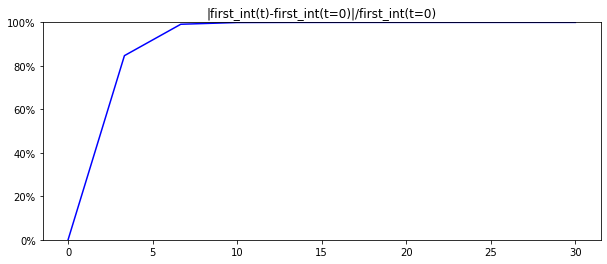

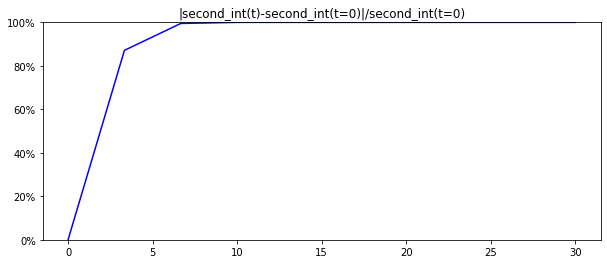

First law MSE: 4.307922e+00, Second law MSE: 3.452346e+01
First law mean: 1.966715e+00, Second law mean: 5.569493e+00


In [121]:
import matplotlib.ticker as mtick
x_fragments = 400 #разбиение при интегрировании по x при фиксированном t
t_amount = 10 #в скольких точках t считается интеграл
x_l = np.linspace(x_0, x_1, x_fragments).reshape(x_fragments,1)
t_l = np.linspace(t_0, t_1, t_amount).reshape(t_amount,1)
X_l = torch.tensor(x_l, requires_grad=True).float().to(device)
T_l = torch.tensor(t_l, requires_grad=True).float().to(device)
x_step=(X_l[1]-X_l[0]).item()

#реализация первого закона сохранения
u, v = model.net_uv(X_l, torch.full((x_fragments,1),T_l[0:1].item(), requires_grad=True).float().to(device))
initial_integral = ((u**2 + v**2) * x_step).sum() #вычисляем интеграл в t_0
u, v = model.net_uv(X_l.expand(x_fragments, t_amount).T.reshape(x_fragments*t_amount,1), T_l.expand(t_amount, x_fragments).reshape(x_fragments*t_amount,1))
first_variation = (((u.reshape(t_amount, x_fragments)**2 + v.reshape(t_amount, x_fragments)**2) * x_step).sum(axis=1) - initial_integral)**2 #вычисляем интегралы при других t и находим отклонение
first_variation = first_variation.detach()
MSE_fl = first_variation.mean(axis=0).item() #возвращаем средний квадрат отклонения
mean_fl = (first_variation**0.5).mean(axis=0).item() #а также средний модуль отклонения
plt.figure(figsize=(10,4))
plt.plot(t_l, (first_variation**0.5/initial_integral).detach().cpu(), color = "blue") #строим график соблюдения первого закона сохранения(чем ближе к 0, тем лучше)
plt.title('|first_int(t)-first_int(t=0)|/first_int(t=0)')
plt.ylim(0,1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0)) #меняем числа на проценты
plt.show()

#реализация второго закона сохранения
u, v = model.net_uv(X_l, torch.full((x_fragments,1),T_l[0:1].item(), requires_grad=True).float().to(device))
u_x = torch.autograd.grad(u, X_l, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
v_x = torch.autograd.grad(v, X_l, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
initial_integral = ((v_x*u - u_x*v) * x_step).sum() #вычисляем интеграл в t_0
X_l_expanded = X_l.expand(x_fragments, t_amount).T.reshape(x_fragments*t_amount,1)
T_l_expanded = T_l.expand(t_amount, x_fragments).reshape(x_fragments*t_amount,1)
u, v = model.net_uv(X_l_expanded, T_l_expanded)
u_x = torch.autograd.grad(u, X_l_expanded, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
v_x = torch.autograd.grad(v, X_l_expanded, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
second_variation = ((((v_x*u).reshape(t_amount, x_fragments) - (u_x*v).reshape(t_amount, x_fragments)) * x_step).sum(axis=1) - initial_integral)**2 #вычисляем интегралы при других t и находим отклонение
second_variation = second_variation.detach()
MSE_sl = second_variation.mean(axis=0).item() #возвращаем средний квадрат отклонения
mean_sl = (second_variation**0.5).mean(axis=0).item() #а также средний модуль отклонения
plt.figure(figsize=(10,4))
plt.plot(t_l, (second_variation**0.5/initial_integral).detach().cpu(), color = "blue") #строим график соблюдения первого закона сохранения(чем ближе к 0, тем лучше)
plt.title('|second_int(t)-second_int(t=0)|/second_int(t=0)')
plt.ylim(0,1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.show()

print('First law MSE: %e, Second law MSE: %e' %(MSE_fl, MSE_sl))
print('First law mean: %e, Second law mean: %e' %(mean_fl, mean_sl)) #среднее значение модуля отклонения интеграла от первоначального значения